In [1]:
from sheet_id.utils.base_utils import generateSheetMaskAnnotation
from sheet_id.utils.eval_utils import evaluate

import glob
import math
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
from copy import deepcopy

In [2]:
annotations = generateSheetMaskAnnotation(trimmed=True)

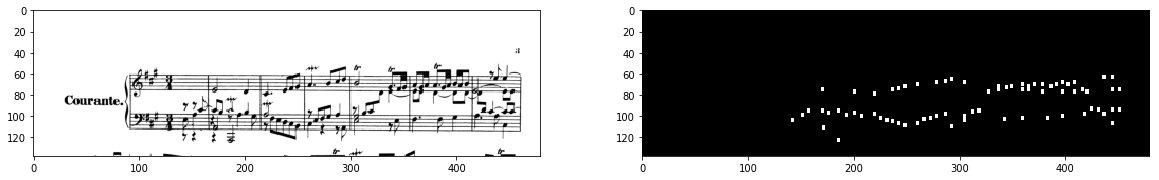

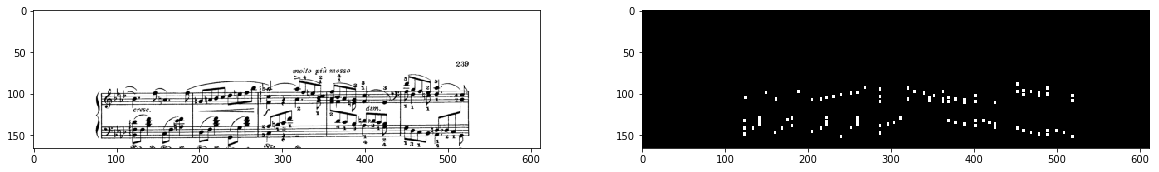

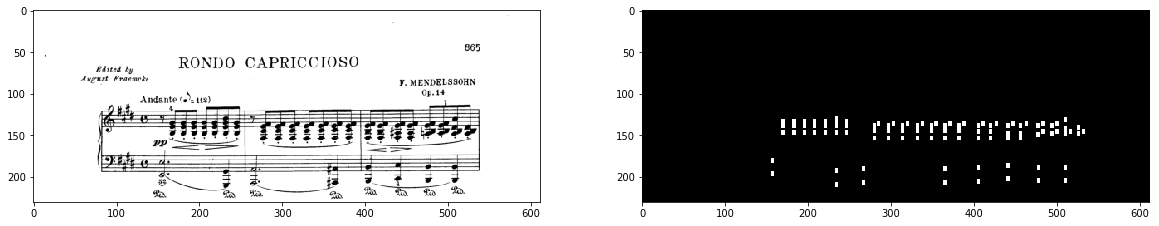

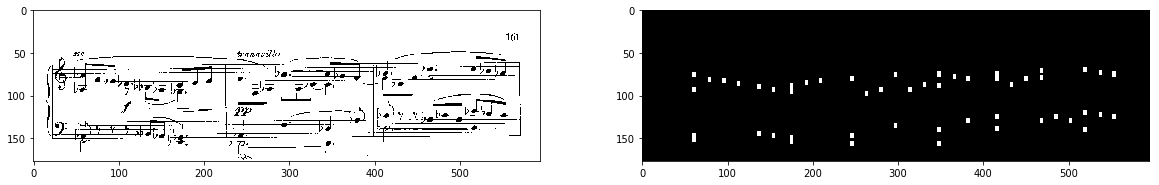

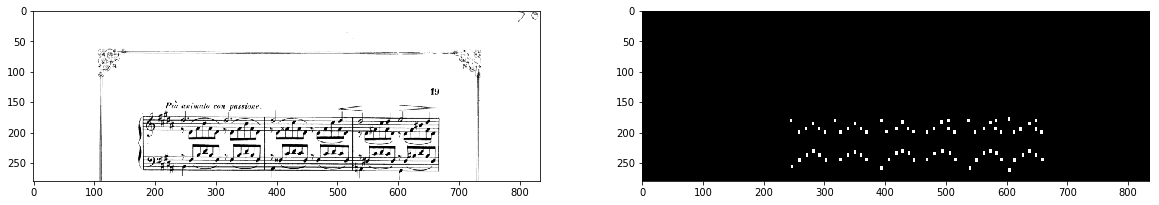

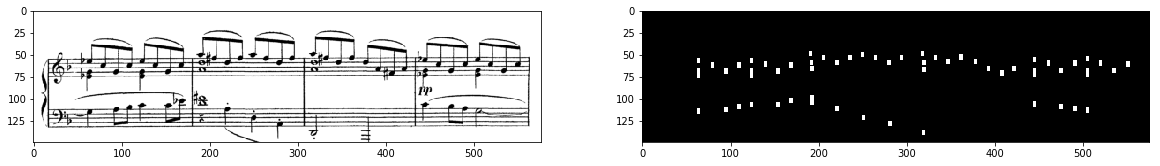

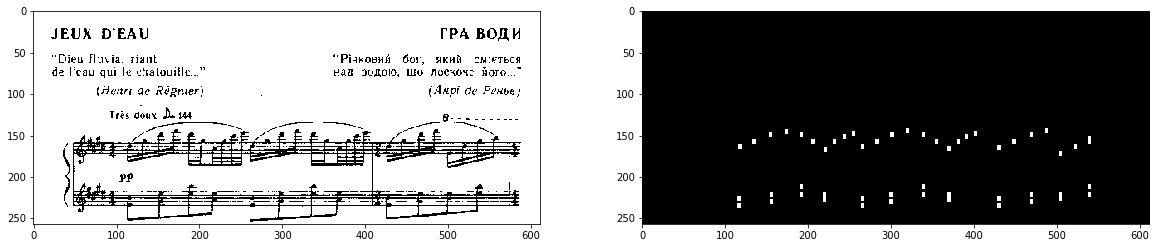

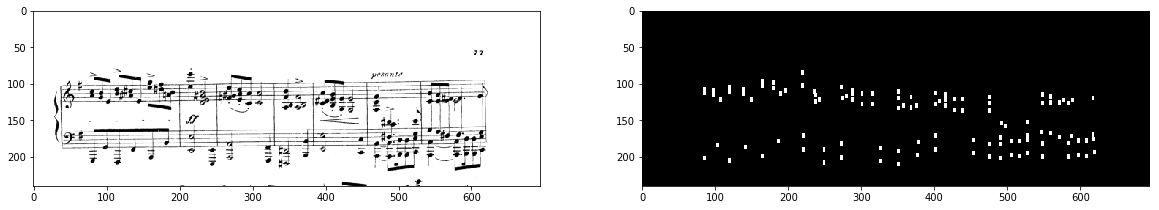

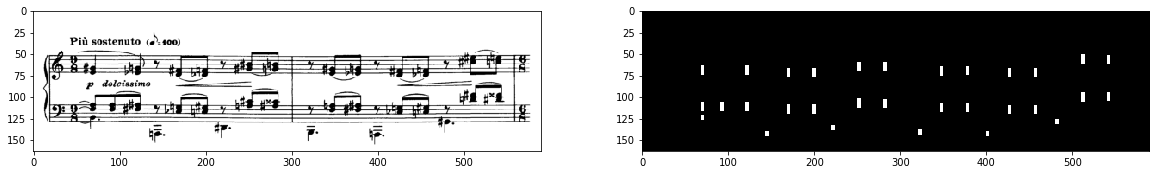

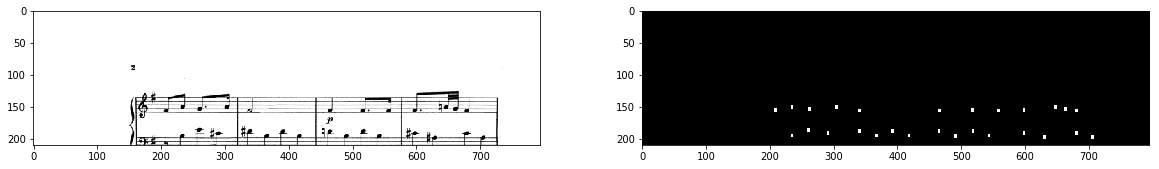

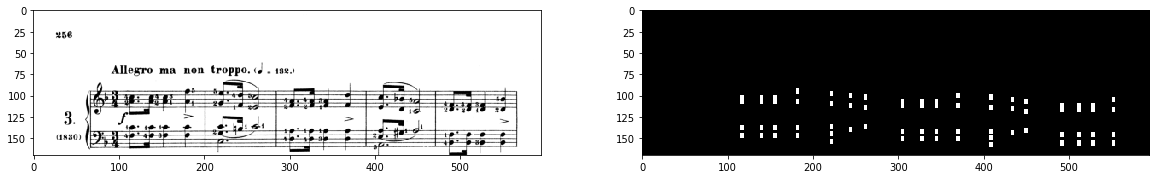

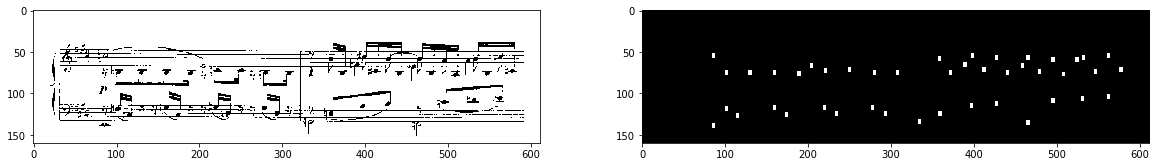

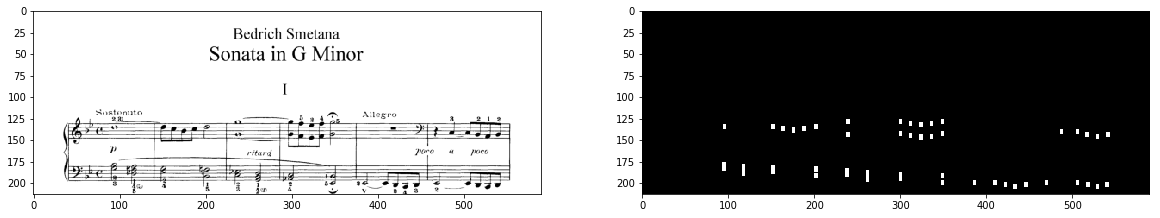

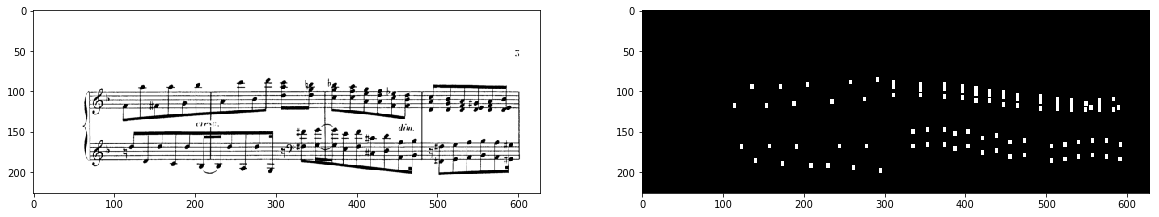

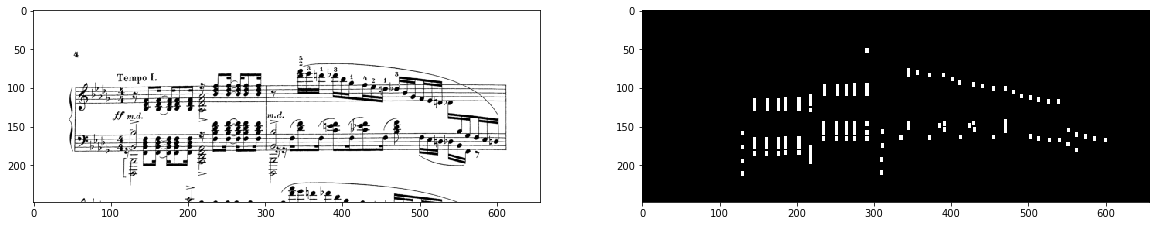

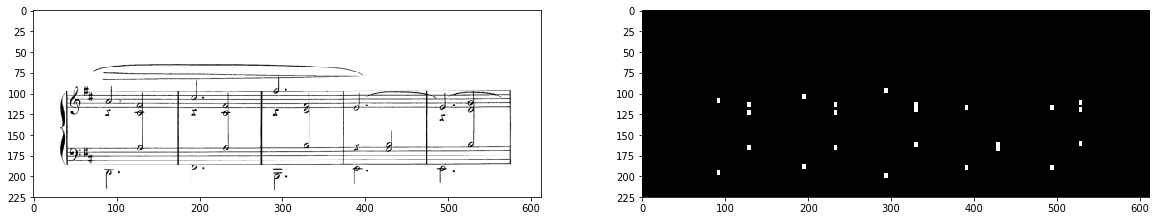

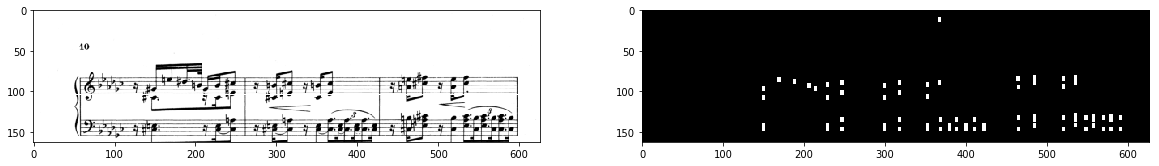

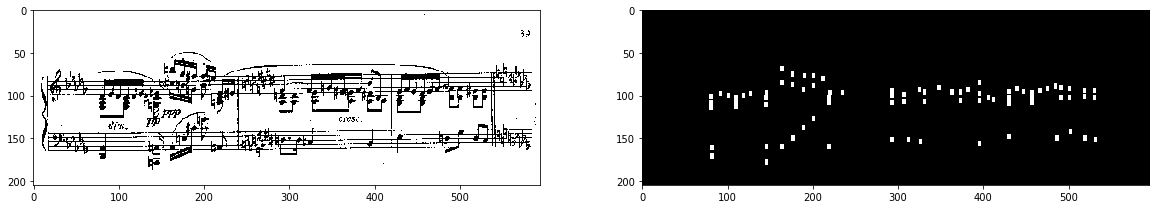

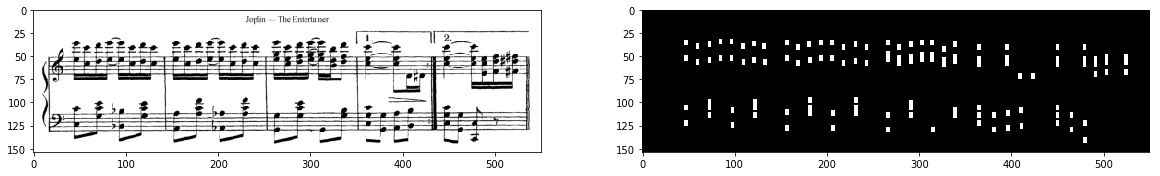

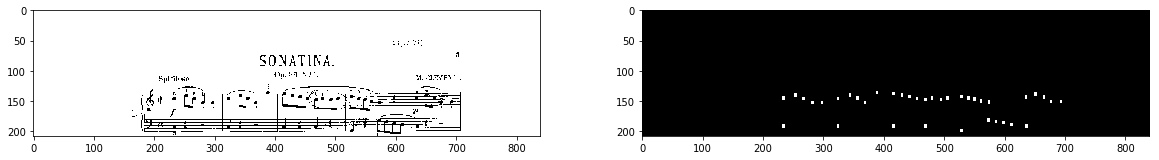

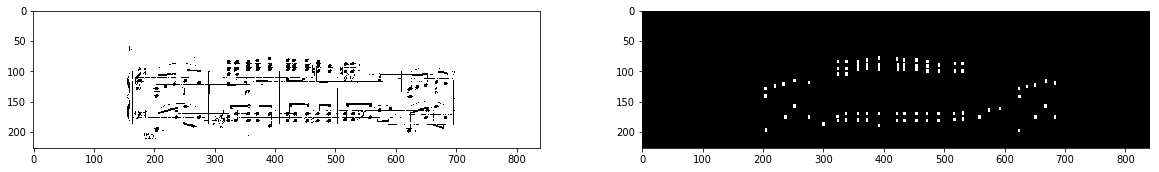

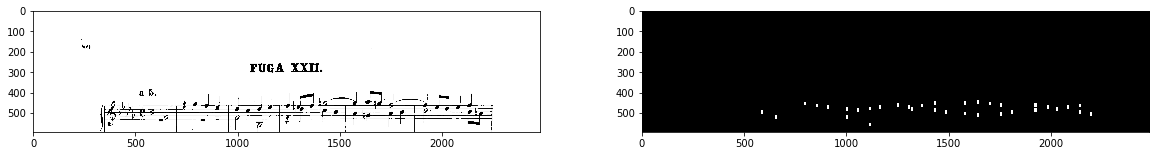

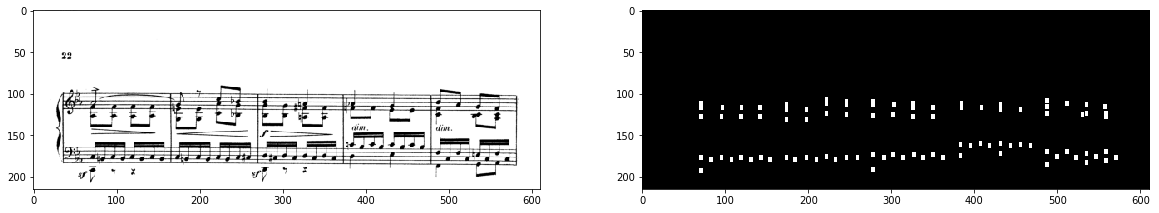

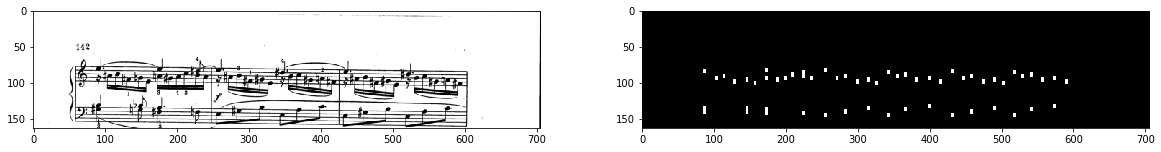

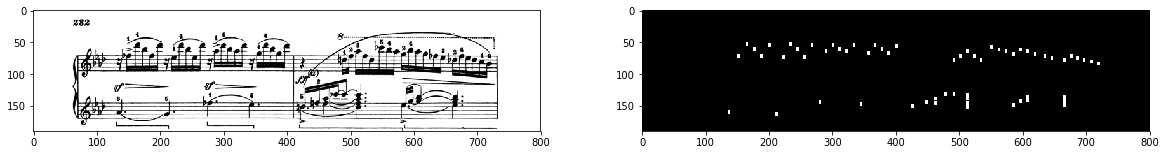

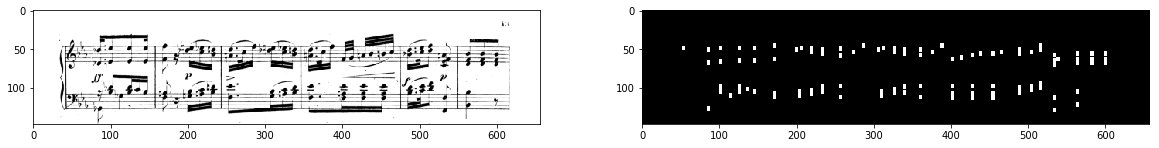

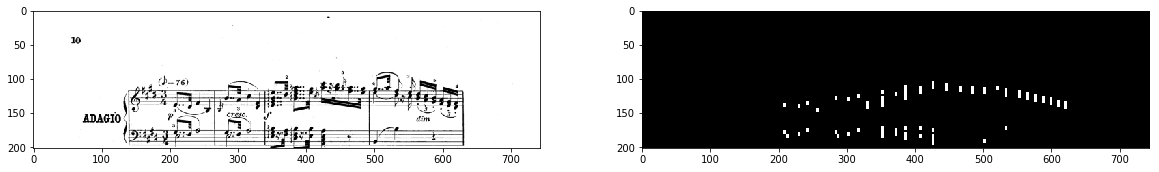

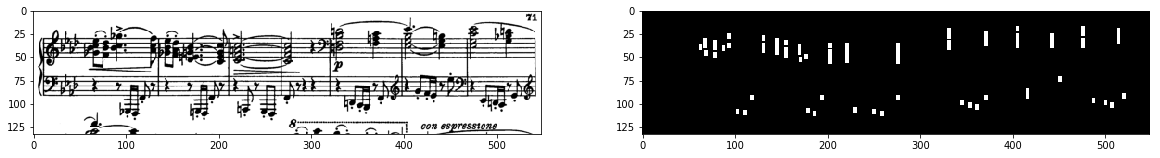

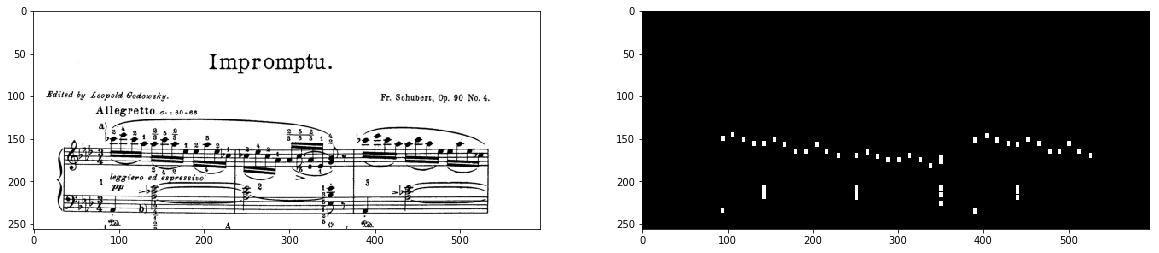

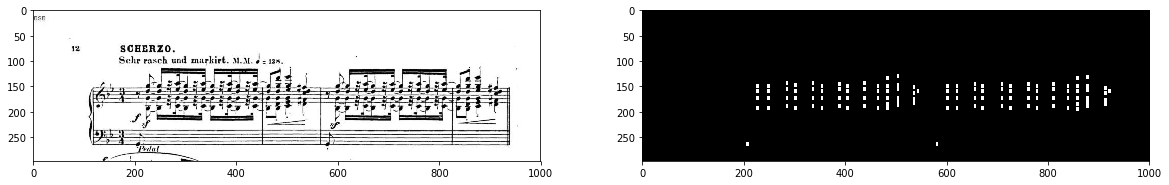

In [3]:
for annotation in annotations:
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(annotations[annotation][0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(annotations[annotation][1], cmap='gray')
    plt.show()

In [4]:
gt_boxes = {"img_00285.png": [[480, 457, 515, 529], [637, 435, 676, 536]], "img_00225.png": [[522, 540, 576, 660], [739, 460, 768, 545]], "img_00224.png": [[527, 539, 575, 660], [747, 459, 769, 546]], "img_00209.png": [[757, 472, 785, 567], [498, 562, 575, 687]], "img_00422.png": [[387, 588, 461, 725], [691, 500, 745, 601]], "img_00327.png": [[542, 433, 580, 508], [668, 454, 702, 537]], "img_00276.png": [[467, 465, 498, 541], [646, 411, 685, 519]], "img_00238.png": [[513, 520, 570, 627], [722, 452, 753, 534]], "img_00136.png": [[568, 700, 648, 853], [801, 722, 867, 936]], "img_00412.png": [[393, 579, 463, 711], [709, 482, 743, 577]], "img_00114.png": [[547, 818, 653, 1029], [827, 925, 912, 1164]], "img_00178.png": [[548, 591, 616, 720], [768, 533, 810, 646]], "img_00164.png": [[770, 569, 834, 718], [564, 613, 624, 754]], "img_00185.png": [[534, 587, 595, 707], [769, 513, 806, 634]], "img_00402.png": [[405, 564, 464, 697], [711, 472, 737, 558]], "img_00428.png": [[369, 525, 456, 704], [676, 503, 718, 603]], "img_00144.png": [[795, 684, 855, 858], [578, 673, 650, 841]], "img_00374.png": [[421, 488, 465, 570], [665, 455, 702, 524]], "img_00248.png": [[492, 507, 553, 598], [700, 455, 737, 525]], "img_00407.png": [[404, 580, 468, 711], [709, 479, 741, 562]], "img_00244.png": [[704, 453, 752, 535], [502, 512, 564, 614]], "img_00337.png": [[648, 451, 688, 537], [536, 436, 580, 510]], "img_00336.png": [[543, 435, 577, 508], [653, 453, 687, 535]], "img_00124.png": [[556, 766, 652, 937], [791, 846, 900, 1063]], "img_00371.png": [[431, 480, 475, 568], [658, 450, 699, 522]], "img_00162.png": [[564, 617, 631, 752], [773, 581, 844, 721]], "img_00163.png": [[565, 617, 626, 755], [772, 573, 839, 720]], "img_00357.png": [[494, 458, 534, 526], [643, 447, 673, 528]], "img_00405.png": [[404, 577, 473, 712], [708, 477, 738, 566]], "img_00189.png": [[764, 511, 805, 619], [527, 583, 585, 702]], "img_00305.png": [[673, 451, 707, 533], [515, 435, 554, 510]], "img_00381.png": [[404, 502, 455, 602], [683, 456, 714, 524]], "img_00175.png": [[768, 538, 814, 670], [557, 593, 618, 722]], "img_00151.png": [[784, 644, 841, 814], [578, 649, 650, 798]], "img_00372.png": [[428, 483, 471, 568], [662, 453, 699, 524]], "img_00358.png": [[490, 463, 522, 524], [644, 449, 675, 528]], "img_00382.png": [[402, 510, 453, 602], [688, 460, 721, 532]], "img_00204.png": [[499, 537, 574, 687], [758, 478, 794, 583]], "img_00315.png": [[527, 420, 563, 506], [676, 454, 715, 538]], "img_00314.png": [[673, 454, 713, 538], [527, 430, 563, 511]], "img_00230.png": [[508, 535, 572, 654], [736, 456, 765, 543]], "img_00280.png": [[466, 457, 504, 534], [643, 415, 675, 521]], "img_00257.png": [[686, 454, 720, 529], [460, 492, 526, 581]], "img_00344.png": [[651, 449, 678, 531], [524, 446, 578, 512]], "img_00239.png": [[514, 524, 572, 628], [723, 452, 750, 534]], "img_00356.png": [[496, 457, 539, 528], [646, 446, 672, 531]], "img_00113.png": [[545, 823, 657, 1031], [827, 921, 920, 1156]], "img_00331.png": [[545, 434, 580, 507], [665, 452, 687, 539]], "img_00245.png": [[501, 512, 559, 609], [709, 455, 747, 531]], "img_00200.png": [[760, 485, 795, 587], [500, 524, 576, 685]], "img_00269.png": [[658, 452, 691, 529], [463, 474, 499, 562]], "img_00192.png": [[525, 586, 586, 703], [765, 500, 802, 611]], "img_00172.png": [[562, 598, 618, 726], [769, 549, 815, 678]], "img_00306.png": [[517, 436, 560, 510], [679, 451, 708, 532]], "img_00430.png": [[668, 503, 709, 607], [368, 531, 454, 700]], "img_00316.png": [[679, 454, 715, 540], [529, 414, 564, 504]], "img_00229.png": [[736, 456, 765, 542], [511, 536, 572, 665]], "img_00326.png": [[670, 453, 702, 538], [541, 435, 578, 506]], "img_00134.png": [[802, 743, 875, 950], [567, 709, 653, 877]], "img_00429.png": [[671, 503, 712, 606], [370, 525, 451, 702]], "img_00243.png": [[706, 451, 749, 535], [506, 515, 565, 623]], "img_00342.png": [[648, 450, 683, 534], [529, 442, 578, 511]], "img_00362.png": [[644, 452, 683, 525], [471, 464, 519, 539]], "img_00266.png": [[663, 461, 692, 532], [457, 475, 503, 563]], "img_00416.png": [[386, 587, 458, 722], [705, 493, 744, 578]], "img_00262.png": [[450, 473, 512, 563], [671, 460, 701, 530]], "img_00369.png": [[659, 450, 700, 525], [438, 473, 479, 562]], "img_00168.png": [[564, 607, 618, 746], [771, 565, 820, 701]], "img_00180.png": [[544, 591, 613, 715], [769, 527, 808, 643]], "img_00205.png": [[501, 540, 576, 687], [756, 480, 790, 578]], "img_00246.png": [[496, 510, 550, 599], [705, 456, 744, 530]], "img_00287.png": [[645, 449, 677, 535], [487, 453, 517, 523]], "img_00434.png": [[658, 509, 693, 613], [368, 538, 457, 701]], "img_00425.png": [[682, 506, 738, 599], [380, 548, 463, 718]], "img_00235.png": [[728, 455, 756, 535], [517, 522, 572, 629]], "img_00328.png": [[670, 453, 698, 539], [545, 433, 581, 506]], "img_00251.png": [[482, 496, 551, 595], [698, 455, 725, 529]], "img_00227.png": [[742, 458, 765, 540], [517, 539, 573, 659]], "img_00406.png": [[708, 478, 744, 560], [403, 579, 463, 713]], "img_00122.png": [[558, 774, 655, 956], [801, 857, 895, 1092]], "img_00202.png": [[502, 533, 574, 684], [759, 482, 790, 584]], "img_00254.png": [[691, 455, 722, 531], [473, 496, 541, 585]], "img_00222.png": [[742, 461, 770, 551], [525, 542, 578, 664]], "img_00166.png": [[566, 610, 625, 752], [772, 568, 825, 713]], "img_00112.png": [[544, 828, 645, 1031], [822, 927, 925, 1150]], "img_00375.png": [[420, 490, 465, 569], [669, 455, 701, 523]], "img_00403.png": [[406, 565, 468, 701], [709, 472, 738, 562]], "img_00195.png": [[513, 554, 587, 700], [760, 493, 799, 606]], "img_00143.png": [[575, 678, 644, 849], [796, 691, 852, 862]], "img_00395.png": [[397, 537, 447, 656], [705, 468, 732, 545]], "img_00146.png": [[578, 670, 648, 829], [796, 671, 849, 850]], "img_00147.png": [[580, 663, 649, 818], [792, 659, 850, 846]], "img_00409.png": [[399, 580, 462, 713], [707, 479, 743, 565]], "img_00237.png": [[723, 451, 753, 534], [516, 521, 571, 629]], "img_00234.png": [[731, 457, 762, 536], [517, 525, 575, 631]], "img_00297.png": [[661, 455, 699, 538], [505, 444, 541, 514]], "img_00281.png": [[470, 455, 506, 531], [643, 418, 678, 525]], "img_00208.png": [[500, 560, 573, 687], [758, 476, 786, 567]], "img_00319.png": [[532, 421, 574, 504], [672, 455, 714, 537]], "img_00318.png": [[673, 456, 714, 537], [533, 417, 573, 504]], "img_00335.png": [[655, 453, 689, 537], [544, 433, 578, 509]], "img_00420.png": [[390, 596, 463, 725], [695, 495, 746, 594]], "img_00277.png": [[465, 461, 501, 540], [642, 411, 683, 519]], "img_00373.png": [[419, 488, 464, 566], [662, 454, 700, 521]], "img_00105.png": [[841, 996, 938, 1164], [544, 876, 655, 1125]], "img_00410.png": [[709, 477, 746, 572], [399, 581, 461, 711]], "img_00199.png": [[761, 487, 792, 588], [503, 523, 574, 683]], "img_00165.png": [[772, 568, 830, 715], [565, 612, 626, 754]], "img_00386.png": [[396, 523, 452, 619], [694, 462, 727, 529]], "img_00141.png": [[795, 699, 856, 879], [572, 682, 646, 850]], "img_00177.png": [[769, 533, 808, 652], [549, 593, 616, 723]], "img_00396.png": [[706, 469, 737, 545], [399, 538, 446, 657]], "img_00145.png": [[576, 670, 647, 838], [794, 677, 852, 854]], "img_00295.png": [[662, 454, 697, 537], [504, 442, 542, 514]], "img_00296.png": [[662, 455, 699, 535], [508, 441, 540, 513]], "img_00217.png": [[748, 464, 778, 554], [525, 554, 583, 688]], "img_00398.png": [[706, 468, 733, 549], [403, 547, 454, 668]], "img_00317.png": [[676, 455, 713, 536], [528, 415, 567, 504]], "img_00310.png": [[669, 455, 714, 535], [520, 440, 561, 509]], "img_00408.png": [[707, 480, 747, 562], [401, 581, 463, 713]], "img_00203.png": [[500, 535, 574, 686], [759, 480, 794, 582]], "img_00389.png": [[402, 538, 446, 636], [699, 464, 732, 543]], "img_00135.png": [[803, 728, 872, 943], [568, 702, 648, 859]], "img_00299.png": [[660, 457, 711, 534], [509, 442, 542, 510]], "img_00322.png": [[670, 457, 714, 537], [537, 433, 579, 505]], "img_00364.png": [[648, 451, 693, 525], [456, 472, 501, 542]], "img_00167.png": [[769, 565, 825, 702], [561, 606, 623, 747]], "img_00263.png": [[449, 474, 511, 566], [670, 461, 694, 534]], "img_00400.png": [[405, 557, 458, 686], [708, 470, 733, 550]], "img_00150.png": [[580, 652, 646, 796], [788, 646, 844, 825]], "img_00393.png": [[400, 535, 447, 646], [703, 469, 734, 545]], "img_00155.png": [[781, 610, 837, 773], [577, 638, 645, 789]], "img_00118.png": [[554, 799, 656, 1006], [813, 889, 903, 1162]], "img_00139.png": [[797, 711, 863, 917], [570, 689, 653, 856]], "img_00307.png": [[519, 436, 561, 509], [674, 453, 709, 533]], "img_00304.png": [[513, 435, 554, 512], [669, 452, 708, 534]], "img_00284.png": [[641, 433, 678, 535], [478, 458, 516, 532]], "img_00291.png": [[644, 454, 677, 537], [496, 447, 530, 517]], "img_00324.png": [[538, 434, 577, 505], [668, 455, 710, 536]], "img_00130.png": [[565, 734, 648, 926], [768, 781, 892, 1024]], "img_00301.png": [[511, 441, 554, 511], [660, 457, 712, 533]], "img_00347.png": [[649, 447, 672, 530], [513, 450, 567, 512]], "img_00404.png": [[707, 476, 739, 563], [405, 571, 470, 708]], "img_00117.png": [[553, 806, 653, 1024], [821, 898, 902, 1157]], "img_00272.png": [[654, 434, 691, 526], [463, 471, 496, 555]], "img_00159.png": [[773, 597, 843, 738], [568, 622, 639, 759]], "img_00370.png": [[437, 476, 479, 567], [658, 450, 697, 524]], "img_00188.png": [[529, 585, 589, 704], [766, 514, 805, 623]], "img_00213.png": [[751, 470, 785, 562], [516, 560, 575, 691]], "img_00367.png": [[449, 474, 488, 546], [651, 451, 698, 525]], "img_00152.png": [[580, 643, 651, 798], [784, 638, 838, 798]], "img_00379.png": [[679, 453, 706, 524], [404, 490, 459, 591]], "img_00187.png": [[767, 514, 805, 629], [533, 584, 589, 704]], "img_00156.png": [[572, 634, 645, 784], [778, 604, 834, 768]], "img_00255.png": [[465, 495, 536, 581], [689, 453, 721, 531]], "img_00427.png": [[376, 530, 456, 707], [676, 506, 724, 599]], "img_00286.png": [[639, 444, 676, 536], [481, 455, 519, 526]], "img_00216.png": [[522, 555, 581, 687], [751, 464, 780, 555]], "img_00302.png": [[665, 454, 711, 533], [512, 438, 548, 511]], "img_00303.png": [[671, 452, 707, 536], [514, 438, 551, 511]], "img_00293.png": [[501, 445, 533, 517], [658, 454, 679, 535]], "img_00132.png": [[566, 728, 647, 921], [770, 776, 889, 994]], "img_00274.png": [[651, 428, 686, 522], [467, 472, 495, 553]], "img_00211.png": [[498, 565, 576, 689], [756, 470, 784, 566]], "img_00345.png": [[518, 448, 574, 510], [646, 444, 675, 529]], "img_00249.png": [[698, 456, 732, 534], [491, 503, 553, 601]], "img_00158.png": [[570, 625, 636, 759], [776, 597, 843, 751]], "img_00377.png": [[675, 454, 703, 522], [411, 488, 461, 578]], "img_00365.png": [[452, 475, 495, 545], [651, 450, 696, 524]], "img_00353.png": [[646, 447, 671, 532], [503, 451, 546, 515]], "img_00197.png": [[760, 494, 796, 594], [507, 523, 579, 689]], "img_00323.png": [[537, 434, 578, 508], [669, 455, 710, 538]], "img_00169.png": [[769, 561, 817, 691], [564, 603, 619, 740]], "img_00108.png": [[543, 854, 646, 1060], [836, 963, 938, 1166]], "img_00181.png": [[767, 520, 807, 641], [540, 588, 609, 710]], "img_00397.png": [[706, 466, 734, 548], [404, 543, 448, 665]], "img_00329.png": [[548, 434, 580, 507], [665, 453, 695, 536]], "img_00236.png": [[724, 454, 757, 536], [516, 521, 574, 629]], "img_00250.png": [[486, 500, 549, 598], [696, 457, 729, 532]], "img_00313.png": [[524, 429, 562, 513], [672, 456, 715, 539]], "img_00385.png": [[691, 462, 724, 531], [394, 524, 452, 610]], "img_00283.png": [[478, 456, 512, 532], [641, 427, 674, 530]], "img_00282.png": [[475, 457, 511, 530], [641, 423, 676, 528]], "img_00421.png": [[388, 592, 464, 723], [694, 498, 745, 597]], "img_00226.png": [[739, 458, 766, 543], [517, 539, 571, 664]], "img_00201.png": [[499, 527, 580, 681], [760, 484, 792, 591]], "img_00273.png": [[465, 472, 497, 556], [654, 431, 691, 525]], "img_00418.png": [[699, 494, 744, 586], [388, 594, 462, 725]], "img_00298.png": [[662, 455, 704, 538], [509, 444, 545, 511]], "img_00123.png": [[795, 852, 897, 1076], [557, 771, 654, 947]], "img_00288.png": [[642, 456, 675, 535], [489, 451, 523, 523]], "img_00355.png": [[645, 447, 671, 530], [497, 453, 542, 523]], "img_00354.png": [[497, 452, 543, 521], [645, 446, 672, 528]], "img_00160.png": [[567, 619, 630, 749], [770, 590, 846, 729]], "img_00380.png": [[682, 453, 708, 521], [404, 495, 457, 602]], "img_00103.png": [[847, 1003, 942, 1166], [546, 887, 656, 1147]], "img_00368.png": [[658, 452, 700, 525], [442, 474, 485, 559]], "img_00259.png": [[680, 456, 711, 530], [454, 480, 522, 578]], "img_00384.png": [[687, 461, 721, 533], [395, 522, 455, 604]], "img_00194.png": [[760, 496, 799, 605], [518, 575, 588, 701]], "img_00394.png": [[399, 537, 444, 652], [705, 470, 735, 547]], "img_00191.png": [[764, 503, 802, 614], [525, 577, 586, 704]], "img_00190.png": [[525, 583, 586, 701], [765, 508, 803, 613]], "img_00294.png": [[500, 443, 537, 515], [657, 453, 685, 535]], "img_00435.png": [[655, 512, 695, 615], [366, 539, 455, 700]], "img_00436.png": [[371, 546, 457, 708], [653, 517, 687, 611]], "img_00218.png": [[526, 550, 582, 687], [749, 463, 777, 552]], "img_00219.png": [[749, 460, 775, 554], [524, 549, 580, 681]], "img_00210.png": [[755, 471, 785, 568], [497, 566, 574, 688]], "img_00271.png": [[656, 439, 690, 530], [464, 473, 498, 562]], "img_00346.png": [[648, 446, 677, 531], [514, 449, 569, 513]], "img_00348.png": [[513, 451, 561, 512], [648, 446, 673, 528]], "img_00308.png": [[667, 453, 712, 535], [524, 439, 563, 511]], "img_00275.png": [[465, 466, 500, 547], [650, 422, 685, 519]], "img_00401.png": [[405, 559, 461, 693], [707, 471, 735, 558]], "img_00334.png": [[547, 431, 579, 511], [657, 452, 689, 537]], "img_00161.png": [[566, 614, 633, 754], [770, 584, 840, 727]], "img_00212.png": [[507, 561, 572, 691], [752, 466, 781, 563]], "img_00366.png": [[653, 453, 695, 524], [450, 472, 492, 544]], "img_00198.png": [[760, 491, 797, 591], [508, 520, 577, 686]], "img_00388.png": [[403, 537, 447, 637], [699, 462, 735, 542]], "img_00196.png": [[760, 496, 796, 596], [510, 531, 579, 690]], "img_00186.png": [[534, 585, 593, 703], [769, 514, 806, 634]], "img_00176.png": [[768, 534, 813, 661], [551, 592, 617, 722]], "img_00157.png": [[570, 628, 640, 770], [777, 600, 842, 760]], "img_00173.png": [[769, 542, 816, 675], [557, 595, 619, 721]], "img_00221.png": [[526, 543, 578, 666], [744, 461, 773, 555]], "img_00138.png": [[799, 712, 861, 923], [569, 690, 654, 852]], "img_00424.png": [[683, 504, 742, 600], [378, 563, 460, 721]], "img_00399.png": [[404, 554, 455, 682], [708, 469, 733, 554]], "img_00292.png": [[498, 446, 533, 516], [652, 453, 679, 534]], "img_00129.png": [[563, 742, 646, 927], [767, 792, 897, 1047]], "img_00228.png": [[742, 453, 765, 542], [513, 539, 573, 661]], "img_00133.png": [[799, 755, 879, 959], [567, 715, 649, 896]], "img_00338.png": [[650, 451, 689, 537], [537, 433, 580, 512]], "img_00321.png": [[535, 428, 576, 503], [668, 456, 712, 536]], "img_00349.png": [[648, 446, 672, 527], [511, 452, 559, 511]], "img_00242.png": [[507, 517, 567, 631], [714, 455, 752, 534]], "img_00360.png": [[644, 451, 677, 524], [481, 463, 523, 528]], "img_00207.png": [[500, 552, 577, 688]], "img_00363.png": [[466, 466, 517, 541], [645, 449, 687, 524]], "img_00206.png": [[758, 479, 788, 575], [499, 545, 579, 689]], "img_00140.png": [[795, 706, 857, 896], [571, 684, 650, 854]], "img_00174.png": [[558, 595, 617, 722], [771, 538, 811, 672]], "img_00247.png": [[702, 454, 741, 528], [495, 507, 553, 599]], "img_00170.png": [[766, 559, 816, 685], [564, 602, 621, 737]], "img_00260.png": [[677, 458, 706, 530], [447, 471, 516, 571]], "img_00426.png": [[370, 533, 458, 711], [679, 506, 733, 601]], "img_00279.png": [[643, 414, 682, 516], [466, 458, 500, 533]], "img_00417.png": [[702, 494, 746, 580], [386, 590, 460, 722]], "img_00300.png": [[512, 441, 546, 511], [661, 457, 712, 535]], "img_00433.png": [[661, 508, 694, 609], [368, 535, 455, 703]], "img_00415.png": [[706, 492, 744, 579], [385, 585, 462, 721]], "img_00341.png": [[646, 449, 683, 534], [534, 440, 579, 512]], "img_00431.png": [[660, 545, 675, 560], [367, 529, 454, 702], [667, 504, 705, 608]], "img_00120.png": [[554, 790, 660, 994], [808, 875, 895, 1149]], "img_00309.png": [[670, 454, 713, 538], [523, 440, 561, 511]], "img_00240.png": [[512, 524, 574, 628], [724, 452, 750, 537]], "img_00351.png": [[646, 444, 671, 530], [507, 451, 550, 516]], "img_00413.png": [[388, 580, 459, 719], [702, 488, 744, 580]], "img_00343.png": [[528, 443, 578, 514], [649, 448, 680, 531]], "img_00378.png": [[678, 450, 706, 524], [410, 489, 458, 584]], "img_00359.png": [[486, 462, 524, 525], [643, 448, 678, 527]], "img_00311.png": [[669, 454, 716, 536], [525, 436, 560, 511]], "img_00265.png": [[455, 476, 506, 560], [664, 464, 696, 532]], "img_00278.png": [[643, 412, 679, 517], [467, 458, 502, 539]], "img_00423.png": [[383, 577, 462, 723], [690, 504, 747, 599]], "img_00339.png": [[647, 451, 686, 537], [537, 438, 578, 511]], "img_00264.png": [[445, 473, 508, 562], [667, 461, 695, 533]], "img_00126.png": [[774, 814, 900, 1067], [557, 753, 643, 929]], "img_00127.png": [[561, 749, 643, 930], [770, 809, 897, 1063]], "img_00270.png": [[458, 474, 496, 560], [657, 446, 693, 529]], "img_00267.png": [[459, 477, 500, 561], [664, 462, 691, 533]], "img_00312.png": [[669, 455, 718, 537], [524, 432, 564, 510]], "img_00361.png": [[643, 450, 679, 523], [477, 461, 522, 530]], "img_00148.png": [[789, 658, 851, 843], [579, 660, 652, 814]], "img_00149.png": [[580, 656, 648, 797], [787, 648, 847, 834]], "img_00106.png": [[544, 870, 658, 1106], [838, 988, 938, 1166]], "img_00414.png": [[707, 490, 746, 580], [386, 583, 461, 721]], "img_00352.png": [[648, 446, 671, 531], [506, 451, 546, 516]], "img_00153.png": [[576, 644, 647, 798], [783, 632, 837, 782]], "img_00256.png": [[686, 455, 719, 529], [461, 491, 528, 580]], "img_00193.png": [[762, 499, 801, 608], [520, 585, 586, 702]], "img_00411.png": [[395, 580, 461, 711], [708, 479, 743, 574]], "img_00214.png": [[521, 559, 577, 690], [751, 469, 782, 555]], "img_00232.png": [[731, 457, 765, 537], [512, 529, 572, 639]], "img_00233.png": [[732, 455, 763, 537], [512, 528, 574, 637]], "img_00128.png": [[564, 746, 644, 930], [764, 800, 895, 1052]], "img_00419.png": [[389, 598, 465, 722], [695, 494, 745, 586]], "img_00125.png": [[560, 758, 646, 930], [787, 832, 900, 1069]], "img_00320.png": [[533, 424, 577, 504], [672, 456, 715, 538]], "img_00137.png": [[798, 716, 866, 931], [568, 694, 652, 852]], "img_00121.png": [[809, 864, 894, 1120], [558, 784, 657, 971]], "img_00392.png": [[400, 535, 448, 643], [703, 465, 733, 549]], "img_00391.png": [[701, 466, 733, 546], [400, 538, 447, 641]], "img_00107.png": [[847, 976, 942, 1166], [545, 866, 655, 1090]], "img_00179.png": [[765, 531, 810, 644], [544, 590, 615, 716]], "img_00350.png": [[646, 446, 672, 530], [509, 452, 554, 512]], "img_00332.png": [[662, 453, 688, 536], [545, 435, 580, 509]], "img_00387.png": [[403, 537, 453, 634], [698, 460, 730, 539]], "img_00184.png": [[768, 516, 805, 635], [535, 584, 598, 704]], "img_00330.png": [[544, 433, 581, 507], [665, 453, 689, 538]], "img_00171.png": [[561, 601, 617, 726], [770, 553, 816, 678]], "img_00119.png": [[816, 881, 898, 1163], [556, 795, 656, 1004]], "img_00154.png": [[577, 642, 648, 799], [783, 623, 834, 781]], "img_00220.png": [[524, 546, 578, 672], [747, 459, 772, 554]], "img_00223.png": [[744, 460, 774, 544], [526, 538, 577, 659]], "img_00290.png": [[643, 457, 677, 535], [495, 449, 528, 521]], "img_00376.png": [[674, 453, 703, 521], [413, 491, 463, 575]], "img_00231.png": [[733, 454, 764, 538], [510, 532, 568, 651]], "img_00131.png": [[566, 730, 648, 925], [769, 777, 889, 1003]], "img_00325.png": [[670, 452, 706, 536], [541, 434, 579, 506]], "img_00340.png": [[645, 452, 685, 537], [536, 437, 577, 509]], "img_00390.png": [[401, 538, 444, 635], [702, 464, 731, 544]], "img_00289.png": [[492, 451, 529, 523], [643, 458, 675, 535]], "img_00383.png": [[691, 459, 719, 530], [396, 518, 455, 599]], "img_00432.png": [[664, 504, 700, 608], [367, 532, 454, 701]], "img_00116.png": [[550, 813, 655, 1025], [819, 909, 904, 1163]], "img_00115.png": [[546, 813, 649, 1027], [827, 916, 908, 1165]], "img_00253.png": [[692, 457, 725, 531], [479, 496, 546, 593]], "img_00215.png": [[753, 468, 781, 553], [524, 558, 576, 687]], "img_00258.png": [[454, 483, 521, 579], [682, 454, 715, 528]], "img_00261.png": [[673, 460, 700, 530], [453, 472, 516, 569]], "img_00142.png": [[795, 695, 852, 868], [573, 679, 647, 851]], "img_00252.png": [[482, 497, 549, 592], [696, 455, 725, 530]], "img_00268.png": [[459, 474, 502, 563], [664, 455, 693, 533]], "img_00182.png": [[768, 516, 806, 638], [536, 588, 607, 703]], "img_00183.png": [[537, 587, 603, 703], [767, 515, 806, 639]]}

In [5]:
pred_boxes = {"img_00329.png": {"boxes": [[429, 434, 534, 506], [342, 457, 413, 547], [422, 430, 443, 450], [357, 457, 384, 484], [654, 453, 687, 528], [430, 332, 484, 451], [523, 448, 541, 463], [525, 441, 571, 495], [406, 428, 478, 505], [420, 432, 459, 500], [420, 432, 449, 461], [670, 490, 693, 533], [670, 455, 689, 532], [546, 434, 572, 501]], "scores": [0.0505, 0.0634, 0.0636, 0.0661, 0.0716, 0.1086, 0.1169, 0.1316, 0.1328, 0.2834, 0.2942, 0.3387, 0.965, 0.9891]}, "img_00285.png": {"boxes": [[330, 463, 387, 505], [356, 456, 391, 521], [420, 433, 451, 498], [328, 465, 403, 540], [480, 477, 508, 522], [357, 460, 417, 537], [344, 459, 389, 493], [485, 459, 503, 511], [336, 463, 362, 496], [468, 435, 520, 521], [357, 458, 382, 485], [649, 479, 670, 531], [484, 455, 514, 519], [641, 439, 670, 532]], "scores": [0.0739, 0.0843, 0.091, 0.1008, 0.1012, 0.1058, 0.1243, 0.1266, 0.1342, 0.1618, 0.2452, 0.8505, 0.9113, 0.972]}, "img_00114.png": {"boxes": [[335, 461, 408, 543], [355, 456, 391, 518], [360, 458, 385, 485], [831, 920, 908, 1158], [549, 827, 639, 1017]], "scores": [0.0636, 0.0648, 0.0962, 0.9716, 0.9958]}, "img_00225.png": {"boxes": [[345, 460, 415, 547], [381, 362, 455, 513], [382, 366, 416, 422], [730, 463, 763, 583], [361, 459, 383, 482], [745, 462, 760, 511], [746, 490, 762, 538], [744, 461, 763, 542], [520, 540, 570, 655]], "scores": [0.0539, 0.0542, 0.0559, 0.0588, 0.1127, 0.1679, 0.224, 0.9669, 0.9975]}, "img_00224.png": {"boxes": [[657, 538, 728, 654], [344, 459, 389, 492], [421, 432, 450, 464], [378, 371, 437, 459], [381, 370, 416, 421], [359, 458, 384, 484], [743, 463, 763, 544], [525, 540, 568, 652]], "scores": [0.0518, 0.0589, 0.0644, 0.0793, 0.1092, 0.1193, 0.9569, 0.9989]}, "img_00209.png": {"boxes": [[361, 458, 384, 484], [655, 537, 736, 666], [499, 563, 569, 686], [757, 474, 781, 570]], "scores": [0.0811, 0.0928, 0.9905, 0.9941]}, "img_00271.png": {"boxes": [[420, 433, 452, 497], [331, 463, 387, 505], [331, 464, 397, 540], [457, 441, 499, 550], [336, 463, 362, 496], [345, 459, 390, 491], [654, 430, 676, 456], [357, 458, 383, 485], [660, 432, 685, 525], [464, 472, 492, 555]], "scores": [0.0568, 0.0692, 0.0803, 0.147, 0.1477, 0.1528, 0.2211, 0.2463, 0.9807, 0.9893]}, "img_00327.png": {"boxes": [[690, 417, 706, 458], [435, 326, 496, 447], [342, 457, 415, 545], [441, 336, 485, 416], [377, 413, 505, 489], [649, 452, 694, 537], [506, 443, 532, 462], [377, 421, 452, 515], [357, 457, 383, 483], [424, 433, 446, 452], [407, 429, 478, 502], [669, 452, 690, 525], [522, 432, 571, 505], [420, 433, 457, 497], [420, 432, 449, 463], [672, 465, 697, 536], [547, 431, 574, 503]], "scores": [0.0504, 0.052, 0.0595, 0.065, 0.0671, 0.0683, 0.0705, 0.0734, 0.1233, 0.1317, 0.1409, 0.1765, 0.2512, 0.2942, 0.4201, 0.9405, 0.9936]}, "img_00276.png": {"boxes": [[374, 467, 389, 486], [355, 491, 368, 512], [370, 437, 428, 524], [320, 466, 428, 518], [422, 432, 449, 483], [338, 461, 373, 507], [328, 464, 389, 530], [369, 462, 386, 484], [385, 466, 417, 530], [348, 458, 414, 538], [336, 463, 362, 497], [640, 399, 674, 464], [356, 457, 388, 508], [478, 465, 504, 517], [356, 458, 384, 488], [655, 416, 678, 514], [642, 393, 679, 511], [466, 463, 500, 540]], "scores": [0.0533, 0.061, 0.0616, 0.0769, 0.0881, 0.0905, 0.0955, 0.0961, 0.1168, 0.1421, 0.1792, 0.1857, 0.2222, 0.2268, 0.3524, 0.684, 0.9806, 0.9922]}, "img_00126.png": {"boxes": [[357, 457, 384, 485], [566, 757, 645, 922], [775, 820, 895, 1055]], "scores": [0.0818, 0.9968, 0.9989]}, "img_00331.png": {"boxes": [[424, 346, 468, 444], [647, 449, 682, 525], [424, 337, 499, 454], [395, 424, 465, 505], [360, 457, 385, 483], [420, 433, 450, 462], [420, 433, 458, 499], [666, 452, 685, 534], [548, 432, 574, 502]], "scores": [0.0595, 0.1072, 0.1167, 0.1177, 0.132, 0.3904, 0.4032, 0.9622, 0.9951]}, "img_00136.png": {"boxes": [[360, 458, 385, 484], [798, 723, 867, 936], [567, 701, 644, 848]], "scores": [0.0956, 0.9966, 0.9982]}, "img_00266.png": {"boxes": [[654, 460, 667, 479], [328, 463, 379, 506], [385, 467, 417, 532], [327, 464, 389, 537], [346, 459, 409, 545], [651, 457, 688, 540], [446, 438, 500, 560], [336, 463, 363, 496], [345, 459, 391, 492], [420, 432, 453, 509], [357, 458, 383, 485], [663, 464, 689, 527], [460, 475, 493, 560]], "scores": [0.0571, 0.0721, 0.0768, 0.0858, 0.1, 0.1005, 0.1144, 0.1191, 0.1366, 0.1754, 0.2505, 0.9531, 0.9877]}, "img_00246.png": {"boxes": [[382, 460, 417, 533], [326, 464, 390, 537], [337, 462, 390, 497], [690, 519, 710, 533], [357, 457, 388, 519], [358, 458, 382, 484], [690, 518, 700, 530], [463, 554, 478, 568], [694, 455, 738, 533], [704, 458, 727, 527], [497, 509, 547, 598]], "scores": [0.0561, 0.0601, 0.0618, 0.0693, 0.0717, 0.1041, 0.1266, 0.1725, 0.5171, 0.9063, 0.9969]}, "img_00164.png": {"boxes": [[354, 456, 393, 523], [360, 458, 384, 483], [344, 459, 414, 534], [773, 569, 824, 714], [565, 612, 621, 751]], "scores": [0.0594, 0.0643, 0.0692, 0.9947, 0.9977]}, "img_00185.png": {"boxes": [[330, 463, 408, 542], [656, 533, 732, 669], [360, 458, 385, 483], [768, 516, 805, 631], [536, 589, 592, 701]], "scores": [0.0547, 0.0923, 0.1067, 0.9977, 0.9977]}, "img_00402.png": {"boxes": [[421, 432, 457, 489], [420, 432, 448, 463], [327, 463, 390, 532], [343, 459, 390, 493], [358, 458, 383, 485], [708, 471, 732, 560], [405, 561, 468, 685]], "scores": [0.0522, 0.0575, 0.0584, 0.0703, 0.1049, 0.985, 0.9985]}, "img_00144.png": {"boxes": [[597, 679, 650, 800], [355, 457, 392, 522], [1423, 578, 1581, 896], [343, 458, 412, 546], [617, 693, 641, 722], [361, 458, 384, 482], [619, 692, 640, 763], [614, 688, 643, 798], [577, 675, 641, 833], [793, 685, 847, 850]], "scores": [0.0502, 0.0534, 0.059, 0.0596, 0.0826, 0.0929, 0.1192, 0.5491, 0.9961, 0.9974]}, "img_00248.png": {"boxes": [[340, 463, 406, 544], [1417, 597, 1580, 913], [337, 464, 364, 496], [355, 457, 389, 508], [337, 462, 390, 496], [358, 458, 382, 485], [688, 505, 699, 517], [702, 489, 732, 531], [694, 455, 734, 532], [702, 460, 721, 525], [493, 505, 546, 596]], "scores": [0.0521, 0.06, 0.0632, 0.086, 0.0873, 0.1422, 0.1624, 0.2183, 0.2511, 0.8455, 0.998]}, "img_00372.png": {"boxes": [[335, 464, 363, 499], [318, 464, 388, 547], [345, 458, 391, 493], [357, 458, 382, 484], [422, 431, 455, 499], [353, 466, 395, 551], [364, 517, 394, 556], [662, 456, 694, 522], [431, 482, 465, 567]], "scores": [0.0886, 0.0994, 0.1163, 0.1497, 0.1599, 0.2176, 0.2378, 0.9942, 0.9945]}, "img_00407.png": {"boxes": [[355, 457, 387, 501], [361, 458, 383, 484], [1418, 588, 1580, 878], [708, 480, 737, 563], [404, 580, 470, 703]], "scores": [0.0573, 0.0835, 0.1282, 0.9964, 0.9992]}, "img_00163.png": {"boxes": [[361, 458, 384, 483], [773, 577, 833, 711], [565, 616, 624, 751]], "scores": [0.07, 0.9921, 0.9974]}, "img_00120.png": {"boxes": [[328, 464, 406, 542], [616, 807, 658, 892], [360, 458, 384, 485], [603, 807, 659, 940], [558, 792, 636, 990], [810, 884, 893, 1147]], "scores": [0.0691, 0.0874, 0.0914, 0.4897, 0.9943, 0.9956]}, "img_00301.png": {"boxes": [[418, 431, 446, 489], [369, 426, 435, 525], [319, 469, 413, 542], [422, 431, 442, 451], [1414, 529, 1579, 992], [382, 407, 465, 517], [678, 458, 694, 503], [333, 461, 389, 498], [354, 457, 391, 509], [356, 450, 420, 536], [421, 431, 448, 463], [413, 432, 470, 501], [357, 458, 385, 486], [668, 491, 703, 528], [513, 440, 542, 504], [669, 455, 703, 526]], "scores": [0.0548, 0.055, 0.0671, 0.0697, 0.0719, 0.0872, 0.0891, 0.0956, 0.0975, 0.1056, 0.1599, 0.2366, 0.2751, 0.5198, 0.9543, 0.9672]}, "img_00337.png": {"boxes": [[624, 448, 679, 534], [605, 441, 684, 638], [386, 419, 467, 503], [661, 452, 669, 461], [373, 386, 508, 481], [357, 458, 383, 484], [657, 487, 681, 532], [645, 454, 673, 530], [420, 433, 459, 500], [421, 432, 450, 462], [655, 452, 683, 534], [543, 437, 577, 503]], "scores": [0.0622, 0.0677, 0.0994, 0.1052, 0.1217, 0.1273, 0.1811, 0.2671, 0.3127, 0.3913, 0.988, 0.9974]}, "img_00336.png": {"boxes": [[420, 434, 483, 505], [421, 430, 443, 453], [611, 446, 678, 602], [357, 458, 384, 485], [383, 420, 467, 501], [644, 451, 674, 528], [421, 432, 456, 492], [421, 432, 449, 463], [657, 456, 684, 534], [547, 434, 574, 501]], "scores": [0.0627, 0.0631, 0.0716, 0.0804, 0.0884, 0.111, 0.2856, 0.2916, 0.9797, 0.9949]}, "img_00216.png": {"boxes": [[361, 459, 382, 482], [421, 432, 449, 463], [411, 431, 477, 501], [751, 466, 774, 556], [525, 556, 573, 683]], "scores": [0.0613, 0.0709, 0.0858, 0.9973, 0.9975]}, "img_00371.png": {"boxes": [[321, 494, 401, 571], [420, 432, 448, 517], [336, 464, 363, 496], [356, 456, 392, 535], [346, 459, 390, 492], [357, 458, 382, 484], [358, 488, 397, 555], [343, 464, 400, 552], [366, 519, 397, 557], [433, 476, 469, 565], [661, 457, 694, 523]], "scores": [0.062, 0.1047, 0.1074, 0.1098, 0.1192, 0.126, 0.1276, 0.2796, 0.3137, 0.9922, 0.9957]}, "img_00162.png": {"boxes": [[361, 459, 386, 486], [772, 582, 834, 719], [565, 619, 627, 751]], "scores": [0.0975, 0.9971, 0.9984]}, "img_00398.png": {"boxes": [[356, 456, 388, 508], [381, 458, 416, 533], [358, 457, 383, 485], [707, 468, 731, 548], [401, 546, 452, 663]], "scores": [0.0502, 0.0577, 0.1065, 0.9859, 0.9992]}, "img_00357.png": {"boxes": [[604, 453, 670, 608], [627, 473, 639, 485], [656, 509, 666, 525], [652, 451, 669, 504], [364, 471, 395, 513], [490, 456, 520, 504], [420, 433, 456, 498], [364, 428, 531, 502], [420, 432, 447, 462], [327, 462, 385, 509], [381, 465, 417, 533], [458, 425, 525, 509], [357, 457, 387, 486], [355, 457, 397, 524], [628, 444, 669, 524], [363, 472, 401, 551], [336, 461, 405, 546], [654, 470, 670, 525], [496, 453, 527, 520], [647, 449, 672, 524]], "scores": [0.0529, 0.0574, 0.0585, 0.0587, 0.064, 0.0702, 0.0934, 0.0973, 0.1039, 0.1094, 0.1318, 0.1715, 0.1867, 0.2213, 0.2576, 0.2602, 0.3261, 0.3489, 0.832, 0.9515]}, "img_00405.png": {"boxes": [[346, 457, 416, 546], [421, 432, 448, 463], [402, 427, 475, 501], [355, 456, 391, 519], [420, 432, 459, 498], [339, 461, 394, 496], [357, 457, 385, 486], [709, 479, 735, 561], [404, 576, 474, 704]], "scores": [0.0508, 0.055, 0.0551, 0.0605, 0.0621, 0.0682, 0.1241, 0.9874, 0.999]}, "img_00189.png": {"boxes": [[356, 456, 389, 510], [337, 461, 392, 499], [329, 464, 401, 538], [653, 531, 733, 671], [357, 458, 383, 485], [528, 587, 581, 700], [765, 512, 803, 615]], "scores": [0.0527, 0.0542, 0.0636, 0.0721, 0.0957, 0.9966, 0.9981]}, "img_00355.png": {"boxes": [[415, 435, 474, 516], [619, 465, 654, 525], [325, 465, 397, 555], [365, 475, 400, 546], [355, 457, 393, 514], [336, 462, 367, 494], [327, 462, 383, 506], [531, 495, 540, 507], [381, 457, 401, 477], [640, 446, 676, 553], [378, 465, 402, 486], [381, 462, 416, 532], [362, 460, 418, 504], [421, 431, 446, 460], [420, 432, 451, 500], [626, 448, 669, 528], [368, 464, 395, 486], [354, 460, 413, 538], [342, 460, 398, 493], [357, 458, 390, 487], [497, 447, 533, 518], [648, 451, 670, 523]], "scores": [0.0511, 0.0545, 0.0546, 0.0616, 0.0672, 0.0687, 0.0731, 0.081, 0.0897, 0.1063, 0.1159, 0.1291, 0.1312, 0.1376, 0.1575, 0.1665, 0.2098, 0.2548, 0.2819, 0.361, 0.9098, 0.9554]}, "img_00401.png": {"boxes": [[346, 458, 414, 547], [347, 459, 396, 494], [358, 458, 384, 485], [708, 472, 732, 557], [404, 559, 470, 688]], "scores": [0.0546, 0.0856, 0.1193, 0.9848, 0.9977]}, "img_00151.png": {"boxes": [[1416, 595, 1580, 897], [361, 458, 384, 484], [785, 644, 843, 808], [579, 653, 645, 787]], "scores": [0.0705, 0.0976, 0.9967, 0.9976]}, "img_00406.png": {"boxes": [[383, 466, 416, 534], [331, 463, 400, 538], [356, 456, 389, 509], [332, 462, 386, 499], [358, 458, 383, 484], [709, 480, 736, 564], [403, 577, 472, 706]], "scores": [0.0539, 0.0542, 0.0663, 0.0672, 0.1024, 0.9917, 0.9993]}, "img_00358.png": {"boxes": [[319, 469, 402, 551], [631, 467, 651, 490], [633, 447, 675, 549], [367, 443, 424, 531], [360, 435, 539, 512], [355, 458, 393, 516], [421, 433, 455, 495], [1422, 588, 1580, 898], [440, 433, 518, 518], [632, 450, 654, 491], [645, 452, 667, 494], [381, 461, 416, 534], [358, 458, 383, 484], [625, 449, 671, 502], [476, 435, 516, 509], [351, 458, 410, 540], [634, 479, 648, 489], [657, 470, 672, 522], [487, 458, 521, 517], [646, 449, 674, 520]], "scores": [0.0503, 0.0575, 0.0587, 0.0682, 0.0704, 0.0742, 0.0786, 0.079, 0.0961, 0.099, 0.1018, 0.1026, 0.159, 0.1645, 0.1896, 0.2572, 0.2578, 0.577, 0.9152, 0.9548]}, "img_00244.png": {"boxes": [[356, 457, 388, 503], [696, 505, 705, 515], [697, 452, 728, 522], [383, 466, 417, 534], [362, 459, 383, 483], [710, 458, 729, 516], [706, 458, 743, 529], [503, 512, 559, 611]], "scores": [0.0541, 0.0615, 0.0639, 0.1083, 0.1144, 0.2272, 0.9573, 0.9963]}, "img_00382.png": {"boxes": [[362, 494, 400, 564], [366, 508, 448, 586], [351, 458, 417, 550], [693, 496, 716, 530], [332, 462, 399, 566], [357, 458, 383, 484], [404, 512, 447, 596], [687, 459, 715, 524]], "scores": [0.067, 0.0731, 0.0892, 0.09, 0.1028, 0.1243, 0.9816, 0.9851]}, "img_00132.png": {"boxes": [[788, 778, 882, 986], [564, 730, 653, 910]], "scores": [0.9973, 0.9973]}, "img_00315.png": {"boxes": [[339, 461, 395, 497], [372, 406, 508, 481], [377, 405, 467, 517], [686, 454, 695, 468], [403, 430, 458, 473], [684, 483, 706, 529], [684, 456, 700, 505], [402, 428, 478, 503], [357, 457, 385, 484], [419, 432, 455, 498], [420, 432, 449, 461], [517, 406, 560, 507], [682, 457, 710, 534]], "scores": [0.0503, 0.0561, 0.0635, 0.0709, 0.0919, 0.1185, 0.129, 0.1373, 0.1446, 0.1894, 0.2713, 0.9838, 0.9888]}, "img_00314.png": {"boxes": [[354, 457, 392, 524], [680, 458, 721, 548], [422, 431, 444, 452], [343, 459, 390, 493], [342, 455, 414, 543], [376, 421, 455, 514], [406, 431, 456, 473], [535, 430, 556, 497], [420, 432, 449, 462], [357, 457, 385, 485], [419, 433, 455, 500], [686, 484, 714, 533], [682, 455, 708, 529], [522, 424, 559, 508]], "scores": [0.0564, 0.0593, 0.065, 0.0706, 0.0735, 0.0866, 0.1245, 0.1419, 0.2479, 0.2699, 0.3028, 0.7097, 0.952, 0.9905]}, "img_00230.png": {"boxes": [[351, 460, 384, 545], [671, 503, 748, 644], [745, 499, 760, 536], [326, 464, 391, 541], [346, 460, 410, 534], [338, 461, 392, 497], [420, 432, 453, 501], [740, 459, 755, 520], [717, 507, 749, 600], [715, 497, 764, 625], [733, 520, 758, 615], [356, 457, 389, 508], [361, 459, 384, 483], [722, 509, 731, 520], [723, 452, 761, 552], [738, 494, 762, 544], [738, 456, 764, 539], [509, 533, 568, 652]], "scores": [0.051, 0.0516, 0.0518, 0.0557, 0.0603, 0.0618, 0.0761, 0.0889, 0.1087, 0.112, 0.113, 0.1204, 0.1471, 0.1964, 0.2417, 0.3311, 0.9887, 0.9954]}, "img_00280.png": {"boxes": [[346, 461, 397, 524], [364, 460, 382, 477], [353, 490, 366, 510], [315, 479, 340, 512], [311, 478, 357, 517], [320, 467, 427, 518], [423, 431, 443, 456], [367, 463, 385, 485], [458, 441, 515, 527], [324, 465, 389, 536], [383, 467, 417, 532], [332, 463, 387, 504], [421, 432, 447, 486], [359, 459, 418, 535], [335, 463, 360, 501], [356, 457, 389, 508], [357, 458, 383, 485], [648, 421, 675, 514], [472, 456, 503, 530]], "scores": [0.0508, 0.0592, 0.0656, 0.0659, 0.066, 0.0672, 0.0708, 0.0827, 0.0856, 0.0859, 0.0919, 0.0997, 0.1297, 0.1331, 0.1448, 0.1804, 0.3218, 0.9492, 0.9761]}, "img_00334.png": {"boxes": [[320, 469, 391, 556], [381, 465, 416, 536], [669, 451, 677, 460], [662, 453, 677, 513], [551, 457, 572, 501], [359, 458, 384, 483], [354, 458, 417, 540], [662, 453, 671, 461], [421, 432, 448, 461], [420, 433, 459, 501], [658, 453, 682, 533], [548, 431, 574, 502]], "scores": [0.0534, 0.0567, 0.0579, 0.0728, 0.0804, 0.1242, 0.1257, 0.1706, 0.2781, 0.3015, 0.9881, 0.9963]}, "img_00344.png": {"boxes": [[320, 467, 395, 552], [343, 461, 402, 500], [377, 445, 418, 532], [648, 450, 680, 563], [602, 445, 666, 533], [368, 389, 410, 472], [326, 464, 379, 507], [379, 411, 466, 501], [371, 389, 395, 417], [348, 455, 415, 543], [355, 458, 394, 530], [421, 432, 450, 460], [417, 433, 474, 504], [369, 386, 452, 473], [358, 459, 385, 484], [366, 388, 414, 425], [528, 445, 553, 486], [365, 388, 423, 519], [421, 432, 457, 488], [529, 444, 568, 504], [652, 451, 672, 527]], "scores": [0.054, 0.0688, 0.0721, 0.0732, 0.0735, 0.0853, 0.0903, 0.1287, 0.1306, 0.1372, 0.1489, 0.1595, 0.1603, 0.1894, 0.2293, 0.2442, 0.2507, 0.269, 0.2793, 0.9467, 0.9817]}, "img_00239.png": {"boxes": [[324, 465, 374, 507], [381, 421, 456, 505], [428, 442, 459, 504], [380, 454, 417, 533], [423, 434, 457, 471], [330, 463, 390, 535], [348, 460, 413, 535], [711, 476, 720, 488], [336, 463, 364, 497], [355, 457, 390, 510], [422, 432, 449, 459], [713, 452, 749, 533], [357, 458, 383, 485], [418, 431, 475, 503], [726, 453, 745, 526], [515, 522, 565, 621]], "scores": [0.0639, 0.0696, 0.083, 0.0876, 0.0936, 0.1146, 0.1166, 0.1191, 0.1331, 0.1612, 0.1714, 0.1834, 0.2285, 0.4703, 0.8084, 0.9978]}, "img_00356.png": {"boxes": [[369, 466, 392, 489], [386, 458, 420, 530], [655, 506, 666, 526], [314, 469, 371, 511], [370, 420, 426, 531], [651, 451, 668, 496], [605, 462, 667, 602], [421, 431, 446, 460], [317, 466, 384, 538], [614, 468, 658, 531], [379, 467, 408, 498], [422, 432, 454, 495], [340, 459, 402, 549], [406, 433, 473, 504], [329, 462, 384, 505], [643, 446, 676, 547], [369, 473, 405, 525], [359, 464, 395, 516], [372, 471, 397, 498], [357, 458, 382, 482], [657, 475, 669, 523], [334, 461, 428, 520], [335, 465, 367, 500], [353, 460, 404, 498], [362, 464, 417, 538], [496, 449, 528, 521], [648, 450, 670, 524]], "scores": [0.0521, 0.056, 0.0607, 0.061, 0.0668, 0.0725, 0.0797, 0.0801, 0.0807, 0.0861, 0.096, 0.1082, 0.114, 0.1189, 0.1627, 0.1631, 0.1842, 0.186, 0.1939, 0.208, 0.217, 0.2337, 0.2572, 0.4597, 0.5969, 0.929, 0.949]}, "img_00261.png": {"boxes": [[382, 464, 416, 534], [422, 434, 447, 471], [381, 425, 504, 502], [328, 463, 381, 506], [335, 464, 363, 496], [676, 462, 692, 505], [422, 433, 501, 531], [325, 464, 394, 533], [663, 454, 702, 534], [348, 459, 414, 533], [346, 459, 390, 493], [403, 425, 514, 568], [420, 436, 457, 494], [677, 484, 692, 526], [357, 457, 383, 485], [664, 484, 674, 497], [462, 479, 502, 560], [432, 468, 505, 565], [673, 463, 696, 527]], "scores": [0.0591, 0.0652, 0.0689, 0.0832, 0.0912, 0.0988, 0.0992, 0.1, 0.1042, 0.1281, 0.1534, 0.2089, 0.2097, 0.2176, 0.2241, 0.2367, 0.5637, 0.9472, 0.9524]}, "img_00238.png": {"boxes": [[325, 464, 374, 507], [420, 427, 452, 492], [345, 461, 409, 546], [356, 457, 389, 509], [714, 451, 750, 534], [414, 426, 480, 502], [382, 466, 416, 536], [357, 458, 383, 484], [712, 477, 720, 489], [728, 453, 746, 525], [516, 522, 566, 620]], "scores": [0.0536, 0.0538, 0.0593, 0.0719, 0.1021, 0.1198, 0.1282, 0.1674, 0.169, 0.7721, 0.9987]}, "img_00245.png": {"boxes": [[356, 456, 388, 510], [382, 463, 416, 532], [357, 458, 382, 485], [710, 458, 727, 509], [695, 466, 745, 524], [693, 512, 705, 521], [706, 455, 733, 527], [503, 511, 556, 610]], "scores": [0.059, 0.0688, 0.0859, 0.0897, 0.1353, 0.2833, 0.9044, 0.996]}, "img_00200.png": {"boxes": [[920, 523, 950, 578], [419, 433, 456, 496], [409, 426, 477, 499], [437, 410, 505, 500], [373, 399, 506, 472], [343, 457, 411, 547], [354, 456, 389, 508], [421, 432, 449, 462], [458, 407, 510, 448], [357, 458, 383, 484], [462, 415, 497, 445], [654, 535, 735, 666], [506, 535, 572, 676], [760, 486, 794, 585]], "scores": [0.051, 0.0565, 0.0672, 0.0697, 0.0716, 0.0732, 0.0864, 0.0941, 0.1042, 0.1625, 0.2108, 0.239, 0.9836, 0.9937]}, "img_00269.png": {"boxes": [[364, 460, 382, 476], [604, 442, 680, 607], [374, 469, 390, 486], [370, 465, 386, 484], [473, 482, 493, 538], [657, 441, 675, 462], [384, 464, 416, 530], [354, 491, 366, 511], [1100, 349, 1125, 370], [327, 465, 388, 537], [346, 459, 410, 545], [333, 462, 385, 498], [356, 457, 389, 508], [336, 464, 362, 496], [419, 433, 454, 499], [665, 449, 681, 516], [358, 458, 383, 485], [660, 444, 686, 527], [459, 479, 490, 560]], "scores": [0.0526, 0.0529, 0.0537, 0.0579, 0.0605, 0.0622, 0.063, 0.0654, 0.0722, 0.0874, 0.0959, 0.1005, 0.118, 0.1217, 0.1263, 0.139, 0.1782, 0.9533, 0.9879]}, "img_00192.png": {"boxes": [[337, 461, 406, 547], [354, 458, 392, 535], [360, 459, 384, 484], [1419, 584, 1580, 892], [647, 532, 734, 675], [523, 578, 584, 693], [764, 499, 797, 605]], "scores": [0.0554, 0.0637, 0.0821, 0.0938, 0.1159, 0.9928, 0.9971]}, "img_00172.png": {"boxes": [[354, 456, 390, 521], [927, 534, 950, 582], [357, 458, 384, 484], [769, 551, 812, 673], [563, 601, 613, 721]], "scores": [0.0629, 0.0781, 0.1042, 0.9977, 0.9992]}, "img_00306.png": {"boxes": [[682, 455, 699, 510], [367, 427, 435, 525], [313, 468, 364, 511], [421, 433, 438, 451], [374, 400, 441, 474], [342, 456, 409, 547], [327, 463, 379, 507], [327, 463, 390, 536], [378, 420, 456, 501], [433, 438, 450, 454], [427, 437, 453, 462], [353, 457, 391, 519], [414, 434, 442, 492], [336, 464, 365, 497], [345, 459, 390, 492], [357, 458, 384, 484], [415, 436, 464, 500], [416, 435, 460, 470], [416, 433, 440, 462], [679, 457, 703, 531], [518, 434, 555, 506]], "scores": [0.0515, 0.0537, 0.067, 0.0777, 0.0998, 0.1145, 0.1166, 0.1168, 0.1268, 0.1397, 0.1583, 0.1905, 0.2132, 0.221, 0.2655, 0.4081, 0.5349, 0.6312, 0.7807, 0.9892, 0.9906]}, "img_00250.png": {"boxes": [[324, 465, 372, 507], [342, 463, 407, 546], [701, 458, 716, 504], [702, 484, 723, 524], [683, 456, 725, 542], [383, 467, 416, 534], [337, 464, 361, 496], [344, 459, 390, 493], [686, 496, 699, 506], [357, 458, 383, 485], [695, 462, 722, 524], [488, 501, 545, 592]], "scores": [0.0536, 0.0604, 0.072, 0.0732, 0.0743, 0.0829, 0.0841, 0.0996, 0.1046, 0.1615, 0.8854, 0.997]}, "img_00430.png": {"boxes": [[348, 456, 390, 539], [361, 425, 400, 495], [357, 419, 485, 502], [356, 457, 384, 485], [362, 466, 400, 554], [349, 469, 442, 691], [339, 460, 412, 554], [373, 540, 453, 694], [662, 504, 704, 601]], "scores": [0.0503, 0.0555, 0.0617, 0.0654, 0.0995, 0.1553, 0.1988, 0.9837, 0.9955]}, "img_00131.png": {"boxes": [[360, 458, 384, 485], [781, 779, 887, 987], [565, 733, 653, 915]], "scores": [0.0927, 0.9974, 0.9985]}, "img_00316.png": {"boxes": [[418, 432, 455, 498], [420, 432, 450, 464], [360, 457, 385, 484], [513, 386, 561, 504], [534, 421, 561, 500], [680, 459, 712, 533]], "scores": [0.0599, 0.0766, 0.0798, 0.0992, 0.9731, 0.995]}, "img_00229.png": {"boxes": [[360, 459, 383, 482], [723, 520, 748, 539], [723, 450, 758, 534], [716, 518, 760, 541], [741, 489, 759, 536], [724, 520, 733, 529], [716, 517, 760, 604], [722, 520, 735, 534], [739, 457, 761, 537], [510, 536, 570, 655]], "scores": [0.0626, 0.0627, 0.0665, 0.0828, 0.1317, 0.1503, 0.2496, 0.3385, 0.9862, 0.9955]}, "img_00326.png": {"boxes": [[649, 451, 694, 535], [355, 456, 391, 525], [372, 409, 463, 510], [442, 334, 481, 392], [517, 431, 572, 503], [504, 442, 530, 463], [345, 458, 415, 536], [435, 335, 522, 461], [357, 457, 385, 486], [406, 429, 475, 505], [440, 338, 489, 424], [421, 431, 458, 497], [420, 432, 450, 462], [674, 458, 701, 537], [545, 429, 572, 502]], "scores": [0.05, 0.0692, 0.0788, 0.0845, 0.0875, 0.0926, 0.0972, 0.1185, 0.1187, 0.1358, 0.2452, 0.3356, 0.3656, 0.9598, 0.9852]}, "img_00313.png": {"boxes": [[428, 447, 466, 496], [326, 465, 392, 530], [687, 454, 695, 467], [422, 432, 443, 452], [354, 457, 392, 521], [333, 461, 387, 499], [681, 459, 701, 508], [343, 458, 414, 543], [395, 425, 466, 501], [357, 458, 383, 484], [678, 460, 721, 548], [420, 432, 448, 463], [420, 433, 454, 499], [687, 490, 713, 533], [682, 454, 708, 529], [522, 426, 559, 507]], "scores": [0.0547, 0.0601, 0.0714, 0.0761, 0.0817, 0.0839, 0.1027, 0.1093, 0.132, 0.1518, 0.1805, 0.2149, 0.3374, 0.7544, 0.945, 0.9943]}, "img_00259.png": {"boxes": [[437, 470, 499, 509], [425, 439, 461, 501], [335, 463, 363, 504], [383, 463, 416, 533], [333, 462, 383, 497], [347, 459, 410, 546], [674, 458, 701, 513], [599, 449, 703, 620], [684, 457, 700, 503], [355, 457, 387, 505], [671, 454, 712, 537], [421, 432, 450, 491], [430, 438, 516, 583], [357, 459, 382, 487], [439, 472, 462, 505], [671, 474, 696, 533], [682, 460, 707, 527], [465, 484, 511, 574]], "scores": [0.051, 0.062, 0.072, 0.0879, 0.0922, 0.0939, 0.0995, 0.104, 0.106, 0.1489, 0.1543, 0.1599, 0.1732, 0.1749, 0.2932, 0.3023, 0.9285, 0.9869]}, "img_00134.png": {"boxes": [[361, 458, 384, 483], [793, 746, 872, 946], [567, 712, 651, 871]], "scores": [0.0614, 0.9971, 0.9988]}, "img_00429.png": {"boxes": [[365, 446, 398, 479], [340, 469, 450, 687], [335, 448, 400, 504], [368, 445, 415, 542], [340, 445, 408, 551], [373, 532, 452, 696], [666, 506, 711, 599]], "scores": [0.105, 0.1051, 0.1792, 0.4729, 0.6817, 0.9932, 0.9951]}, "img_00409.png": {"boxes": [[332, 463, 402, 541], [320, 465, 370, 508], [335, 463, 395, 503], [356, 457, 390, 509], [361, 458, 384, 483], [709, 481, 742, 565], [399, 581, 462, 705]], "scores": [0.0634, 0.0727, 0.082, 0.1181, 0.1413, 0.987, 0.999]}, "img_00342.png": {"boxes": [[406, 425, 463, 514], [319, 465, 368, 506], [537, 463, 553, 507], [318, 468, 391, 554], [602, 443, 662, 532], [336, 463, 365, 496], [418, 431, 499, 498], [369, 386, 504, 482], [423, 432, 443, 452], [381, 385, 402, 405], [345, 454, 415, 545], [355, 458, 392, 519], [320, 465, 427, 523], [367, 385, 415, 427], [379, 386, 407, 419], [336, 462, 392, 498], [655, 486, 679, 531], [420, 432, 448, 462], [368, 384, 423, 471], [420, 433, 459, 497], [357, 459, 386, 485], [374, 385, 441, 516], [533, 442, 569, 508], [652, 451, 679, 529]], "scores": [0.0515, 0.0517, 0.0548, 0.0564, 0.0629, 0.0633, 0.0647, 0.0656, 0.0803, 0.0855, 0.1015, 0.1128, 0.1187, 0.1204, 0.126, 0.139, 0.2054, 0.2666, 0.2848, 0.3355, 0.3366, 0.3604, 0.938, 0.99]}, "img_00362.png": {"boxes": [[423, 432, 454, 486], [337, 461, 373, 507], [331, 451, 510, 519], [646, 465, 664, 499], [328, 464, 393, 530], [356, 458, 418, 538], [392, 399, 521, 530], [355, 457, 389, 508], [357, 458, 383, 484], [658, 474, 679, 521], [440, 422, 515, 532], [468, 460, 516, 538], [647, 459, 681, 521]], "scores": [0.0523, 0.0593, 0.0636, 0.0743, 0.0861, 0.094, 0.1021, 0.1286, 0.2419, 0.4761, 0.5946, 0.7962, 0.9514]}, "img_00158.png": {"boxes": [[338, 461, 390, 498], [360, 458, 384, 484], [774, 602, 843, 734], [567, 627, 635, 756]], "scores": [0.0508, 0.1224, 0.9969, 0.9982]}, "img_00389.png": {"boxes": [[702, 467, 720, 518], [710, 474, 726, 535], [344, 458, 390, 493], [355, 455, 389, 517], [357, 457, 383, 485], [700, 465, 729, 535], [403, 538, 444, 635]], "scores": [0.055, 0.0744, 0.0791, 0.0818, 0.1289, 0.988, 0.9966]}, "img_00369.png": {"boxes": [[373, 515, 401, 546], [334, 464, 374, 537], [293, 471, 401, 549], [370, 487, 400, 533], [423, 434, 455, 506], [336, 463, 363, 496], [354, 457, 390, 510], [321, 467, 419, 532], [362, 491, 401, 554], [384, 466, 416, 535], [357, 458, 382, 485], [364, 523, 400, 556], [348, 459, 404, 544], [439, 473, 475, 560], [658, 457, 694, 523]], "scores": [0.0668, 0.0672, 0.0675, 0.0886, 0.0886, 0.1001, 0.1154, 0.1857, 0.1871, 0.1939, 0.2019, 0.3461, 0.5036, 0.9925, 0.9937]}, "img_00168.png": {"boxes": [[335, 463, 403, 542], [355, 456, 389, 509], [360, 458, 384, 484], [769, 566, 821, 695], [566, 609, 617, 744]], "scores": [0.067, 0.1001, 0.1424, 0.9962, 0.9987]}, "img_00180.png": {"boxes": [[1002, 532, 1065, 570], [544, 591, 580, 691], [653, 531, 731, 672], [361, 458, 384, 482], [767, 528, 807, 638], [545, 594, 613, 714]], "scores": [0.0541, 0.0666, 0.0771, 0.0795, 0.9983, 0.9992]}, "img_00205.png": {"boxes": [[421, 432, 448, 463], [337, 460, 407, 547], [433, 361, 454, 381], [427, 360, 473, 448], [357, 458, 384, 485], [885, 525, 950, 591], [918, 525, 949, 581], [660, 535, 733, 657], [426, 356, 503, 481], [763, 495, 781, 578], [502, 552, 571, 684], [756, 482, 791, 579]], "scores": [0.0503, 0.0508, 0.0534, 0.0611, 0.0697, 0.0744, 0.0795, 0.0838, 0.0952, 0.2113, 0.9789, 0.9936]}, "img_00178.png": {"boxes": [[355, 456, 390, 526], [361, 458, 384, 482], [661, 536, 731, 667], [927, 534, 950, 582], [548, 592, 585, 695], [768, 531, 806, 645], [549, 594, 613, 717]], "scores": [0.0668, 0.0816, 0.1175, 0.1179, 0.1549, 0.9984, 0.9988]}, "img_00287.png": {"boxes": [[339, 460, 374, 508], [412, 433, 478, 501], [492, 456, 508, 507], [337, 463, 362, 498], [328, 463, 391, 535], [485, 475, 532, 521], [467, 434, 524, 516], [356, 457, 388, 510], [358, 458, 383, 485], [518, 488, 529, 499], [490, 479, 513, 518], [489, 452, 517, 516], [645, 455, 672, 533]], "scores": [0.0575, 0.0724, 0.0891, 0.0954, 0.1151, 0.1266, 0.1427, 0.1698, 0.1918, 0.2003, 0.3418, 0.926, 0.9782]}, "img_00425.png": {"boxes": [[354, 457, 392, 541], [768, 549, 838, 600], [1421, 580, 1579, 878], [348, 469, 416, 562], [381, 548, 460, 711], [677, 507, 726, 597]], "scores": [0.053, 0.0645, 0.1075, 0.1688, 0.9903, 0.995]}, "img_00235.png": {"boxes": [[369, 464, 386, 485], [381, 455, 415, 530], [327, 464, 390, 538], [347, 460, 411, 535], [421, 432, 447, 462], [379, 397, 457, 519], [421, 432, 458, 498], [355, 456, 389, 508], [734, 492, 755, 532], [714, 481, 725, 493], [357, 458, 384, 486], [715, 452, 756, 531], [731, 456, 752, 529], [516, 521, 572, 623]], "scores": [0.0545, 0.0547, 0.0674, 0.0695, 0.0698, 0.0703, 0.1, 0.1278, 0.1626, 0.1715, 0.2205, 0.3678, 0.8644, 0.9989]}, "img_00328.png": {"boxes": [[376, 411, 500, 493], [674, 489, 690, 531], [665, 451, 701, 544], [344, 459, 414, 535], [432, 331, 490, 447], [359, 458, 384, 482], [671, 457, 688, 517], [421, 432, 444, 453], [671, 497, 697, 536], [421, 433, 450, 464], [420, 432, 460, 502], [522, 435, 573, 504], [672, 464, 694, 534], [548, 431, 573, 503]], "scores": [0.0599, 0.0675, 0.0729, 0.0953, 0.1077, 0.1184, 0.1536, 0.1693, 0.1941, 0.3113, 0.4293, 0.4478, 0.9246, 0.9905]}, "img_00418.png": {"boxes": [[338, 461, 390, 498], [357, 458, 383, 485], [700, 494, 739, 581], [390, 597, 460, 713]], "scores": [0.069, 0.1035, 0.9928, 0.9981]}, "img_00227.png": {"boxes": [[657, 536, 729, 655], [743, 459, 758, 511], [728, 508, 738, 518], [383, 465, 416, 532], [725, 453, 762, 545], [745, 492, 761, 539], [742, 455, 762, 539], [509, 537, 568, 653]], "scores": [0.0507, 0.0556, 0.0558, 0.0659, 0.1169, 0.1752, 0.9781, 0.9977]}, "img_00210.png": {"boxes": [[420, 432, 449, 464], [332, 463, 402, 539], [356, 456, 389, 509], [361, 458, 384, 484], [659, 537, 733, 659], [756, 470, 781, 571], [497, 562, 567, 686]], "scores": [0.0512, 0.0515, 0.0844, 0.113, 0.1476, 0.9909, 0.9961]}, "img_00345.png": {"boxes": [[651, 478, 675, 554], [420, 432, 445, 460], [530, 471, 565, 508], [373, 418, 470, 504], [353, 457, 391, 523], [379, 451, 416, 535], [336, 461, 392, 499], [338, 460, 412, 544], [419, 433, 453, 501], [357, 458, 385, 485], [653, 480, 669, 526], [521, 450, 553, 492], [654, 460, 668, 513], [517, 449, 569, 504], [652, 449, 673, 525]], "scores": [0.0539, 0.0583, 0.0797, 0.0876, 0.0887, 0.1, 0.1041, 0.1067, 0.1356, 0.1811, 0.182, 0.1911, 0.3532, 0.9628, 0.9735]}, "img_00254.png": {"boxes": [[328, 464, 390, 543], [689, 460, 706, 501], [337, 463, 362, 496], [420, 432, 457, 509], [682, 482, 691, 494], [694, 485, 720, 529], [346, 459, 391, 493], [358, 459, 383, 486], [690, 459, 718, 524], [475, 496, 537, 585]], "scores": [0.0501, 0.0502, 0.1119, 0.1379, 0.1429, 0.15, 0.1583, 0.233, 0.9635, 0.9947]}, "img_00349.png": {"boxes": [[615, 446, 667, 529], [651, 482, 669, 544], [418, 435, 475, 505], [341, 456, 410, 545], [355, 457, 389, 511], [358, 411, 420, 524], [389, 423, 466, 501], [421, 431, 447, 462], [329, 463, 393, 529], [336, 461, 392, 498], [421, 432, 454, 494], [359, 412, 400, 487], [357, 457, 385, 485], [654, 482, 666, 522], [507, 452, 555, 508], [650, 446, 667, 524]], "scores": [0.0516, 0.064, 0.0655, 0.0659, 0.0767, 0.089, 0.0929, 0.1003, 0.1168, 0.1196, 0.135, 0.1557, 0.3136, 0.4301, 0.8743, 0.8914]}, "img_00166.png": {"boxes": [[361, 459, 385, 483], [353, 457, 393, 520], [341, 459, 413, 546], [773, 566, 826, 701], [565, 609, 620, 749]], "scores": [0.074, 0.0817, 0.092, 0.9954, 0.9974]}, "img_00112.png": {"boxes": [[334, 463, 394, 505], [355, 457, 392, 534], [357, 457, 383, 484], [621, 866, 652, 967], [622, 860, 654, 914], [834, 934, 917, 1157], [544, 832, 642, 1022]], "scores": [0.0545, 0.0598, 0.109, 0.1206, 0.1603, 0.984, 0.9921]}, "img_00375.png": {"boxes": [[314, 481, 341, 512], [323, 465, 372, 507], [357, 484, 394, 542], [351, 481, 379, 551], [372, 490, 395, 530], [341, 461, 393, 498], [367, 507, 393, 552], [356, 456, 391, 530], [337, 464, 364, 500], [353, 461, 413, 540], [357, 458, 383, 487], [329, 465, 395, 541], [669, 461, 698, 519], [422, 489, 458, 567]], "scores": [0.0544, 0.0662, 0.0715, 0.0792, 0.0822, 0.0881, 0.1042, 0.1053, 0.1156, 0.1359, 0.1857, 0.1911, 0.9894, 0.993]}, "img_00195.png": {"boxes": [[337, 461, 391, 498], [344, 460, 412, 546], [356, 456, 388, 510], [361, 458, 384, 483], [654, 535, 735, 667], [535, 569, 581, 690], [514, 532, 583, 699], [762, 495, 795, 599]], "scores": [0.054, 0.054, 0.0642, 0.1193, 0.1829, 0.2517, 0.9699, 0.997]}, "img_00143.png": {"boxes": [[357, 458, 384, 485], [616, 698, 642, 726], [618, 688, 642, 794], [575, 679, 637, 839], [795, 696, 847, 854]], "scores": [0.0528, 0.0733, 0.3092, 0.9972, 0.9983]}, "img_00412.png": {"boxes": [[341, 461, 394, 496], [358, 458, 383, 484], [708, 482, 742, 572], [393, 577, 456, 710]], "scores": [0.0581, 0.1213, 0.9789, 0.999]}, "img_00146.png": {"boxes": [[355, 456, 391, 521], [360, 458, 384, 485], [616, 686, 641, 728], [616, 682, 643, 796], [577, 669, 643, 824], [793, 672, 846, 842]], "scores": [0.0676, 0.0988, 0.1851, 0.6054, 0.9962, 0.9974]}, "img_00147.png": {"boxes": [[622, 678, 648, 795], [619, 683, 639, 705], [360, 458, 384, 483], [827, 680, 845, 716], [606, 675, 643, 798], [617, 682, 642, 722], [793, 665, 843, 842], [579, 667, 644, 812]], "scores": [0.0585, 0.099, 0.1038, 0.1646, 0.2924, 0.294, 0.9966, 0.9967]}, "img_00243.png": {"boxes": [[668, 483, 739, 653], [704, 486, 730, 524], [331, 463, 400, 537], [699, 495, 709, 508], [384, 465, 416, 532], [361, 459, 384, 483], [717, 490, 747, 528], [356, 456, 389, 508], [713, 457, 732, 515], [699, 493, 721, 524], [710, 456, 744, 528], [504, 514, 561, 618]], "scores": [0.0579, 0.0629, 0.0641, 0.074, 0.0871, 0.0913, 0.122, 0.1236, 0.1409, 0.2011, 0.9196, 0.9961]}, "img_00234.png": {"boxes": [[421, 432, 457, 492], [421, 432, 447, 462], [355, 456, 389, 510], [732, 456, 763, 586], [360, 459, 384, 484], [721, 452, 761, 532], [734, 491, 760, 532], [734, 457, 756, 532], [515, 525, 570, 631]], "scores": [0.0526, 0.0604, 0.0744, 0.0853, 0.1444, 0.3524, 0.4191, 0.9656, 0.9969]}, "img_00297.png": {"boxes": [[431, 446, 457, 497], [382, 427, 453, 513], [329, 463, 391, 536], [421, 432, 448, 460], [354, 455, 419, 535], [354, 457, 390, 509], [668, 453, 688, 522], [414, 434, 465, 502], [357, 458, 384, 485], [423, 432, 454, 489], [661, 457, 695, 536], [507, 443, 536, 506]], "scores": [0.0515, 0.0532, 0.0824, 0.1076, 0.1265, 0.1356, 0.1383, 0.1878, 0.2355, 0.2511, 0.3169, 0.8217]}, "img_00394.png": {"boxes": [[313, 470, 370, 511], [337, 464, 362, 496], [420, 432, 448, 462], [382, 463, 416, 533], [421, 433, 458, 488], [334, 462, 386, 499], [356, 456, 388, 507], [357, 458, 383, 486], [704, 469, 732, 543], [401, 537, 443, 647]], "scores": [0.0501, 0.0548, 0.06, 0.0653, 0.0654, 0.0737, 0.1564, 0.2036, 0.9935, 0.9972]}, "img_00281.png": {"boxes": [[314, 479, 341, 513], [666, 431, 677, 454], [351, 457, 386, 523], [385, 465, 416, 531], [352, 488, 367, 510], [309, 474, 420, 529], [333, 463, 387, 507], [360, 457, 418, 534], [654, 454, 672, 517], [456, 434, 506, 524], [421, 432, 447, 485], [346, 459, 390, 493], [336, 464, 363, 502], [357, 458, 382, 485], [645, 419, 676, 517], [474, 454, 507, 523]], "scores": [0.0528, 0.0539, 0.0562, 0.0648, 0.0722, 0.0829, 0.0852, 0.1094, 0.1461, 0.1488, 0.1522, 0.1607, 0.1774, 0.2386, 0.9817, 0.9874]}, "img_00208.png": {"boxes": [[920, 525, 949, 579], [360, 459, 385, 484], [656, 536, 737, 660], [503, 565, 569, 687], [756, 476, 782, 569]], "scores": [0.0545, 0.0676, 0.0725, 0.9817, 0.997]}, "img_00319.png": {"boxes": [[683, 461, 702, 512], [353, 456, 389, 517], [454, 354, 513, 474], [360, 457, 383, 483], [480, 357, 513, 457], [420, 433, 458, 494], [421, 432, 450, 461], [682, 492, 710, 534], [539, 421, 570, 502], [678, 461, 714, 534]], "scores": [0.0529, 0.0565, 0.07, 0.0935, 0.1095, 0.1396, 0.1461, 0.2, 0.9758, 0.9824]}, "img_00318.png": {"boxes": [[525, 385, 570, 505], [683, 460, 702, 517], [405, 431, 490, 502], [355, 456, 391, 528], [369, 405, 511, 487], [353, 455, 418, 538], [421, 432, 448, 462], [360, 458, 384, 484], [460, 360, 514, 484], [419, 433, 460, 497], [484, 365, 513, 465], [676, 458, 713, 535], [540, 422, 570, 502]], "scores": [0.055, 0.0726, 0.0727, 0.1017, 0.1071, 0.1136, 0.1682, 0.181, 0.2168, 0.2541, 0.4778, 0.9916, 0.9925]}, "img_00335.png": {"boxes": [[659, 488, 680, 531], [611, 447, 679, 603], [407, 361, 471, 495], [665, 452, 674, 463], [663, 451, 671, 460], [360, 458, 384, 484], [412, 431, 471, 502], [423, 431, 444, 452], [407, 370, 450, 454], [421, 432, 451, 463], [421, 432, 455, 489], [656, 456, 683, 535], [548, 431, 574, 504]], "scores": [0.0529, 0.0628, 0.0665, 0.0676, 0.1047, 0.1118, 0.1154, 0.1286, 0.191, 0.2877, 0.3506, 0.9687, 0.9956]}, "img_00277.png": {"boxes": [[314, 479, 343, 511], [364, 460, 382, 477], [479, 466, 505, 517], [314, 469, 367, 512], [656, 421, 675, 512], [368, 463, 386, 485], [347, 458, 409, 544], [421, 431, 446, 482], [327, 463, 388, 535], [383, 459, 416, 530], [354, 457, 389, 518], [329, 466, 357, 509], [637, 387, 669, 476], [334, 462, 386, 497], [336, 464, 363, 496], [357, 458, 383, 485], [641, 405, 679, 513], [468, 459, 499, 538]], "scores": [0.0506, 0.0513, 0.0615, 0.0628, 0.0726, 0.0753, 0.0903, 0.0966, 0.0982, 0.1005, 0.1072, 0.1262, 0.1447, 0.2072, 0.2324, 0.3282, 0.9785, 0.9924]}, "img_00373.png": {"boxes": [[351, 486, 380, 552], [317, 466, 365, 506], [324, 462, 386, 533], [1396, 535, 1577, 1053], [356, 455, 389, 516], [335, 463, 360, 502], [340, 461, 389, 495], [355, 467, 395, 548], [422, 431, 455, 503], [358, 458, 383, 484], [368, 511, 395, 553], [428, 485, 462, 567], [664, 462, 695, 520]], "scores": [0.0518, 0.0565, 0.0568, 0.0609, 0.0677, 0.0711, 0.0887, 0.1308, 0.1691, 0.2122, 0.3472, 0.9928, 0.9935]}, "img_00105.png": {"boxes": [[617, 904, 647, 934], [357, 458, 384, 484], [856, 996, 933, 1160], [550, 883, 652, 1119]], "scores": [0.0954, 0.1171, 0.964, 0.9936]}, "img_00201.png": {"boxes": [[379, 396, 485, 484], [409, 431, 457, 471], [420, 428, 486, 505], [922, 525, 949, 580], [327, 462, 379, 506], [335, 463, 364, 498], [344, 455, 412, 547], [354, 456, 389, 514], [419, 432, 455, 501], [664, 533, 736, 659], [357, 458, 383, 485], [436, 399, 503, 499], [422, 432, 449, 457], [444, 400, 501, 452], [504, 538, 571, 676], [760, 483, 795, 587]], "scores": [0.0505, 0.0519, 0.0585, 0.0709, 0.076, 0.0951, 0.0997, 0.1183, 0.1204, 0.1531, 0.1831, 0.198, 0.342, 0.6341, 0.9886, 0.995]}, "img_00397.png": {"boxes": [[357, 455, 388, 509], [341, 461, 394, 497], [358, 457, 383, 485], [706, 468, 731, 540], [401, 543, 450, 658]], "scores": [0.0551, 0.0656, 0.1075, 0.9849, 0.9989]}, "img_00199.png": {"boxes": [[330, 464, 401, 531], [421, 432, 447, 462], [355, 456, 389, 508], [924, 526, 950, 579], [382, 404, 503, 479], [457, 416, 511, 449], [653, 536, 734, 659], [422, 432, 455, 485], [415, 429, 484, 496], [455, 422, 501, 487], [360, 458, 384, 482], [461, 424, 497, 447], [507, 529, 572, 677], [759, 486, 795, 588]], "scores": [0.0512, 0.0561, 0.059, 0.0637, 0.065, 0.0671, 0.0911, 0.0912, 0.0925, 0.1002, 0.1247, 0.2116, 0.9934, 0.9962]}, "img_00257.png": {"boxes": [[370, 463, 385, 484], [436, 478, 466, 518], [328, 465, 357, 507], [317, 467, 428, 518], [348, 459, 402, 545], [342, 461, 390, 497], [328, 463, 391, 532], [386, 469, 417, 532], [336, 462, 361, 497], [355, 458, 390, 523], [678, 474, 706, 532], [357, 458, 383, 486], [675, 479, 687, 490], [440, 480, 460, 502], [688, 456, 709, 511], [688, 486, 716, 527], [683, 458, 715, 526], [466, 491, 518, 580]], "scores": [0.0564, 0.0857, 0.1235, 0.1251, 0.1262, 0.1328, 0.1398, 0.1648, 0.1672, 0.1788, 0.2176, 0.27, 0.2724, 0.3606, 0.4623, 0.5358, 0.9564, 0.9937]}, "img_00386.png": {"boxes": [[420, 431, 447, 462], [356, 455, 389, 516], [341, 461, 394, 496], [382, 453, 419, 544], [421, 431, 454, 483], [696, 467, 710, 508], [358, 458, 384, 485], [703, 483, 722, 531], [695, 465, 721, 531], [399, 526, 446, 621]], "scores": [0.0518, 0.0569, 0.0673, 0.0685, 0.0702, 0.0927, 0.1225, 0.1838, 0.9695, 0.9813]}, "img_00141.png": {"boxes": [[361, 458, 384, 483], [626, 699, 648, 795], [573, 685, 640, 846], [795, 706, 851, 869]], "scores": [0.0749, 0.1034, 0.9978, 0.9987]}, "img_00403.png": {"boxes": [[336, 463, 362, 495], [773, 547, 837, 595], [346, 459, 390, 493], [1427, 573, 1580, 875], [360, 458, 383, 484], [707, 474, 733, 562], [405, 565, 475, 691]], "scores": [0.0502, 0.0566, 0.0965, 0.1451, 0.157, 0.9901, 0.9981]}, "img_00411.png": {"boxes": [[343, 459, 389, 493], [357, 458, 382, 484], [707, 482, 741, 570], [395, 578, 458, 709]], "scores": [0.064, 0.1011, 0.9784, 0.9992]}, "img_00145.png": {"boxes": [[354, 456, 392, 523], [343, 457, 413, 546], [616, 690, 640, 718], [618, 691, 640, 742], [357, 457, 385, 485], [616, 689, 642, 794], [794, 683, 847, 848], [579, 675, 641, 829]], "scores": [0.0527, 0.059, 0.0703, 0.0811, 0.1318, 0.6699, 0.9955, 0.9957]}, "img_00295.png": {"boxes": [[354, 457, 393, 523], [401, 337, 532, 505], [337, 461, 390, 498], [372, 413, 462, 510], [421, 431, 441, 451], [431, 336, 502, 460], [335, 461, 412, 543], [378, 454, 417, 533], [357, 457, 384, 483], [421, 432, 448, 463], [666, 456, 683, 517], [507, 442, 527, 494], [420, 433, 457, 501], [662, 457, 692, 534], [505, 441, 536, 512]], "scores": [0.0549, 0.0581, 0.0635, 0.0649, 0.0664, 0.0937, 0.1105, 0.1124, 0.1933, 0.1941, 0.2179, 0.2398, 0.2697, 0.8139, 0.9149]}, "img_00296.png": {"boxes": [[330, 463, 383, 507], [380, 426, 453, 513], [336, 464, 365, 496], [423, 432, 443, 451], [662, 491, 691, 534], [678, 476, 702, 533], [331, 464, 404, 543], [343, 459, 390, 493], [426, 356, 470, 448], [354, 455, 418, 538], [422, 433, 456, 494], [421, 432, 450, 461], [667, 455, 688, 519], [356, 458, 384, 485], [662, 459, 697, 531], [507, 442, 536, 508]], "scores": [0.0503, 0.0604, 0.075, 0.0772, 0.094, 0.1122, 0.1124, 0.1132, 0.1359, 0.1366, 0.2251, 0.2305, 0.2362, 0.2663, 0.6564, 0.9223]}, "img_00305.png": {"boxes": [[682, 457, 698, 506], [391, 424, 428, 522], [336, 463, 365, 496], [329, 463, 383, 506], [377, 445, 420, 533], [352, 457, 393, 520], [424, 434, 442, 452], [348, 459, 414, 533], [409, 431, 427, 466], [343, 459, 392, 493], [404, 433, 434, 487], [416, 432, 444, 462], [382, 421, 454, 507], [357, 458, 385, 484], [416, 433, 449, 483], [407, 431, 462, 501], [518, 436, 551, 504], [677, 454, 706, 529]], "scores": [0.0506, 0.0727, 0.0769, 0.0801, 0.0868, 0.1012, 0.1059, 0.1096, 0.144, 0.1472, 0.1477, 0.2646, 0.2689, 0.3028, 0.3264, 0.6719, 0.9824, 0.9922]}, "img_00393.png": {"boxes": [[421, 432, 456, 489], [356, 456, 389, 515], [340, 461, 391, 496], [361, 458, 384, 484], [704, 468, 730, 541], [403, 536, 443, 642]], "scores": [0.0576, 0.0916, 0.1075, 0.1909, 0.9837, 0.9976]}, "img_00317.png": {"boxes": [[1404, 525, 1577, 1023], [360, 458, 383, 483], [420, 432, 457, 486], [381, 425, 505, 498], [421, 432, 448, 462], [521, 379, 567, 504], [684, 458, 702, 523], [678, 459, 712, 535], [539, 423, 567, 501]], "scores": [0.051, 0.0652, 0.0818, 0.0838, 0.0868, 0.092, 0.219, 0.9893, 0.9903]}, "img_00420.png": {"boxes": [[355, 455, 390, 520], [357, 458, 384, 485], [340, 461, 394, 497], [685, 575, 701, 589], [695, 499, 736, 588], [391, 593, 461, 716]], "scores": [0.0672, 0.0813, 0.0881, 0.1279, 0.9904, 0.998]}, "img_00135.png": {"boxes": [[361, 458, 385, 484], [801, 729, 866, 937], [567, 707, 647, 849]], "scores": [0.1003, 0.9978, 0.9985]}, "img_00262.png": {"boxes": [[355, 458, 390, 524], [378, 425, 501, 505], [676, 461, 694, 509], [346, 459, 408, 547], [329, 463, 380, 507], [324, 465, 391, 536], [420, 432, 445, 464], [673, 484, 693, 527], [345, 459, 391, 492], [423, 433, 497, 527], [661, 484, 672, 498], [336, 464, 363, 496], [419, 411, 509, 566], [357, 458, 382, 484], [420, 432, 454, 491], [464, 480, 503, 562], [430, 468, 501, 564], [668, 463, 695, 528]], "scores": [0.0586, 0.0648, 0.066, 0.0708, 0.0725, 0.0841, 0.0911, 0.1004, 0.1052, 0.1059, 0.1108, 0.1138, 0.1713, 0.2174, 0.2218, 0.8782, 0.9636, 0.9675]}, "img_00203.png": {"boxes": [[419, 432, 456, 500], [356, 456, 390, 519], [421, 432, 449, 462], [436, 372, 502, 455], [357, 458, 383, 485], [657, 537, 733, 660], [758, 481, 791, 582], [502, 545, 569, 680]], "scores": [0.0612, 0.0678, 0.0925, 0.1034, 0.1322, 0.1482, 0.9904, 0.9942]}, "img_00299.png": {"boxes": [[380, 454, 417, 532], [382, 382, 463, 514], [664, 489, 701, 535], [344, 456, 410, 546], [675, 458, 689, 503], [354, 457, 389, 508], [421, 432, 446, 463], [411, 432, 472, 502], [357, 458, 384, 485], [672, 456, 695, 516], [666, 459, 704, 527], [512, 442, 539, 507]], "scores": [0.0556, 0.0605, 0.0612, 0.0652, 0.0902, 0.0963, 0.108, 0.1596, 0.2476, 0.2974, 0.9415, 0.9751]}, "img_00322.png": {"boxes": [[443, 341, 517, 444], [677, 459, 700, 514], [451, 343, 488, 434], [355, 456, 391, 525], [389, 422, 466, 504], [343, 457, 412, 546], [360, 458, 385, 484], [422, 431, 443, 451], [421, 432, 456, 495], [420, 432, 448, 462], [674, 460, 710, 534], [541, 434, 576, 502]], "scores": [0.0583, 0.0648, 0.0762, 0.0782, 0.0871, 0.1062, 0.1125, 0.1164, 0.2193, 0.3882, 0.978, 0.994]}, "img_00364.png": {"boxes": [[443, 461, 499, 530], [354, 457, 390, 520], [658, 472, 681, 521], [664, 476, 692, 524], [322, 465, 371, 508], [657, 462, 682, 503], [326, 464, 391, 536], [335, 464, 360, 502], [333, 461, 388, 498], [384, 468, 416, 534], [357, 458, 383, 485], [422, 447, 492, 540], [454, 473, 490, 540], [654, 455, 689, 520]], "scores": [0.053, 0.0627, 0.071, 0.0715, 0.0723, 0.0727, 0.0736, 0.0878, 0.0954, 0.1079, 0.1255, 0.3168, 0.928, 0.9602]}, "img_00255.png": {"boxes": [[320, 465, 382, 541], [315, 479, 341, 512], [678, 479, 694, 496], [386, 469, 416, 532], [677, 475, 709, 531], [355, 457, 385, 506], [324, 464, 372, 507], [340, 461, 390, 496], [354, 490, 368, 512], [337, 463, 362, 494], [437, 485, 462, 509], [357, 458, 382, 485], [422, 433, 459, 508], [690, 457, 708, 500], [680, 481, 690, 493], [691, 482, 719, 527], [684, 456, 717, 525], [463, 494, 524, 581]], "scores": [0.0543, 0.0566, 0.0614, 0.0686, 0.0707, 0.0755, 0.0854, 0.0949, 0.1031, 0.1056, 0.115, 0.2045, 0.2349, 0.2947, 0.3116, 0.832, 0.928, 0.9936]}, "img_00263.png": {"boxes": [[657, 482, 667, 494], [419, 431, 445, 482], [596, 451, 700, 624], [323, 464, 381, 511], [429, 441, 501, 561], [328, 464, 396, 536], [421, 432, 457, 498], [1410, 518, 1580, 980], [336, 463, 364, 497], [347, 459, 391, 493], [671, 485, 692, 527], [357, 459, 383, 484], [665, 465, 695, 527], [456, 474, 497, 559]], "scores": [0.0503, 0.0533, 0.0677, 0.074, 0.0823, 0.0942, 0.0966, 0.1035, 0.1334, 0.1472, 0.1814, 0.2144, 0.9091, 0.9825]}, "img_00400.png": {"boxes": [[326, 463, 392, 527], [332, 462, 386, 499], [356, 456, 389, 508], [358, 458, 384, 486], [708, 469, 732, 553], [404, 556, 470, 683]], "scores": [0.0584, 0.0636, 0.1035, 0.1621, 0.9908, 0.9972]}, "img_00213.png": {"boxes": [[658, 534, 734, 658], [420, 432, 449, 463], [404, 429, 474, 499], [394, 336, 489, 452], [420, 433, 459, 495], [361, 458, 384, 483], [753, 471, 779, 559], [516, 562, 570, 684]], "scores": [0.0504, 0.0534, 0.0547, 0.0605, 0.0747, 0.1267, 0.9958, 0.9977]}, "img_00414.png": {"boxes": [[382, 459, 416, 534], [337, 461, 392, 497], [355, 456, 388, 510], [361, 459, 384, 482], [706, 492, 742, 580], [387, 584, 453, 713]], "scores": [0.0552, 0.0572, 0.0604, 0.1483, 0.9939, 0.9984]}, "img_00155.png": {"boxes": [[1099, 349, 1123, 370], [361, 458, 385, 484], [574, 638, 646, 784], [779, 613, 842, 767]], "scores": [0.0502, 0.0706, 0.9983, 0.9986]}, "img_00381.png": {"boxes": [[336, 464, 362, 496], [1099, 349, 1125, 369], [354, 456, 388, 513], [318, 467, 366, 505], [417, 431, 450, 502], [316, 480, 341, 511], [344, 459, 389, 493], [325, 465, 398, 545], [422, 507, 451, 576], [437, 520, 449, 566], [357, 459, 382, 484], [685, 459, 709, 523], [401, 499, 450, 598]], "scores": [0.051, 0.0522, 0.0553, 0.0607, 0.0616, 0.0622, 0.0825, 0.1018, 0.1084, 0.1246, 0.1302, 0.9512, 0.9852]}, "img_00139.png": {"boxes": [[359, 458, 384, 485], [1424, 570, 1581, 881], [627, 713, 650, 811], [794, 713, 860, 911], [568, 691, 643, 849]], "scores": [0.0824, 0.0921, 0.2101, 0.9943, 0.9966]}, "img_00307.png": {"boxes": [[379, 450, 418, 532], [318, 468, 393, 555], [336, 463, 364, 495], [397, 427, 493, 499], [319, 466, 428, 521], [362, 400, 496, 487], [353, 456, 392, 521], [343, 456, 415, 544], [337, 461, 392, 497], [420, 433, 446, 479], [407, 430, 447, 495], [356, 458, 383, 483], [383, 416, 459, 506], [420, 433, 459, 501], [676, 456, 704, 530], [522, 437, 558, 507]], "scores": [0.0601, 0.0602, 0.082, 0.084, 0.0918, 0.1089, 0.1101, 0.121, 0.159, 0.2928, 0.3181, 0.3283, 0.3364, 0.7132, 0.9874, 0.9957]}, "img_00304.png": {"boxes": [[336, 463, 363, 497], [367, 462, 386, 485], [325, 464, 392, 534], [681, 456, 699, 510], [403, 425, 429, 474], [381, 463, 416, 533], [334, 461, 388, 498], [399, 427, 433, 503], [380, 412, 448, 523], [355, 457, 391, 508], [419, 431, 445, 462], [347, 459, 415, 534], [421, 432, 451, 489], [357, 458, 385, 486], [406, 429, 463, 502], [517, 438, 549, 503], [677, 456, 706, 530]], "scores": [0.0568, 0.0589, 0.0679, 0.0884, 0.0994, 0.1025, 0.107, 0.144, 0.1537, 0.1816, 0.1963, 0.2009, 0.2701, 0.3175, 0.466, 0.9835, 0.9896]}, "img_00284.png": {"boxes": [[422, 431, 443, 456], [382, 466, 417, 532], [331, 463, 387, 505], [318, 466, 430, 520], [356, 458, 420, 537], [625, 435, 670, 537], [336, 463, 362, 496], [355, 457, 388, 507], [454, 419, 510, 524], [420, 433, 450, 499], [472, 441, 517, 526], [357, 458, 382, 483], [652, 476, 670, 533], [487, 469, 521, 519], [481, 455, 507, 523], [647, 438, 672, 534]], "scores": [0.06, 0.0613, 0.0884, 0.0972, 0.1075, 0.1112, 0.1215, 0.1247, 0.1338, 0.1418, 0.2081, 0.2667, 0.3685, 0.463, 0.9323, 0.951]}, "img_00291.png": {"boxes": [[652, 459, 674, 504], [519, 505, 538, 517], [1424, 579, 1581, 890], [406, 432, 475, 503], [380, 455, 416, 532], [337, 463, 363, 497], [330, 463, 390, 535], [354, 457, 390, 520], [421, 432, 447, 462], [342, 457, 412, 545], [420, 433, 453, 500], [334, 462, 386, 499], [651, 488, 671, 530], [480, 328, 507, 453], [361, 459, 385, 485], [481, 328, 531, 533], [495, 443, 528, 517], [645, 460, 675, 533]], "scores": [0.0524, 0.0655, 0.0728, 0.078, 0.0781, 0.0813, 0.0832, 0.1049, 0.1109, 0.1111, 0.1154, 0.1173, 0.1215, 0.1701, 0.1808, 0.8309, 0.9646, 0.973]}, "img_00324.png": {"boxes": [[379, 425, 454, 514], [514, 433, 576, 505], [410, 432, 477, 503], [675, 476, 693, 533], [422, 432, 443, 451], [357, 457, 385, 485], [447, 339, 490, 435], [421, 432, 455, 487], [421, 432, 448, 461], [674, 454, 704, 534], [543, 430, 574, 503]], "scores": [0.0511, 0.0523, 0.0951, 0.0964, 0.1138, 0.152, 0.1671, 0.2263, 0.2716, 0.9596, 0.9919]}, "img_00206.png": {"boxes": [[923, 524, 950, 560], [354, 456, 388, 510], [357, 457, 383, 484], [427, 356, 468, 449], [657, 535, 733, 674], [425, 350, 504, 475], [761, 493, 780, 575], [499, 551, 573, 685], [756, 481, 790, 578]], "scores": [0.0508, 0.0517, 0.0674, 0.0752, 0.1087, 0.1206, 0.1779, 0.9715, 0.9934]}, "img_00226.png": {"boxes": [[730, 502, 739, 513], [746, 495, 762, 539], [744, 457, 763, 542], [516, 538, 568, 654]], "scores": [0.0893, 0.1861, 0.9715, 0.9975]}, "img_00347.png": {"boxes": [[353, 458, 392, 522], [337, 461, 392, 497], [327, 406, 399, 498], [357, 408, 403, 487], [359, 407, 420, 532], [335, 461, 412, 543], [373, 420, 467, 499], [653, 485, 668, 527], [421, 431, 454, 486], [411, 431, 473, 499], [654, 463, 666, 515], [357, 458, 385, 484], [530, 468, 549, 506], [514, 449, 552, 500], [650, 447, 668, 524]], "scores": [0.0507, 0.053, 0.0557, 0.0651, 0.0657, 0.072, 0.0725, 0.098, 0.0989, 0.116, 0.1305, 0.2053, 0.2235, 0.7287, 0.9205]}, "img_00170.png": {"boxes": [[344, 459, 413, 545], [663, 540, 730, 670], [927, 534, 949, 584], [360, 457, 384, 483], [564, 605, 614, 729], [768, 562, 816, 677]], "scores": [0.0599, 0.0638, 0.0664, 0.0821, 0.9985, 0.9989]}, "img_00117.png": {"boxes": [[348, 461, 408, 500], [355, 456, 390, 508], [357, 457, 385, 485], [821, 899, 899, 1149], [558, 809, 644, 1014]], "scores": [0.0583, 0.0687, 0.1534, 0.9717, 0.9947]}, "img_00159.png": {"boxes": [[343, 457, 412, 546], [355, 457, 389, 505], [357, 458, 384, 486], [772, 600, 837, 730], [567, 626, 634, 753]], "scores": [0.0569, 0.0846, 0.1308, 0.9971, 0.9985]}, "img_00107.png": {"boxes": [[355, 456, 389, 508], [356, 457, 384, 485], [852, 977, 934, 1160], [546, 870, 653, 1087]], "scores": [0.0552, 0.0789, 0.9084, 0.9983]}, "img_00188.png": {"boxes": [[336, 461, 404, 544], [338, 461, 392, 498], [355, 456, 389, 509], [657, 535, 730, 663], [360, 458, 384, 485], [529, 587, 583, 701], [766, 515, 804, 617]], "scores": [0.0646, 0.0669, 0.1079, 0.1397, 0.1547, 0.9977, 0.9986]}, "img_00367.png": {"boxes": [[657, 456, 681, 503], [336, 464, 364, 496], [660, 487, 669, 519], [354, 458, 395, 539], [344, 459, 390, 493], [379, 454, 417, 544], [362, 426, 492, 545], [422, 434, 463, 518], [357, 459, 383, 485], [341, 460, 413, 553], [422, 445, 484, 545], [446, 471, 482, 540], [655, 457, 693, 524]], "scores": [0.055, 0.0767, 0.0898, 0.0911, 0.0997, 0.1035, 0.1159, 0.1223, 0.1722, 0.4088, 0.8688, 0.9217, 0.9371]}, "img_00228.png": {"boxes": [[331, 463, 405, 545], [746, 498, 762, 537], [357, 458, 382, 484], [722, 497, 763, 610], [733, 525, 760, 607], [725, 517, 735, 530], [719, 518, 751, 599], [1424, 580, 1580, 865], [740, 455, 762, 537], [509, 535, 569, 653]], "scores": [0.0532, 0.0622, 0.0769, 0.0825, 0.0828, 0.1254, 0.1934, 0.2438, 0.9796, 0.9972]}, "img_00152.png": {"boxes": [[360, 458, 385, 485], [782, 640, 844, 793], [580, 649, 645, 795]], "scores": [0.1545, 0.998, 0.998]}, "img_00379.png": {"boxes": [[355, 456, 387, 510], [354, 489, 370, 512], [418, 430, 452, 504], [340, 460, 390, 497], [366, 523, 391, 552], [357, 460, 385, 487], [311, 476, 356, 511], [335, 463, 362, 507], [326, 466, 397, 540], [443, 517, 453, 556], [427, 500, 456, 572], [679, 457, 704, 523], [410, 493, 455, 587]], "scores": [0.0525, 0.0576, 0.0596, 0.0623, 0.0646, 0.0767, 0.0819, 0.0845, 0.1057, 0.1527, 0.2641, 0.9558, 0.9813]}, "img_00187.png": {"boxes": [[927, 531, 950, 582], [355, 456, 389, 509], [357, 457, 383, 485], [653, 533, 732, 673], [766, 516, 805, 623], [532, 586, 583, 701]], "scores": [0.057, 0.0571, 0.1009, 0.1086, 0.9974, 0.9974]}, "img_00156.png": {"boxes": [[598, 649, 637, 767], [360, 458, 385, 485], [778, 606, 842, 762], [574, 636, 644, 780]], "scores": [0.0865, 0.114, 0.9978, 0.9978]}, "img_00167.png": {"boxes": [[663, 536, 729, 681], [343, 458, 413, 545], [927, 534, 950, 582], [360, 458, 385, 485], [770, 565, 820, 694], [565, 608, 618, 744]], "scores": [0.0587, 0.0782, 0.1017, 0.1344, 0.9964, 0.9988]}, "img_00427.png": {"boxes": [[373, 475, 398, 507], [306, 457, 398, 525], [356, 459, 393, 504], [322, 449, 413, 575], [358, 483, 397, 534], [337, 461, 404, 512], [353, 450, 461, 742], [352, 467, 410, 546], [377, 553, 456, 702], [672, 505, 715, 590]], "scores": [0.0507, 0.0588, 0.0865, 0.1101, 0.1294, 0.2954, 0.4114, 0.78, 0.976, 0.9864]}, "img_00286.png": {"boxes": [[367, 442, 429, 526], [480, 471, 528, 526], [367, 462, 386, 486], [332, 463, 387, 505], [420, 433, 450, 501], [336, 463, 362, 497], [321, 466, 427, 520], [465, 435, 521, 519], [380, 460, 417, 531], [356, 457, 389, 509], [345, 457, 409, 545], [621, 447, 672, 532], [358, 458, 383, 485], [487, 455, 515, 519], [646, 452, 672, 532]], "scores": [0.0514, 0.0524, 0.0577, 0.1178, 0.1185, 0.1508, 0.155, 0.1718, 0.2061, 0.2179, 0.2207, 0.2583, 0.3204, 0.9309, 0.9811]}, "img_00312.png": {"boxes": [[536, 455, 558, 506], [326, 464, 388, 527], [422, 432, 442, 452], [323, 465, 373, 507], [380, 453, 417, 531], [675, 455, 702, 518], [378, 423, 455, 515], [343, 457, 413, 543], [354, 457, 390, 507], [420, 432, 447, 462], [412, 432, 474, 501], [357, 458, 385, 486], [688, 486, 711, 533], [685, 460, 708, 530], [526, 436, 559, 505]], "scores": [0.0542, 0.0573, 0.0637, 0.0718, 0.0737, 0.0769, 0.0868, 0.1086, 0.1539, 0.1819, 0.3167, 0.3443, 0.6294, 0.9463, 0.9901]}, "img_00302.png": {"boxes": [[336, 463, 365, 497], [374, 400, 550, 513], [329, 463, 382, 507], [374, 404, 502, 476], [523, 463, 544, 508], [379, 445, 418, 531], [345, 456, 411, 546], [380, 407, 444, 521], [421, 431, 444, 458], [354, 457, 390, 508], [680, 460, 703, 512], [400, 429, 457, 472], [421, 432, 457, 494], [357, 458, 385, 486], [393, 422, 465, 499], [670, 491, 704, 530], [672, 455, 706, 530], [516, 440, 545, 508]], "scores": [0.0553, 0.0572, 0.0767, 0.0808, 0.0848, 0.1119, 0.135, 0.1413, 0.1516, 0.1659, 0.1737, 0.1883, 0.234, 0.417, 0.4408, 0.5304, 0.9626, 0.9711]}, "img_00303.png": {"boxes": [[382, 455, 415, 532], [329, 462, 390, 534], [340, 460, 376, 507], [376, 407, 496, 479], [397, 416, 433, 491], [345, 456, 408, 547], [420, 430, 445, 464], [355, 457, 389, 508], [681, 461, 703, 511], [421, 430, 452, 486], [357, 458, 384, 487], [390, 420, 462, 499], [673, 490, 704, 530], [517, 438, 547, 505], [674, 455, 706, 531]], "scores": [0.0534, 0.0542, 0.0569, 0.0812, 0.096, 0.1052, 0.1261, 0.1648, 0.2182, 0.2639, 0.3686, 0.5247, 0.7599, 0.9736, 0.9842]}, "img_00125.png": {"boxes": [[331, 463, 403, 539], [1099, 349, 1123, 370], [354, 457, 390, 507], [622, 777, 650, 840], [598, 776, 646, 920], [361, 458, 385, 485], [622, 778, 647, 811], [614, 776, 650, 884], [559, 763, 641, 924], [778, 834, 896, 1064]], "scores": [0.0557, 0.0575, 0.0602, 0.0915, 0.1271, 0.1301, 0.1591, 0.1773, 0.9956, 0.9977]}, "img_00293.png": {"boxes": [[1099, 349, 1122, 370], [341, 457, 410, 545], [448, 327, 523, 462], [1417, 603, 1579, 901], [657, 486, 673, 528], [412, 292, 535, 518], [421, 433, 459, 498], [360, 458, 384, 483], [421, 432, 451, 462], [466, 322, 533, 517], [498, 440, 533, 517], [657, 456, 677, 534]], "scores": [0.0528, 0.053, 0.0599, 0.0762, 0.0824, 0.1093, 0.1123, 0.1172, 0.1298, 0.6396, 0.9316, 0.9812]}, "img_00298.png": {"boxes": [[325, 465, 391, 537], [330, 463, 382, 507], [674, 457, 687, 504], [381, 460, 416, 534], [344, 455, 412, 547], [414, 433, 474, 501], [422, 432, 454, 495], [354, 458, 390, 508], [421, 432, 446, 461], [672, 455, 693, 515], [667, 492, 704, 530], [357, 458, 384, 485], [665, 462, 704, 526], [509, 441, 538, 508]], "scores": [0.0536, 0.0687, 0.0698, 0.0711, 0.0942, 0.0994, 0.1229, 0.123, 0.142, 0.2031, 0.222, 0.2661, 0.7878, 0.9491]}, "img_00204.png": {"boxes": [[436, 365, 476, 446], [419, 432, 456, 499], [421, 432, 449, 463], [661, 530, 740, 665], [438, 368, 458, 387], [360, 458, 384, 484], [432, 363, 506, 491], [758, 482, 791, 581], [501, 544, 570, 682]], "scores": [0.0539, 0.0576, 0.076, 0.0795, 0.0812, 0.0876, 0.0954, 0.9928, 0.995]}, "img_00160.png": {"boxes": [[354, 456, 392, 520], [335, 460, 412, 544], [360, 457, 385, 483], [772, 593, 838, 724], [567, 624, 632, 751]], "scores": [0.0513, 0.0653, 0.0926, 0.9964, 0.9981]}, "img_00274.png": {"boxes": [[352, 461, 385, 542], [315, 478, 341, 513], [664, 452, 682, 518], [654, 418, 671, 444], [1397, 536, 1577, 1053], [421, 433, 447, 462], [328, 463, 380, 508], [652, 419, 676, 459], [421, 433, 453, 494], [336, 463, 363, 498], [333, 464, 399, 540], [450, 418, 502, 539], [356, 457, 388, 509], [384, 466, 417, 533], [357, 458, 383, 485], [466, 474, 495, 546], [653, 419, 682, 519]], "scores": [0.0554, 0.0601, 0.0672, 0.068, 0.071, 0.081, 0.1013, 0.1063, 0.1244, 0.1322, 0.1351, 0.1463, 0.1519, 0.162, 0.3445, 0.9768, 0.9903]}, "img_00323.png": {"boxes": [[336, 460, 410, 545], [679, 458, 699, 502], [384, 419, 520, 489], [670, 455, 695, 529], [439, 345, 514, 451], [1421, 585, 1580, 888], [517, 434, 574, 504], [673, 488, 700, 536], [360, 458, 384, 483], [406, 430, 481, 503], [420, 432, 447, 462], [452, 340, 493, 442], [420, 432, 456, 491], [676, 459, 707, 537], [546, 434, 576, 504]], "scores": [0.0511, 0.0585, 0.0604, 0.0609, 0.0671, 0.0715, 0.0758, 0.1095, 0.1114, 0.1338, 0.2045, 0.2301, 0.2573, 0.9263, 0.9917]}, "img_00249.png": {"boxes": [[312, 474, 418, 534], [323, 465, 371, 506], [346, 461, 401, 534], [702, 490, 728, 526], [336, 463, 361, 496], [687, 499, 696, 510], [340, 461, 391, 496], [356, 457, 389, 510], [702, 458, 717, 507], [382, 465, 417, 534], [687, 454, 730, 533], [357, 458, 383, 486], [698, 463, 723, 525], [491, 504, 544, 594]], "scores": [0.0508, 0.0606, 0.0658, 0.0681, 0.0714, 0.0876, 0.091, 0.1172, 0.1309, 0.1498, 0.2051, 0.2265, 0.8987, 0.9978]}, "img_00377.png": {"boxes": [[355, 477, 394, 545], [316, 466, 366, 506], [421, 430, 455, 499], [337, 463, 362, 497], [339, 461, 390, 497], [357, 458, 382, 485], [355, 456, 390, 516], [320, 464, 387, 543], [366, 517, 390, 555], [351, 458, 412, 542], [685, 466, 700, 513], [675, 460, 699, 519], [420, 491, 459, 572]], "scores": [0.0562, 0.0785, 0.081, 0.0934, 0.0958, 0.1031, 0.1145, 0.1151, 0.1262, 0.1885, 0.2676, 0.9823, 0.9946]}, "img_00365.png": {"boxes": [[381, 462, 416, 539], [320, 467, 430, 521], [659, 476, 670, 519], [327, 463, 379, 506], [346, 458, 415, 544], [422, 434, 458, 501], [336, 464, 363, 497], [658, 462, 682, 504], [346, 459, 391, 493], [357, 458, 383, 485], [424, 450, 491, 539], [654, 456, 690, 522], [447, 472, 492, 539]], "scores": [0.0684, 0.0692, 0.0734, 0.0735, 0.1003, 0.1014, 0.119, 0.1204, 0.1302, 0.2467, 0.64, 0.92, 0.9641]}, "img_00353.png": {"boxes": [[365, 433, 499, 497], [478, 432, 538, 498], [519, 470, 539, 514], [338, 453, 382, 509], [511, 457, 536, 502], [366, 425, 397, 465], [373, 426, 448, 514], [367, 408, 402, 478], [641, 444, 675, 557], [404, 431, 465, 505], [654, 481, 667, 526], [374, 441, 399, 476], [421, 432, 445, 461], [332, 455, 394, 535], [336, 464, 368, 503], [653, 455, 666, 511], [617, 444, 666, 526], [368, 443, 406, 509], [354, 447, 390, 502], [419, 433, 450, 497], [615, 468, 626, 479], [364, 447, 396, 487], [363, 441, 422, 530], [502, 444, 540, 509], [647, 445, 668, 523]], "scores": [0.052, 0.0527, 0.0539, 0.0601, 0.0661, 0.0698, 0.0777, 0.0788, 0.0816, 0.0926, 0.113, 0.1427, 0.1482, 0.1489, 0.1793, 0.2054, 0.2356, 0.3529, 0.3619, 0.3648, 0.4764, 0.4838, 0.5555, 0.9181, 0.9497]}, "img_00197.png": {"boxes": [[921, 526, 949, 581], [361, 458, 385, 485], [663, 534, 735, 655], [509, 534, 574, 684], [759, 493, 796, 595]], "scores": [0.0679, 0.0863, 0.1936, 0.9702, 0.997]}, "img_00310.png": {"boxes": [[689, 491, 713, 534], [355, 457, 392, 520], [379, 449, 417, 532], [345, 456, 412, 545], [385, 430, 571, 507], [668, 453, 698, 509], [690, 474, 707, 529], [409, 430, 459, 475], [421, 432, 448, 461], [435, 480, 464, 508], [373, 404, 530, 494], [686, 461, 713, 539], [357, 458, 384, 484], [392, 418, 466, 510], [671, 453, 711, 531], [419, 433, 463, 508], [684, 456, 705, 522], [522, 444, 558, 507]], "scores": [0.0524, 0.0555, 0.0563, 0.0713, 0.0797, 0.082, 0.0957, 0.1095, 0.1139, 0.1467, 0.1536, 0.1704, 0.2299, 0.3798, 0.3939, 0.5389, 0.9729, 0.9897]}, "img_00169.png": {"boxes": [[1423, 580, 1581, 884], [360, 459, 383, 483], [564, 605, 615, 734], [768, 562, 817, 680]], "scores": [0.0565, 0.0636, 0.9985, 0.9987]}, "img_00108.png": {"boxes": [[360, 458, 384, 483], [1422, 586, 1580, 878], [833, 960, 930, 1158], [545, 855, 655, 1059]], "scores": [0.0815, 0.1025, 0.8693, 0.9971]}, "img_00181.png": {"boxes": [[343, 457, 412, 545], [660, 538, 732, 667], [359, 458, 384, 483], [767, 523, 804, 633], [540, 593, 608, 709]], "scores": [0.0706, 0.0884, 0.1328, 0.9978, 0.9984]}, "img_00410.png": {"boxes": [[361, 459, 383, 483], [708, 480, 742, 568], [395, 580, 458, 709]], "scores": [0.0669, 0.9812, 0.9989]}, "img_00396.png": {"boxes": [[382, 465, 416, 535], [341, 460, 396, 499], [356, 455, 389, 511], [1409, 514, 1580, 960], [357, 457, 383, 484], [705, 469, 732, 540], [402, 540, 447, 654]], "scores": [0.0558, 0.0755, 0.0903, 0.0913, 0.1133, 0.9928, 0.9976]}, "img_00236.png": {"boxes": [[395, 406, 463, 488], [328, 464, 381, 508], [420, 430, 448, 464], [382, 462, 417, 533], [419, 429, 453, 502], [333, 464, 406, 540], [355, 457, 389, 509], [714, 478, 723, 492], [735, 505, 751, 532], [357, 458, 383, 484], [717, 453, 753, 534], [731, 457, 749, 527], [516, 520, 572, 623]], "scores": [0.0589, 0.0695, 0.0753, 0.0788, 0.0928, 0.0963, 0.107, 0.1494, 0.1624, 0.1913, 0.3449, 0.8044, 0.9989]}, "img_00399.png": {"boxes": [[327, 463, 388, 532], [421, 431, 456, 487], [337, 463, 363, 497], [355, 457, 386, 506], [421, 432, 449, 462], [332, 462, 385, 500], [361, 458, 384, 483], [708, 468, 732, 556], [404, 551, 464, 675]], "scores": [0.0516, 0.0542, 0.0556, 0.057, 0.0767, 0.0799, 0.153, 0.9909, 0.9991]}, "img_00395.png": {"boxes": [[333, 462, 388, 498], [421, 432, 458, 493], [355, 456, 390, 509], [357, 458, 383, 485], [704, 468, 730, 542], [402, 538, 445, 651]], "scores": [0.0535, 0.0632, 0.0771, 0.0805, 0.9967, 0.9972]}, "img_00150.png": {"boxes": [[1099, 349, 1123, 371], [354, 456, 391, 536], [357, 457, 385, 486], [786, 646, 843, 817], [578, 654, 645, 788]], "scores": [0.0536, 0.0684, 0.1232, 0.9955, 0.9986]}, "img_00283.png": {"boxes": [[347, 461, 410, 532], [422, 431, 443, 456], [384, 466, 416, 530], [320, 466, 428, 519], [323, 465, 370, 508], [326, 464, 387, 542], [455, 428, 508, 524], [343, 461, 397, 496], [422, 432, 452, 492], [336, 463, 364, 497], [356, 457, 388, 508], [484, 467, 519, 519], [358, 458, 383, 485], [651, 463, 670, 527], [646, 431, 673, 526], [479, 455, 507, 522]], "scores": [0.0542, 0.0597, 0.0642, 0.0728, 0.0763, 0.0906, 0.1291, 0.1297, 0.1335, 0.1674, 0.1716, 0.2055, 0.2805, 0.3985, 0.9191, 0.9839]}, "img_00282.png": {"boxes": [[315, 479, 340, 511], [324, 464, 372, 507], [486, 464, 518, 521], [369, 463, 386, 485], [320, 463, 385, 544], [421, 433, 448, 496], [383, 463, 417, 533], [319, 466, 426, 521], [333, 461, 385, 498], [653, 464, 670, 522], [357, 457, 418, 537], [336, 463, 363, 497], [356, 457, 389, 509], [357, 458, 382, 485], [643, 421, 673, 522], [476, 453, 509, 523]], "scores": [0.0504, 0.0589, 0.0598, 0.0599, 0.0617, 0.0813, 0.0965, 0.1, 0.1483, 0.1676, 0.1772, 0.194, 0.1971, 0.2773, 0.9769, 0.9927]}, "img_00421.png": {"boxes": [[421, 432, 449, 463], [355, 456, 390, 509], [340, 461, 394, 496], [358, 458, 384, 484], [692, 497, 734, 591], [389, 590, 462, 717]], "scores": [0.051, 0.0616, 0.0654, 0.1478, 0.9814, 0.9973]}, "img_00251.png": {"boxes": [[685, 486, 705, 509], [677, 474, 722, 519], [699, 487, 720, 524], [335, 463, 366, 514], [355, 457, 388, 509], [341, 461, 393, 496], [682, 453, 725, 537], [685, 455, 714, 515], [697, 460, 714, 508], [685, 491, 695, 503], [694, 462, 720, 523], [484, 499, 542, 591]], "scores": [0.0516, 0.0517, 0.0537, 0.054, 0.0677, 0.0718, 0.1283, 0.2608, 0.2678, 0.4134, 0.7405, 0.9959]}, "img_00272.png": {"boxes": [[367, 462, 385, 484], [657, 427, 681, 479], [385, 469, 416, 531], [626, 428, 680, 456], [359, 458, 417, 537], [421, 432, 447, 461], [657, 426, 673, 446], [421, 433, 454, 496], [326, 465, 390, 539], [331, 463, 386, 505], [346, 459, 389, 492], [336, 463, 363, 497], [455, 450, 498, 553], [653, 426, 677, 457], [357, 458, 383, 485], [658, 428, 685, 521], [465, 474, 494, 550]], "scores": [0.0532, 0.0556, 0.07, 0.0825, 0.0861, 0.0864, 0.0876, 0.0935, 0.1023, 0.1056, 0.1744, 0.1747, 0.2913, 0.3031, 0.3237, 0.986, 0.9862]}, "img_00273.png": {"boxes": [[422, 432, 442, 452], [333, 462, 377, 500], [451, 427, 503, 539], [328, 463, 389, 534], [384, 462, 416, 530], [422, 432, 453, 489], [337, 463, 362, 495], [654, 422, 673, 445], [347, 459, 390, 492], [359, 459, 383, 486], [650, 423, 676, 457], [466, 470, 495, 550], [655, 423, 683, 522]], "scores": [0.0514, 0.066, 0.0844, 0.0876, 0.0931, 0.1092, 0.1244, 0.1263, 0.1507, 0.2595, 0.2818, 0.9797, 0.9888]}, "img_00361.png": {"boxes": [[421, 432, 447, 461], [485, 484, 511, 530], [343, 459, 391, 493], [335, 460, 409, 546], [373, 429, 520, 504], [642, 456, 664, 493], [357, 458, 383, 484], [420, 433, 453, 497], [436, 426, 517, 529], [658, 475, 675, 520], [473, 460, 518, 529], [649, 451, 679, 519]], "scores": [0.056, 0.0642, 0.073, 0.0769, 0.0982, 0.0993, 0.1226, 0.1246, 0.2763, 0.7234, 0.8744, 0.9541]}, "img_00123.png": {"boxes": [[360, 457, 383, 483], [561, 773, 650, 943], [797, 861, 893, 1069]], "scores": [0.0721, 0.9962, 0.9971]}, "img_00288.png": {"boxes": [[410, 432, 480, 501], [489, 481, 536, 518], [521, 497, 533, 507], [338, 460, 405, 543], [326, 464, 383, 513], [336, 463, 363, 499], [421, 432, 447, 461], [422, 432, 454, 491], [649, 485, 671, 541], [498, 469, 532, 509], [470, 438, 528, 513], [355, 457, 390, 509], [357, 458, 384, 486], [492, 451, 520, 513], [646, 455, 673, 534]], "scores": [0.0596, 0.0642, 0.0843, 0.093, 0.0937, 0.0943, 0.0968, 0.1027, 0.1665, 0.1773, 0.188, 0.1889, 0.23, 0.9192, 0.9662]}, "img_00177.png": {"boxes": [[664, 522, 733, 659], [1410, 510, 1580, 983], [359, 458, 383, 483], [550, 594, 585, 703], [767, 534, 806, 647], [552, 595, 615, 719]], "scores": [0.0614, 0.0699, 0.0732, 0.1518, 0.9986, 0.999]}, "img_00354.png": {"boxes": [[383, 461, 404, 484], [403, 433, 477, 504], [512, 470, 529, 520], [421, 432, 447, 469], [354, 458, 390, 516], [335, 461, 367, 513], [598, 453, 676, 627], [352, 453, 412, 549], [608, 469, 645, 547], [534, 495, 541, 510], [325, 464, 395, 539], [377, 459, 400, 479], [603, 467, 661, 574], [654, 473, 668, 523], [377, 455, 416, 533], [363, 460, 389, 484], [349, 459, 396, 491], [499, 449, 534, 518], [648, 446, 669, 521]], "scores": [0.051, 0.0523, 0.0661, 0.0685, 0.069, 0.0702, 0.0929, 0.0969, 0.1066, 0.1208, 0.123, 0.1518, 0.2069, 0.2136, 0.2206, 0.2296, 0.2451, 0.8147, 0.9213]}, "img_00252.png": {"boxes": [[374, 470, 389, 485], [348, 463, 398, 532], [318, 466, 378, 534], [420, 432, 454, 502], [684, 482, 710, 511], [350, 475, 379, 548], [315, 481, 342, 514], [323, 465, 371, 508], [342, 462, 391, 498], [337, 463, 360, 497], [697, 491, 722, 530], [354, 489, 368, 512], [357, 457, 387, 510], [357, 458, 382, 485], [680, 455, 725, 536], [360, 463, 419, 537], [684, 490, 694, 501], [387, 472, 417, 532], [692, 464, 719, 523], [483, 498, 541, 591]], "scores": [0.0515, 0.0537, 0.0574, 0.059, 0.0605, 0.0648, 0.0731, 0.0757, 0.0862, 0.0895, 0.0909, 0.1151, 0.1275, 0.1328, 0.1348, 0.1565, 0.1758, 0.2441, 0.6366, 0.9966]}, "img_00119.png": {"boxes": [[355, 457, 390, 508], [357, 457, 384, 486], [588, 806, 656, 962], [813, 887, 892, 1159], [558, 798, 649, 997]], "scores": [0.0708, 0.1499, 0.2131, 0.9905, 0.9925]}, "img_00103.png": {"boxes": [[361, 458, 385, 484], [611, 904, 647, 1037], [609, 899, 647, 963], [604, 900, 652, 1115], [612, 901, 645, 937], [853, 1004, 934, 1163], [550, 893, 651, 1135]], "scores": [0.0943, 0.1157, 0.1284, 0.1645, 0.5651, 0.9715, 0.9846]}, "img_00368.png": {"boxes": [[314, 480, 341, 512], [356, 492, 369, 511], [322, 468, 420, 526], [664, 464, 688, 504], [310, 476, 363, 515], [356, 456, 389, 529], [315, 466, 378, 542], [438, 476, 459, 520], [368, 527, 400, 556], [341, 461, 393, 496], [361, 487, 402, 553], [322, 465, 371, 506], [384, 465, 417, 534], [336, 463, 363, 497], [357, 458, 382, 485], [342, 464, 404, 551], [658, 459, 694, 522], [442, 474, 477, 556]], "scores": [0.0502, 0.052, 0.056, 0.0617, 0.0628, 0.0635, 0.0637, 0.0653, 0.0718, 0.0852, 0.0892, 0.0966, 0.1132, 0.1457, 0.1689, 0.2738, 0.993, 0.9933]}, "img_00390.png": {"boxes": [[384, 466, 415, 533], [703, 466, 720, 516], [327, 464, 391, 534], [714, 476, 729, 529], [356, 456, 389, 508], [357, 458, 384, 486], [701, 465, 728, 537], [403, 538, 445, 635]], "scores": [0.0553, 0.0613, 0.0752, 0.0983, 0.1317, 0.2171, 0.9852, 0.9984]}, "img_00384.png": {"boxes": [[1416, 594, 1580, 894], [343, 458, 391, 493], [421, 527, 448, 600], [691, 463, 717, 525], [400, 520, 445, 602]], "scores": [0.0547, 0.0606, 0.1283, 0.9318, 0.9895]}, "img_00194.png": {"boxes": [[344, 459, 411, 548], [355, 456, 388, 507], [360, 458, 384, 485], [656, 534, 733, 665], [514, 566, 583, 700], [763, 495, 796, 602]], "scores": [0.0623, 0.0653, 0.1143, 0.1493, 0.9939, 0.9963]}, "img_00413.png": {"boxes": [[321, 466, 372, 507], [419, 432, 454, 499], [1389, 571, 1580, 983], [323, 465, 390, 532], [383, 467, 417, 535], [336, 462, 392, 498], [355, 456, 391, 522], [357, 458, 383, 484], [707, 488, 741, 579], [391, 581, 457, 711]], "scores": [0.051, 0.052, 0.0567, 0.0601, 0.0604, 0.0748, 0.0775, 0.1365, 0.99, 0.9991]}, "img_00191.png": {"boxes": [[656, 535, 733, 661], [341, 461, 394, 498], [344, 458, 409, 547], [355, 456, 391, 523], [357, 458, 383, 485], [525, 585, 584, 697], [765, 503, 800, 610]], "scores": [0.0529, 0.057, 0.0956, 0.0997, 0.1045, 0.9865, 0.9983]}, "img_00190.png": {"boxes": [[1418, 587, 1580, 888], [346, 459, 407, 537], [354, 457, 389, 511], [360, 458, 384, 483], [527, 586, 578, 699], [763, 509, 801, 613]], "scores": [0.0513, 0.0536, 0.0549, 0.1115, 0.9941, 0.9982]}, "img_00294.png": {"boxes": [[379, 425, 455, 514], [1423, 571, 1581, 885], [335, 461, 406, 543], [499, 440, 524, 500], [410, 432, 473, 502], [354, 457, 390, 508], [421, 432, 446, 462], [420, 432, 453, 498], [437, 309, 536, 516], [480, 341, 533, 512], [357, 458, 383, 485], [658, 455, 679, 530], [500, 444, 537, 515]], "scores": [0.0529, 0.0604, 0.0702, 0.0733, 0.0784, 0.0904, 0.1078, 0.1121, 0.113, 0.1263, 0.1673, 0.9781, 0.9813]}, "img_00435.png": {"boxes": [[421, 432, 457, 490], [336, 463, 363, 496], [421, 432, 449, 463], [381, 460, 416, 534], [358, 381, 404, 477], [358, 381, 418, 426], [337, 461, 392, 497], [355, 457, 390, 525], [355, 381, 495, 479], [347, 456, 408, 573], [358, 458, 383, 485], [652, 512, 689, 608], [375, 566, 451, 695]], "scores": [0.051, 0.0511, 0.0564, 0.0579, 0.0766, 0.0773, 0.0996, 0.1142, 0.1163, 0.1411, 0.1515, 0.9878, 0.9914]}, "img_00436.png": {"boxes": [[355, 456, 391, 525], [344, 459, 390, 492], [655, 553, 679, 609], [347, 459, 414, 537], [360, 459, 383, 484], [359, 366, 416, 449], [643, 516, 685, 607], [376, 573, 455, 710]], "scores": [0.0673, 0.0709, 0.0749, 0.0862, 0.0913, 0.1063, 0.9931, 0.9955]}, "img_00218.png": {"boxes": [[367, 380, 510, 480], [338, 461, 391, 497], [357, 458, 383, 484], [750, 464, 772, 549], [525, 555, 573, 682]], "scores": [0.0616, 0.0617, 0.0995, 0.9962, 0.9964]}, "img_00219.png": {"boxes": [[337, 460, 408, 546], [420, 432, 449, 462], [372, 389, 507, 475], [344, 459, 390, 493], [360, 459, 384, 483], [749, 463, 770, 552], [525, 549, 572, 673]], "scores": [0.0593, 0.0633, 0.0665, 0.0724, 0.1597, 0.9811, 0.9977]}, "img_00122.png": {"boxes": [[361, 459, 384, 482], [619, 790, 654, 897], [800, 865, 890, 1092], [560, 777, 645, 954]], "scores": [0.0769, 0.0814, 0.9951, 0.9956]}, "img_00374.png": {"boxes": [[311, 478, 377, 525], [222, 501, 375, 583], [301, 477, 377, 565], [370, 506, 393, 539], [352, 501, 376, 550], [322, 465, 373, 507], [351, 482, 385, 553], [361, 494, 393, 549], [337, 463, 362, 493], [342, 460, 392, 497], [355, 456, 389, 520], [320, 506, 394, 575], [365, 513, 391, 555], [421, 430, 456, 498], [327, 464, 395, 548], [357, 458, 383, 486], [425, 488, 460, 567], [666, 462, 696, 519]], "scores": [0.053, 0.0553, 0.0608, 0.0658, 0.0685, 0.07, 0.0714, 0.0744, 0.091, 0.0999, 0.1213, 0.1233, 0.1663, 0.201, 0.2248, 0.298, 0.9907, 0.991]}, "img_00346.png": {"boxes": [[420, 432, 447, 463], [371, 405, 447, 522], [320, 464, 428, 523], [342, 460, 394, 497], [419, 433, 454, 502], [378, 453, 416, 534], [345, 454, 415, 544], [354, 457, 393, 524], [401, 429, 473, 503], [527, 465, 555, 507], [651, 487, 670, 526], [357, 458, 385, 485], [653, 461, 666, 511], [516, 449, 555, 502], [652, 450, 671, 523]], "scores": [0.0634, 0.0738, 0.0738, 0.0792, 0.0862, 0.0899, 0.1037, 0.1112, 0.1195, 0.1963, 0.2308, 0.3286, 0.3951, 0.9266, 0.9422]}, "img_00348.png": {"boxes": [[621, 447, 667, 529], [421, 432, 446, 462], [495, 439, 551, 502], [326, 463, 394, 530], [652, 479, 671, 556], [519, 462, 564, 505], [337, 461, 393, 499], [345, 452, 415, 544], [647, 445, 676, 563], [358, 409, 421, 529], [356, 408, 401, 487], [605, 476, 617, 487], [551, 489, 560, 502], [368, 416, 466, 506], [409, 431, 472, 503], [356, 458, 384, 483], [527, 466, 547, 504], [653, 458, 665, 510], [652, 479, 667, 525], [512, 452, 548, 499], [650, 446, 669, 524]], "scores": [0.0551, 0.0564, 0.0566, 0.0577, 0.0595, 0.0619, 0.0711, 0.0804, 0.0855, 0.1115, 0.112, 0.1332, 0.1504, 0.1618, 0.1717, 0.1751, 0.2509, 0.2589, 0.4091, 0.831, 0.9113]}, "img_00308.png": {"boxes": [[525, 442, 549, 484], [423, 435, 493, 500], [334, 460, 387, 498], [669, 453, 697, 513], [354, 456, 391, 518], [380, 457, 416, 532], [339, 460, 409, 544], [685, 458, 700, 509], [687, 497, 708, 535], [391, 427, 455, 515], [431, 453, 461, 504], [437, 475, 457, 504], [686, 477, 705, 528], [357, 458, 383, 485], [421, 433, 449, 467], [420, 433, 457, 503], [679, 456, 704, 525], [525, 441, 558, 507]], "scores": [0.0605, 0.0615, 0.0848, 0.0869, 0.0874, 0.1006, 0.103, 0.1091, 0.114, 0.1388, 0.1445, 0.1651, 0.1957, 0.2005, 0.2082, 0.8191, 0.9373, 0.9916]}, "img_00275.png": {"boxes": [[319, 467, 392, 553], [420, 432, 447, 462], [421, 433, 453, 490], [383, 465, 416, 533], [328, 463, 379, 506], [648, 413, 676, 461], [661, 444, 679, 514], [455, 425, 503, 538], [345, 458, 408, 547], [336, 464, 364, 497], [344, 459, 391, 492], [357, 458, 384, 485], [651, 411, 681, 515], [465, 468, 498, 542]], "scores": [0.0625, 0.0769, 0.0843, 0.0868, 0.0966, 0.104, 0.1052, 0.11, 0.139, 0.177, 0.1847, 0.334, 0.9753, 0.9889]}, "img_00211.png": {"boxes": [[360, 458, 383, 483], [658, 537, 735, 660], [755, 470, 779, 567], [498, 562, 568, 687]], "scores": [0.0603, 0.0692, 0.9951, 0.9965]}, "img_00175.png": {"boxes": [[343, 457, 414, 547], [662, 536, 730, 666], [928, 534, 950, 582], [360, 458, 385, 484], [771, 539, 807, 660], [559, 597, 616, 719]], "scores": [0.0506, 0.0646, 0.0795, 0.1258, 0.9977, 0.9992]}, "img_00161.png": {"boxes": [[927, 534, 950, 584], [344, 459, 412, 546], [361, 458, 385, 484], [771, 589, 832, 721], [566, 623, 630, 751]], "scores": [0.0649, 0.0669, 0.0887, 0.9972, 0.998]}, "img_00376.png": {"boxes": [[309, 497, 392, 571], [307, 483, 443, 548], [353, 488, 369, 513], [374, 469, 390, 486], [315, 468, 368, 512], [438, 495, 460, 567], [350, 482, 376, 552], [354, 457, 391, 528], [336, 463, 363, 507], [363, 511, 390, 558], [346, 459, 390, 494], [331, 465, 396, 543], [358, 459, 385, 487], [674, 458, 699, 519], [422, 489, 458, 569]], "scores": [0.0523, 0.0536, 0.0569, 0.0597, 0.0624, 0.064, 0.0832, 0.1277, 0.1422, 0.1573, 0.1679, 0.172, 0.2914, 0.9871, 0.9944]}, "img_00366.png": {"boxes": [[354, 456, 390, 510], [367, 470, 406, 557], [336, 463, 364, 496], [421, 437, 466, 510], [336, 461, 391, 496], [326, 464, 397, 541], [659, 478, 670, 517], [371, 409, 498, 548], [659, 463, 683, 503], [657, 469, 676, 523], [352, 458, 414, 541], [357, 458, 384, 484], [416, 438, 490, 538], [655, 458, 690, 522], [444, 470, 491, 541]], "scores": [0.0519, 0.0524, 0.061, 0.0661, 0.0757, 0.0789, 0.1094, 0.1303, 0.1445, 0.1563, 0.2015, 0.2305, 0.5517, 0.8907, 0.9353]}, "img_00417.png": {"boxes": [[357, 458, 382, 485], [1419, 586, 1580, 878], [702, 493, 738, 575], [386, 593, 459, 711]], "scores": [0.0808, 0.1241, 0.9957, 0.9985]}, "img_00388.png": {"boxes": [[336, 464, 362, 497], [714, 478, 730, 526], [315, 469, 370, 510], [384, 466, 415, 532], [420, 431, 447, 462], [701, 464, 718, 517], [710, 474, 724, 534], [326, 464, 391, 525], [332, 462, 386, 499], [421, 432, 457, 489], [356, 456, 389, 508], [358, 458, 383, 485], [700, 465, 728, 534], [404, 538, 444, 635]], "scores": [0.0505, 0.0516, 0.0516, 0.0544, 0.0551, 0.0558, 0.0584, 0.0623, 0.0801, 0.0827, 0.0984, 0.1571, 0.9922, 0.9974]}, "img_00196.png": {"boxes": [[909, 526, 947, 581], [329, 463, 402, 540], [355, 456, 390, 509], [357, 458, 384, 486], [661, 535, 731, 653], [504, 500, 570, 697], [521, 557, 576, 689], [760, 496, 794, 594]], "scores": [0.0519, 0.0639, 0.067, 0.0981, 0.161, 0.1919, 0.9456, 0.9969]}, "img_00186.png": {"boxes": [[923, 527, 949, 580], [355, 456, 390, 509], [357, 458, 384, 485], [767, 517, 805, 627], [533, 586, 582, 701]], "scores": [0.0676, 0.0738, 0.1091, 0.9975, 0.998]}, "img_00176.png": {"boxes": [[354, 457, 391, 527], [927, 533, 950, 584], [1422, 582, 1579, 890], [360, 458, 385, 485], [769, 538, 807, 651], [552, 596, 617, 719]], "scores": [0.0555, 0.0698, 0.0964, 0.1493, 0.998, 0.9991]}, "img_00157.png": {"boxes": [[353, 457, 392, 520], [335, 460, 410, 544], [357, 458, 385, 484], [569, 630, 638, 765], [776, 603, 845, 748]], "scores": [0.0511, 0.0593, 0.0747, 0.9977, 0.9982]}, "img_00173.png": {"boxes": [[1099, 350, 1124, 370], [345, 457, 411, 545], [927, 534, 950, 582], [354, 456, 389, 507], [360, 458, 385, 485], [770, 544, 811, 664], [562, 599, 615, 717]], "scores": [0.0565, 0.0715, 0.0954, 0.1087, 0.2091, 0.9973, 0.9992]}, "img_00221.png": {"boxes": [[326, 464, 392, 532], [420, 432, 446, 463], [343, 458, 410, 548], [355, 457, 389, 508], [357, 458, 383, 485], [745, 461, 768, 546], [525, 543, 572, 661]], "scores": [0.0522, 0.0594, 0.0667, 0.0968, 0.1138, 0.9551, 0.9987]}, "img_00138.png": {"boxes": [[342, 456, 412, 546], [601, 713, 651, 827], [361, 458, 385, 485], [623, 725, 649, 819], [792, 715, 861, 918], [568, 692, 643, 848]], "scores": [0.0558, 0.0715, 0.1119, 0.3849, 0.9963, 0.9977]}, "img_00424.png": {"boxes": [[421, 432, 448, 463], [345, 458, 390, 493], [357, 458, 384, 487], [682, 507, 727, 598], [381, 560, 461, 711]], "scores": [0.0527, 0.1112, 0.1816, 0.991, 0.9947]}, "img_00431.png": {"boxes": [[1100, 349, 1123, 370], [358, 408, 420, 542], [361, 467, 399, 548], [334, 460, 393, 498], [356, 458, 384, 484], [339, 463, 412, 555], [370, 537, 453, 695], [662, 507, 702, 600]], "scores": [0.0537, 0.0607, 0.0615, 0.0699, 0.106, 0.1722, 0.9933, 0.9953]}, "img_00292.png": {"boxes": [[1100, 349, 1124, 368], [444, 325, 518, 470], [475, 321, 507, 462], [342, 456, 412, 545], [407, 432, 532, 506], [354, 456, 390, 508], [421, 433, 457, 494], [655, 481, 674, 534], [421, 432, 449, 462], [357, 457, 384, 485], [430, 285, 536, 523], [470, 316, 532, 513], [497, 442, 533, 515], [651, 455, 676, 532]], "scores": [0.0525, 0.0568, 0.0574, 0.0576, 0.0644, 0.0673, 0.0738, 0.0966, 0.1178, 0.1256, 0.1303, 0.7415, 0.9624, 0.9768]}, "img_00129.png": {"boxes": [[1395, 530, 1577, 1057], [360, 458, 385, 485], [766, 796, 892, 1024], [566, 745, 650, 921]], "scores": [0.0539, 0.1178, 0.9981, 0.9983]}, "img_00343.png": {"boxes": [[354, 458, 387, 513], [375, 387, 403, 418], [535, 467, 555, 509], [323, 464, 391, 532], [337, 462, 390, 499], [371, 386, 413, 476], [400, 428, 470, 501], [365, 387, 414, 427], [420, 432, 455, 494], [373, 385, 434, 528], [535, 449, 563, 489], [357, 459, 384, 485], [532, 443, 572, 506], [653, 452, 677, 527]], "scores": [0.0519, 0.0646, 0.0676, 0.0724, 0.0843, 0.0994, 0.1119, 0.1163, 0.1439, 0.1532, 0.211, 0.2526, 0.8982, 0.9806]}, "img_00133.png": {"boxes": [[342, 459, 415, 531], [795, 760, 871, 948], [568, 718, 648, 892]], "scores": [0.0619, 0.9941, 0.9981]}, "img_00231.png": {"boxes": [[407, 432, 479, 503], [338, 461, 391, 496], [341, 463, 409, 545], [718, 479, 766, 616], [356, 456, 388, 509], [721, 501, 731, 512], [421, 433, 457, 500], [738, 456, 751, 514], [357, 458, 382, 485], [738, 495, 760, 534], [727, 454, 762, 556], [737, 457, 759, 533], [511, 530, 568, 645]], "scores": [0.0521, 0.0583, 0.059, 0.0627, 0.096, 0.0967, 0.098, 0.1234, 0.1581, 0.1939, 0.2374, 0.9731, 0.995]}, "img_00321.png": {"boxes": [[598, 445, 708, 538], [427, 449, 461, 504], [337, 461, 393, 498], [415, 435, 481, 509], [376, 407, 456, 519], [384, 424, 507, 500], [353, 455, 417, 538], [678, 495, 713, 538], [357, 458, 384, 483], [421, 432, 446, 461], [422, 432, 456, 495], [675, 461, 712, 535], [539, 428, 573, 502]], "scores": [0.0531, 0.0555, 0.0571, 0.075, 0.0758, 0.1018, 0.1054, 0.1491, 0.1672, 0.2229, 0.2938, 0.9647, 0.9856]}, "img_00242.png": {"boxes": [[328, 463, 389, 532], [336, 463, 362, 497], [433, 476, 459, 513], [345, 459, 391, 493], [384, 469, 417, 533], [719, 494, 747, 530], [421, 433, 459, 507], [704, 470, 736, 528], [357, 458, 382, 485], [718, 457, 738, 520], [438, 484, 458, 507], [714, 461, 750, 531], [508, 517, 564, 620]], "scores": [0.0529, 0.0649, 0.0714, 0.0819, 0.0906, 0.1016, 0.1082, 0.1453, 0.1802, 0.1984, 0.2705, 0.9477, 0.9961]}, "img_00360.png": {"boxes": [[422, 431, 442, 451], [640, 480, 648, 489], [328, 463, 379, 506], [642, 482, 651, 493], [334, 464, 362, 500], [649, 458, 674, 500], [327, 463, 400, 538], [421, 432, 450, 470], [637, 449, 670, 498], [343, 459, 391, 493], [378, 450, 418, 542], [400, 429, 519, 508], [641, 456, 662, 493], [351, 457, 415, 550], [357, 458, 383, 483], [452, 441, 518, 517], [658, 475, 675, 521], [481, 462, 519, 525], [643, 450, 676, 519]], "scores": [0.0563, 0.0634, 0.0645, 0.0686, 0.0698, 0.0762, 0.0886, 0.0916, 0.1002, 0.1161, 0.1418, 0.1597, 0.2223, 0.3283, 0.3476, 0.507, 0.6385, 0.9087, 0.9263]}, "img_00408.png": {"boxes": [[337, 463, 363, 496], [354, 490, 366, 510], [325, 465, 389, 537], [356, 456, 389, 510], [344, 458, 414, 544], [341, 461, 395, 497], [361, 458, 384, 484], [709, 483, 739, 563], [403, 581, 464, 706]], "scores": [0.0502, 0.0506, 0.059, 0.0676, 0.0721, 0.0733, 0.1061, 0.9929, 0.9988]}, "img_00198.png": {"boxes": [[381, 459, 417, 535], [337, 460, 391, 498], [354, 457, 391, 522], [347, 459, 415, 534], [658, 536, 734, 644], [920, 526, 949, 579], [360, 458, 384, 483], [510, 530, 571, 678], [760, 491, 795, 592]], "scores": [0.05, 0.0541, 0.0636, 0.0727, 0.1028, 0.103, 0.1201, 0.9908, 0.9956]}, "img_00363.png": {"boxes": [[354, 456, 390, 517], [337, 461, 409, 544], [422, 432, 458, 498], [647, 453, 673, 498], [392, 392, 517, 529], [381, 459, 417, 534], [360, 458, 385, 483], [417, 432, 506, 525], [662, 475, 679, 520], [453, 443, 512, 533], [466, 465, 503, 524], [649, 459, 682, 522]], "scores": [0.0536, 0.0582, 0.0605, 0.0755, 0.0776, 0.0874, 0.1047, 0.2046, 0.3484, 0.4157, 0.8012, 0.9713]}, "img_00130.png": {"boxes": [[360, 458, 383, 483], [1417, 573, 1580, 877], [775, 780, 890, 1016], [564, 740, 651, 918]], "scores": [0.0656, 0.1325, 0.9973, 0.9979]}, "img_00140.png": {"boxes": [[795, 736, 813, 807], [1425, 579, 1581, 887], [628, 714, 646, 797], [796, 710, 854, 883], [574, 687, 643, 847]], "scores": [0.0542, 0.203, 0.235, 0.9971, 0.9977]}, "img_00174.png": {"boxes": [[927, 533, 950, 583], [1099, 349, 1123, 370], [360, 458, 384, 483], [662, 538, 730, 667], [771, 541, 809, 666], [560, 598, 616, 718]], "scores": [0.0642, 0.0682, 0.0734, 0.1223, 0.9981, 0.9993]}, "img_00339.png": {"boxes": [[1394, 533, 1576, 1046], [335, 459, 400, 555], [588, 440, 686, 620], [343, 458, 391, 493], [422, 431, 443, 451], [356, 451, 419, 538], [382, 395, 461, 515], [658, 480, 683, 547], [421, 432, 448, 461], [421, 432, 455, 490], [357, 457, 385, 485], [407, 432, 465, 504], [652, 453, 682, 530], [539, 436, 584, 511]], "scores": [0.0551, 0.0588, 0.0617, 0.0953, 0.1108, 0.1265, 0.1301, 0.2094, 0.2623, 0.2675, 0.2807, 0.2863, 0.9847, 0.9952]}, "img_00404.png": {"boxes": [[421, 432, 448, 462], [346, 459, 391, 492], [356, 456, 391, 524], [358, 458, 383, 485], [709, 477, 733, 560], [404, 572, 466, 702]], "scores": [0.0634, 0.0639, 0.0655, 0.1428, 0.9934, 0.9991]}, "img_00260.png": {"boxes": [[421, 434, 448, 466], [668, 482, 680, 496], [432, 449, 464, 490], [328, 463, 381, 507], [336, 463, 364, 497], [592, 449, 703, 624], [380, 451, 416, 529], [379, 426, 503, 497], [333, 464, 397, 535], [677, 459, 695, 511], [680, 475, 697, 527], [355, 457, 389, 508], [358, 458, 384, 484], [421, 432, 456, 492], [424, 434, 509, 572], [672, 462, 700, 528], [451, 477, 506, 570]], "scores": [0.0529, 0.0531, 0.0596, 0.0621, 0.0668, 0.067, 0.0708, 0.0835, 0.087, 0.1, 0.1022, 0.1029, 0.1994, 0.2441, 0.7777, 0.8968, 0.9293]}, "img_00113.png": {"boxes": [[361, 458, 385, 484], [619, 850, 653, 944], [602, 850, 655, 985], [835, 922, 911, 1151], [547, 824, 637, 1018]], "scores": [0.082, 0.1513, 0.3597, 0.986, 0.9914]}, "img_00426.png": {"boxes": [[278, 471, 403, 547], [384, 514, 406, 541], [338, 460, 397, 496], [361, 460, 383, 482], [374, 464, 414, 541], [321, 465, 413, 532], [374, 513, 410, 599], [366, 480, 407, 556], [376, 512, 405, 553], [343, 457, 408, 569], [379, 567, 458, 705], [673, 507, 726, 596]], "scores": [0.0513, 0.0538, 0.0584, 0.0684, 0.0703, 0.0733, 0.0742, 0.095, 0.1669, 0.1764, 0.9961, 0.9961]}, "img_00279.png": {"boxes": [[422, 432, 449, 478], [385, 465, 417, 532], [342, 461, 403, 544], [330, 463, 385, 506], [336, 463, 361, 503], [356, 457, 387, 508], [358, 458, 382, 485], [648, 416, 677, 514], [471, 456, 503, 530]], "scores": [0.0514, 0.0545, 0.0863, 0.0879, 0.1427, 0.1712, 0.2709, 0.9849, 0.9879]}, "img_00267.png": {"boxes": [[326, 464, 389, 535], [346, 459, 410, 544], [323, 465, 370, 507], [383, 463, 417, 531], [420, 433, 456, 502], [657, 455, 667, 474], [336, 463, 363, 499], [347, 459, 391, 493], [357, 458, 383, 486], [655, 453, 690, 529], [665, 464, 687, 524], [453, 476, 494, 561]], "scores": [0.0782, 0.0811, 0.0906, 0.0936, 0.1604, 0.1613, 0.19, 0.1971, 0.2597, 0.5346, 0.9518, 0.9899]}, "img_00391.png": {"boxes": [[357, 458, 383, 486], [356, 456, 388, 509], [1426, 572, 1581, 876], [702, 466, 731, 538], [402, 538, 444, 638]], "scores": [0.0604, 0.0635, 0.2053, 0.9824, 0.9988]}, "img_00300.png": {"boxes": [[329, 463, 377, 502], [422, 431, 441, 451], [323, 465, 392, 539], [342, 461, 398, 498], [1422, 582, 1581, 898], [379, 394, 462, 518], [379, 453, 417, 532], [420, 431, 447, 463], [346, 459, 415, 536], [409, 431, 458, 475], [378, 423, 552, 494], [405, 429, 477, 502], [419, 432, 455, 502], [357, 458, 383, 484], [665, 496, 701, 529], [668, 457, 703, 527], [512, 441, 541, 506]], "scores": [0.0524, 0.0556, 0.0633, 0.0639, 0.0868, 0.0972, 0.0974, 0.1077, 0.1106, 0.1149, 0.1388, 0.1429, 0.1531, 0.1784, 0.2601, 0.8087, 0.8433]}, "img_00433.png": {"boxes": [[328, 463, 396, 536], [351, 451, 414, 572], [338, 461, 395, 497], [357, 460, 385, 486], [370, 548, 450, 696], [654, 510, 695, 606]], "scores": [0.0697, 0.0787, 0.0879, 0.0922, 0.971, 0.9889]}, "img_00415.png": {"boxes": [[346, 459, 390, 493], [415, 600, 459, 707], [361, 458, 384, 483], [706, 492, 742, 578], [387, 585, 455, 713]], "scores": [0.0539, 0.0706, 0.1094, 0.9932, 0.9979]}, "img_00341.png": {"boxes": [[371, 387, 512, 480], [380, 455, 416, 530], [408, 428, 463, 512], [329, 464, 383, 507], [629, 450, 677, 533], [327, 464, 392, 539], [422, 431, 442, 450], [656, 479, 675, 530], [337, 464, 364, 496], [1420, 572, 1580, 887], [370, 381, 425, 473], [359, 457, 381, 476], [354, 451, 418, 538], [381, 385, 413, 418], [377, 388, 460, 515], [537, 447, 556, 508], [355, 457, 391, 509], [420, 432, 448, 462], [357, 459, 386, 488], [421, 433, 457, 494], [539, 442, 573, 504], [652, 451, 680, 531]], "scores": [0.0547, 0.0557, 0.0573, 0.0581, 0.0608, 0.0612, 0.0662, 0.0686, 0.0718, 0.0768, 0.0805, 0.0851, 0.0901, 0.1, 0.1076, 0.1142, 0.1576, 0.185, 0.2382, 0.2749, 0.9838, 0.9935]}, "img_00212.png": {"boxes": [[354, 456, 390, 511], [420, 432, 450, 464], [657, 537, 734, 660], [361, 458, 384, 483], [753, 470, 779, 562], [505, 562, 570, 684]], "scores": [0.0516, 0.0554, 0.0584, 0.0785, 0.9962, 0.9966]}, "img_00309.png": {"boxes": [[328, 462, 382, 507], [688, 502, 711, 535], [421, 433, 446, 460], [433, 460, 461, 501], [381, 461, 416, 534], [352, 458, 393, 522], [320, 466, 429, 521], [342, 459, 390, 494], [343, 456, 413, 545], [689, 474, 706, 529], [675, 457, 701, 506], [379, 413, 462, 505], [438, 484, 459, 508], [357, 458, 383, 484], [669, 454, 710, 532], [421, 432, 457, 506], [682, 456, 705, 523], [527, 440, 559, 507]], "scores": [0.0546, 0.0673, 0.07, 0.0721, 0.0752, 0.083, 0.089, 0.0929, 0.1492, 0.1591, 0.1669, 0.1698, 0.2061, 0.2104, 0.4597, 0.5714, 0.9521, 0.9907]}, "img_00240.png": {"boxes": [[321, 465, 376, 512], [710, 474, 718, 485], [366, 462, 385, 484], [329, 463, 392, 531], [343, 456, 414, 544], [336, 463, 364, 497], [728, 479, 742, 526], [341, 460, 397, 497], [391, 426, 460, 509], [398, 427, 499, 491], [355, 456, 390, 510], [357, 457, 383, 484], [419, 433, 467, 474], [423, 434, 450, 470], [421, 435, 462, 506], [724, 453, 744, 526], [514, 522, 565, 620]], "scores": [0.054, 0.0562, 0.0589, 0.0883, 0.0908, 0.1024, 0.103, 0.1227, 0.1478, 0.1656, 0.1916, 0.2987, 0.4627, 0.5674, 0.6665, 0.8678, 0.9968]}, "img_00351.png": {"boxes": [[643, 446, 674, 549], [344, 442, 415, 542], [336, 464, 362, 499], [359, 424, 411, 496], [328, 462, 392, 529], [421, 432, 449, 473], [351, 424, 455, 506], [612, 470, 624, 482], [335, 459, 386, 497], [354, 456, 384, 490], [517, 459, 538, 502], [353, 430, 390, 486], [622, 445, 666, 528], [420, 433, 454, 499], [365, 430, 401, 482], [653, 477, 666, 524], [363, 427, 425, 526], [506, 447, 541, 504], [651, 447, 668, 522]], "scores": [0.0504, 0.0524, 0.0576, 0.0597, 0.0632, 0.1062, 0.1062, 0.1285, 0.145, 0.149, 0.1634, 0.1679, 0.1863, 0.2544, 0.3305, 0.3578, 0.3816, 0.9137, 0.9367]}, "img_00378.png": {"boxes": [[1417, 594, 1580, 899], [384, 477, 414, 538], [353, 491, 367, 512], [421, 432, 456, 495], [313, 475, 355, 512], [354, 460, 415, 543], [321, 465, 369, 507], [336, 463, 363, 498], [358, 459, 383, 487], [355, 457, 387, 507], [330, 464, 396, 542], [366, 521, 390, 556], [677, 460, 701, 518], [418, 491, 458, 577]], "scores": [0.0502, 0.0506, 0.0507, 0.0567, 0.0613, 0.0851, 0.1059, 0.1328, 0.1414, 0.1491, 0.1704, 0.2192, 0.9756, 0.9912]}, "img_00359.png": {"boxes": [[385, 519, 408, 545], [625, 452, 671, 509], [365, 427, 432, 531], [421, 431, 446, 462], [341, 460, 399, 498], [639, 480, 648, 490], [629, 446, 674, 551], [419, 433, 453, 498], [353, 457, 396, 533], [371, 516, 407, 552], [635, 454, 662, 495], [376, 460, 414, 541], [357, 458, 384, 484], [651, 459, 673, 504], [339, 459, 410, 548], [459, 439, 517, 513], [364, 422, 526, 502], [658, 477, 673, 522], [644, 449, 675, 520], [486, 461, 520, 517]], "scores": [0.0517, 0.0565, 0.0582, 0.0733, 0.0752, 0.0778, 0.0783, 0.0815, 0.1166, 0.1562, 0.16, 0.1683, 0.1752, 0.1843, 0.2172, 0.2557, 0.3105, 0.5656, 0.8632, 0.889]}, "img_00179.png": {"boxes": [[337, 459, 409, 547], [355, 456, 391, 522], [361, 458, 384, 484], [662, 533, 729, 664], [926, 531, 949, 582], [767, 532, 806, 642], [547, 594, 613, 716]], "scores": [0.0543, 0.0596, 0.0809, 0.0822, 0.0842, 0.9977, 0.999]}, "img_00311.png": {"boxes": [[376, 408, 449, 523], [422, 431, 442, 451], [429, 434, 545, 512], [337, 461, 391, 498], [345, 456, 415, 544], [681, 458, 701, 512], [379, 455, 416, 532], [321, 465, 428, 523], [394, 425, 470, 504], [421, 432, 447, 461], [360, 458, 385, 484], [419, 433, 457, 504], [688, 479, 711, 532], [684, 455, 708, 527], [525, 440, 561, 507]], "scores": [0.0545, 0.0573, 0.0586, 0.0985, 0.1067, 0.1186, 0.1289, 0.129, 0.1473, 0.1606, 0.2169, 0.4079, 0.524, 0.9781, 0.9907]}, "img_00265.png": {"boxes": [[324, 464, 385, 533], [376, 424, 450, 518], [314, 478, 341, 513], [455, 438, 502, 560], [668, 491, 690, 530], [324, 464, 371, 508], [420, 433, 449, 499], [347, 459, 389, 492], [383, 465, 416, 534], [335, 462, 361, 501], [653, 472, 666, 484], [357, 458, 383, 485], [650, 470, 686, 525], [665, 465, 690, 527], [464, 475, 494, 559]], "scores": [0.0509, 0.0561, 0.0579, 0.0594, 0.0595, 0.0622, 0.0674, 0.1064, 0.1066, 0.1143, 0.1667, 0.2865, 0.4583, 0.9608, 0.9891]}, "img_00278.png": {"boxes": [[642, 415, 660, 454], [313, 479, 342, 513], [324, 464, 390, 536], [354, 489, 367, 510], [1414, 509, 1580, 952], [491, 471, 505, 504], [421, 432, 446, 486], [329, 465, 357, 507], [347, 457, 414, 542], [658, 435, 676, 514], [383, 464, 416, 534], [336, 463, 363, 497], [334, 461, 386, 498], [356, 457, 387, 508], [356, 458, 383, 487], [646, 411, 677, 511], [470, 460, 499, 535]], "scores": [0.0602, 0.067, 0.0694, 0.0711, 0.0719, 0.0849, 0.0856, 0.0958, 0.114, 0.1289, 0.144, 0.1531, 0.1562, 0.1777, 0.1807, 0.9392, 0.993]}, "img_00423.png": {"boxes": [[338, 461, 395, 495], [358, 458, 383, 484], [687, 505, 729, 594], [384, 571, 462, 716]], "scores": [0.0537, 0.0643, 0.993, 0.9957]}, "img_00422.png": {"boxes": [[336, 463, 362, 496], [332, 462, 386, 498], [356, 456, 388, 519], [357, 457, 382, 486], [690, 500, 730, 593], [384, 581, 462, 716]], "scores": [0.0555, 0.0692, 0.0823, 0.14, 0.9821, 0.9956]}, "img_00116.png": {"boxes": [[330, 462, 400, 536], [338, 461, 392, 497], [360, 457, 385, 484], [825, 913, 902, 1159], [552, 817, 644, 1016]], "scores": [0.0523, 0.0605, 0.1284, 0.9766, 0.9927]}, "img_00214.png": {"boxes": [[357, 458, 384, 485], [355, 456, 390, 519], [658, 536, 730, 660], [751, 470, 778, 559], [523, 561, 570, 684]], "scores": [0.0613, 0.0615, 0.0922, 0.9954, 0.9986]}, "img_00127.png": {"boxes": [[1099, 349, 1124, 368], [360, 458, 385, 485], [566, 754, 647, 923], [777, 813, 892, 1055]], "scores": [0.0628, 0.0846, 0.9974, 0.9982]}, "img_00270.png": {"boxes": [[640, 431, 685, 531], [384, 463, 416, 533], [339, 460, 376, 508], [455, 436, 500, 554], [422, 432, 453, 492], [330, 463, 390, 537], [336, 463, 363, 497], [345, 459, 390, 492], [655, 434, 676, 457], [357, 458, 383, 485], [660, 435, 686, 527], [464, 475, 491, 558]], "scores": [0.053, 0.0658, 0.0691, 0.0749, 0.0761, 0.091, 0.1269, 0.1474, 0.165, 0.2702, 0.9743, 0.9795]}, "img_00383.png": {"boxes": [[343, 461, 415, 557], [344, 459, 391, 492], [422, 526, 447, 592], [694, 486, 715, 528], [357, 458, 384, 485], [689, 463, 716, 526], [395, 519, 448, 597]], "scores": [0.0529, 0.0854, 0.0891, 0.12, 0.1571, 0.9631, 0.9916]}, "img_00332.png": {"boxes": [[419, 353, 463, 445], [353, 456, 392, 522], [665, 452, 677, 465], [422, 431, 443, 450], [663, 451, 673, 460], [393, 426, 466, 504], [355, 455, 418, 539], [360, 457, 385, 484], [420, 433, 448, 461], [420, 433, 460, 501], [664, 454, 684, 538], [547, 432, 576, 502]], "scores": [0.0549, 0.0573, 0.0578, 0.07, 0.0704, 0.0873, 0.0986, 0.1092, 0.2535, 0.2827, 0.9886, 0.9962]}, "img_00428.png": {"boxes": [[373, 399, 434, 538], [373, 465, 398, 488], [329, 463, 359, 508], [684, 533, 716, 597], [355, 458, 394, 518], [335, 460, 381, 538], [358, 477, 396, 535], [371, 526, 398, 565], [344, 458, 400, 495], [334, 457, 405, 561], [360, 460, 415, 545], [669, 505, 716, 596], [375, 551, 452, 702]], "scores": [0.0549, 0.0644, 0.0647, 0.0651, 0.0679, 0.1118, 0.123, 0.1268, 0.1786, 0.4352, 0.9048, 0.9912, 0.9927]}, "img_00148.png": {"boxes": [[354, 456, 388, 508], [1404, 526, 1578, 1045], [828, 676, 843, 716], [360, 458, 383, 483], [606, 675, 645, 794], [792, 659, 841, 839], [579, 663, 646, 804]], "scores": [0.0528, 0.0534, 0.0576, 0.0874, 0.1156, 0.9962, 0.9974]}, "img_00149.png": {"boxes": [[357, 458, 383, 485], [788, 652, 842, 822], [578, 658, 644, 792]], "scores": [0.0627, 0.9963, 0.9987]}, "img_00106.png": {"boxes": [[360, 458, 384, 483], [854, 987, 933, 1161], [547, 874, 656, 1102]], "scores": [0.0527, 0.9392, 0.9971]}, "img_00118.png": {"boxes": [[354, 457, 392, 532], [603, 812, 656, 944], [343, 457, 412, 547], [344, 460, 397, 499], [360, 458, 386, 486], [817, 894, 894, 1157], [556, 802, 645, 1000]], "scores": [0.0548, 0.0592, 0.0645, 0.0735, 0.1639, 0.9856, 0.995]}, "img_00352.png": {"boxes": [[515, 458, 536, 499], [642, 445, 675, 556], [352, 403, 416, 481], [423, 432, 441, 451], [355, 454, 389, 496], [327, 457, 392, 528], [374, 410, 437, 522], [430, 447, 460, 496], [342, 438, 390, 492], [654, 455, 666, 508], [412, 432, 467, 502], [359, 429, 464, 501], [654, 476, 666, 524], [335, 461, 375, 498], [421, 432, 446, 463], [623, 445, 667, 528], [359, 441, 388, 483], [422, 433, 452, 483], [613, 469, 625, 479], [361, 433, 423, 533], [367, 436, 399, 482], [503, 445, 541, 504], [649, 450, 668, 525]], "scores": [0.0506, 0.0559, 0.062, 0.0656, 0.0733, 0.0748, 0.0882, 0.0888, 0.1038, 0.12, 0.1313, 0.1604, 0.1742, 0.2091, 0.2564, 0.2651, 0.2744, 0.308, 0.3368, 0.4157, 0.4281, 0.9224, 0.945]}, "img_00153.png": {"boxes": [[336, 461, 410, 547], [360, 458, 384, 484], [578, 644, 646, 789], [783, 633, 835, 777]], "scores": [0.0692, 0.1119, 0.9972, 0.9982]}, "img_00256.png": {"boxes": [[349, 462, 410, 536], [328, 464, 386, 538], [603, 444, 682, 612], [320, 466, 366, 506], [339, 461, 390, 496], [435, 479, 465, 514], [675, 479, 684, 491], [357, 457, 388, 508], [337, 463, 361, 497], [680, 475, 705, 528], [384, 468, 417, 532], [676, 478, 690, 491], [358, 458, 383, 485], [438, 484, 459, 506], [689, 455, 708, 507], [692, 491, 716, 526], [687, 458, 717, 527], [466, 493, 519, 581]], "scores": [0.0592, 0.0628, 0.065, 0.0728, 0.0949, 0.1129, 0.1167, 0.1312, 0.136, 0.1439, 0.1685, 0.2085, 0.2381, 0.3596, 0.4725, 0.4817, 0.9199, 0.9933]}, "img_00193.png": {"boxes": [[357, 458, 383, 484], [659, 529, 730, 659], [521, 572, 581, 693], [766, 498, 796, 608]], "scores": [0.0753, 0.1238, 0.9911, 0.996]}, "img_00434.png": {"boxes": [[360, 459, 383, 483], [370, 542, 451, 698], [652, 510, 691, 607]], "scores": [0.0692, 0.9621, 0.9868]}, "img_00222.png": {"boxes": [[341, 460, 394, 496], [355, 456, 389, 511], [357, 458, 384, 485], [744, 463, 765, 546], [527, 544, 569, 658]], "scores": [0.0564, 0.0619, 0.1363, 0.9276, 0.999]}, "img_00232.png": {"boxes": [[421, 432, 446, 464], [357, 458, 383, 484], [733, 454, 765, 595], [421, 432, 458, 497], [1420, 585, 1580, 886], [719, 456, 757, 590], [736, 493, 761, 534], [736, 457, 757, 534], [511, 527, 570, 637]], "scores": [0.0511, 0.0619, 0.0653, 0.0851, 0.0883, 0.1254, 0.4422, 0.9414, 0.9958]}, "img_00233.png": {"boxes": [[341, 462, 407, 544], [385, 467, 416, 532], [717, 489, 725, 500], [421, 431, 455, 483], [355, 457, 389, 508], [422, 431, 443, 453], [360, 459, 384, 484], [727, 453, 760, 555], [736, 494, 760, 532], [735, 456, 756, 532], [514, 527, 571, 633]], "scores": [0.053, 0.054, 0.0616, 0.0802, 0.0856, 0.0883, 0.1113, 0.185, 0.4595, 0.9686, 0.9961]}, "img_00128.png": {"boxes": [[360, 458, 384, 482], [1416, 595, 1579, 881], [768, 801, 893, 1033], [569, 746, 649, 926]], "scores": [0.0788, 0.0805, 0.9982, 0.9983]}, "img_00237.png": {"boxes": [[336, 463, 363, 498], [328, 463, 392, 527], [354, 456, 390, 519], [344, 459, 390, 493], [346, 457, 413, 546], [382, 453, 417, 535], [384, 410, 448, 464], [372, 403, 487, 472], [716, 451, 749, 534], [357, 458, 383, 484], [382, 405, 456, 506], [713, 477, 721, 490], [410, 418, 463, 498], [416, 415, 448, 461], [730, 459, 747, 529], [517, 521, 568, 621]], "scores": [0.0558, 0.0648, 0.0895, 0.0943, 0.0984, 0.1083, 0.1112, 0.1267, 0.1321, 0.1756, 0.1988, 0.2263, 0.4116, 0.4683, 0.9218, 0.9987]}, "img_00419.png": {"boxes": [[700, 496, 725, 566], [358, 459, 383, 485], [343, 459, 390, 493], [688, 581, 701, 598], [698, 495, 738, 587], [390, 597, 460, 714]], "scores": [0.0721, 0.0723, 0.0734, 0.1771, 0.9926, 0.9986]}, "img_00217.png": {"boxes": [[421, 432, 447, 463], [1397, 532, 1578, 1043], [419, 432, 455, 501], [355, 457, 390, 509], [333, 463, 402, 543], [357, 458, 383, 485], [751, 466, 773, 553], [526, 555, 574, 683]], "scores": [0.0521, 0.0531, 0.0554, 0.0704, 0.0806, 0.1284, 0.9977, 0.998]}, "img_00320.png": {"boxes": [[422, 430, 506, 500], [360, 457, 383, 482], [452, 440, 512, 483], [337, 460, 411, 545], [369, 396, 511, 487], [681, 459, 703, 512], [401, 427, 469, 509], [421, 432, 449, 461], [421, 432, 457, 495], [680, 492, 713, 535], [675, 461, 713, 534], [541, 425, 575, 503]], "scores": [0.055, 0.0567, 0.0596, 0.06, 0.0686, 0.0797, 0.0813, 0.2226, 0.2277, 0.4038, 0.9855, 0.9936]}, "img_00124.png": {"boxes": [[346, 459, 416, 535], [360, 458, 386, 485], [622, 784, 653, 891], [595, 782, 654, 927], [558, 768, 637, 932], [796, 850, 895, 1064]], "scores": [0.0758, 0.0932, 0.2743, 0.3866, 0.994, 0.9951]}, "img_00137.png": {"boxes": [[361, 458, 385, 485], [798, 718, 863, 930], [569, 698, 646, 845]], "scores": [0.0624, 0.9943, 0.9987]}, "img_00121.png": {"boxes": [[359, 458, 384, 485], [621, 797, 657, 880], [1420, 571, 1581, 871], [603, 796, 658, 932], [559, 782, 639, 973], [805, 872, 894, 1115]], "scores": [0.054, 0.0648, 0.1064, 0.3923, 0.992, 0.995]}, "img_00392.png": {"boxes": [[327, 463, 391, 528], [333, 462, 386, 499], [383, 457, 415, 533], [357, 456, 389, 507], [358, 458, 383, 487], [702, 467, 729, 538], [402, 536, 444, 639]], "scores": [0.0593, 0.0804, 0.1253, 0.184, 0.2233, 0.9817, 0.9981]}, "img_00416.png": {"boxes": [[333, 461, 387, 499], [328, 462, 392, 535], [355, 456, 389, 510], [418, 599, 458, 708], [357, 457, 383, 485], [705, 493, 741, 577], [386, 588, 454, 714]], "scores": [0.0547, 0.0803, 0.0854, 0.1036, 0.1556, 0.9889, 0.9983]}, "img_00370.png": {"boxes": [[325, 462, 386, 533], [319, 486, 402, 566], [311, 476, 356, 513], [386, 468, 416, 533], [419, 432, 448, 496], [330, 465, 358, 508], [352, 459, 387, 521], [340, 461, 389, 496], [368, 485, 402, 553], [337, 463, 362, 496], [356, 459, 383, 488], [368, 518, 399, 554], [343, 461, 399, 552], [437, 474, 471, 563], [659, 456, 694, 522]], "scores": [0.06, 0.0957, 0.096, 0.1034, 0.11, 0.1133, 0.1163, 0.1398, 0.1451, 0.1748, 0.226, 0.2326, 0.2943, 0.9913, 0.9959]}, "img_00247.png": {"boxes": [[383, 468, 417, 535], [343, 459, 390, 493], [464, 553, 478, 567], [692, 458, 734, 535], [689, 513, 702, 523], [701, 458, 724, 525], [497, 508, 549, 598]], "scores": [0.0503, 0.0623, 0.0786, 0.1867, 0.2559, 0.8987, 0.9966]}, "img_00350.png": {"boxes": [[638, 443, 673, 557], [328, 463, 394, 527], [333, 460, 389, 499], [412, 433, 469, 502], [343, 455, 414, 546], [356, 426, 488, 497], [360, 422, 399, 484], [358, 457, 385, 484], [359, 422, 421, 536], [621, 445, 666, 530], [654, 479, 665, 524], [508, 449, 547, 506], [649, 448, 667, 527]], "scores": [0.0571, 0.0639, 0.0787, 0.0925, 0.1001, 0.1222, 0.1468, 0.1476, 0.1725, 0.1777, 0.2414, 0.829, 0.903]}, "img_00184.png": {"boxes": [[355, 456, 389, 508], [361, 459, 384, 483], [537, 590, 594, 700], [768, 516, 804, 630]], "scores": [0.0623, 0.1102, 0.9977, 0.998]}, "img_00330.png": {"boxes": [[1420, 591, 1580, 874], [354, 456, 389, 509], [340, 461, 394, 496], [604, 439, 685, 611], [335, 462, 404, 545], [425, 339, 485, 438], [529, 451, 546, 465], [396, 427, 466, 503], [647, 450, 686, 534], [360, 459, 384, 484], [422, 432, 445, 455], [421, 432, 454, 486], [668, 453, 686, 529], [548, 434, 574, 502]], "scores": [0.0581, 0.0649, 0.0795, 0.0887, 0.0968, 0.114, 0.1188, 0.1507, 0.1617, 0.1687, 0.2043, 0.4617, 0.8871, 0.9942]}, "img_00385.png": {"boxes": [[321, 465, 387, 535], [312, 477, 361, 515], [341, 461, 394, 496], [358, 458, 383, 485], [1425, 572, 1580, 873], [692, 465, 720, 528], [403, 525, 449, 611]], "scores": [0.0502, 0.0504, 0.0547, 0.1093, 0.1173, 0.765, 0.9869]}, "img_00171.png": {"boxes": [[932, 542, 949, 566], [361, 458, 383, 481], [664, 539, 730, 669], [927, 535, 950, 582], [768, 557, 814, 674], [564, 603, 614, 725]], "scores": [0.0543, 0.0604, 0.0915, 0.1193, 0.998, 0.9985]}, "img_00380.png": {"boxes": [[368, 499, 409, 543], [370, 529, 396, 551], [312, 475, 357, 511], [357, 459, 381, 484], [344, 459, 390, 492], [368, 500, 455, 577], [327, 466, 358, 507], [360, 484, 402, 548], [327, 464, 401, 546], [430, 509, 454, 567], [439, 517, 452, 562], [682, 458, 708, 526], [404, 497, 453, 593]], "scores": [0.0518, 0.0567, 0.0604, 0.0611, 0.0619, 0.0679, 0.0731, 0.0784, 0.092, 0.2052, 0.2794, 0.9746, 0.9846]}, "img_00154.png": {"boxes": [[356, 455, 390, 520], [1419, 593, 1581, 893], [361, 458, 385, 484], [578, 643, 645, 787], [783, 623, 833, 773]], "scores": [0.0639, 0.0975, 0.0986, 0.9975, 0.9983]}, "img_00220.png": {"boxes": [[333, 463, 407, 541], [345, 459, 390, 493], [355, 456, 391, 523], [360, 458, 384, 483], [747, 461, 768, 547], [524, 547, 571, 668]], "scores": [0.0574, 0.0659, 0.0669, 0.1864, 0.8886, 0.9979]}, "img_00223.png": {"boxes": [[355, 456, 390, 509], [352, 458, 415, 550], [357, 458, 384, 485], [741, 464, 764, 544], [526, 542, 570, 655]], "scores": [0.0606, 0.0755, 0.1266, 0.9762, 0.9993]}, "img_00290.png": {"boxes": [[421, 431, 445, 461], [316, 470, 389, 556], [337, 461, 390, 498], [334, 465, 361, 501], [405, 435, 530, 505], [490, 329, 518, 460], [336, 462, 406, 544], [420, 432, 453, 497], [357, 458, 382, 484], [522, 511, 539, 524], [650, 487, 672, 531], [488, 326, 528, 519], [527, 514, 537, 523], [493, 443, 524, 517], [646, 454, 673, 533]], "scores": [0.0506, 0.0518, 0.0604, 0.0656, 0.0685, 0.0864, 0.0881, 0.089, 0.1075, 0.1637, 0.2939, 0.3113, 0.4814, 0.8337, 0.9613]}, "img_00165.png": {"boxes": [[357, 457, 383, 485], [773, 569, 822, 708], [565, 611, 621, 749]], "scores": [0.0712, 0.9938, 0.9977]}, "img_00432.png": {"boxes": [[357, 458, 383, 483], [363, 476, 399, 552], [347, 468, 417, 551], [370, 543, 453, 695], [656, 507, 697, 602]], "scores": [0.0564, 0.0777, 0.0894, 0.9865, 0.9932]}, "img_00338.png": {"boxes": [[387, 391, 414, 417], [326, 465, 394, 538], [337, 461, 392, 497], [371, 392, 507, 477], [353, 456, 417, 539], [421, 431, 443, 451], [377, 392, 448, 518], [642, 451, 676, 529], [403, 429, 471, 502], [357, 458, 384, 483], [421, 432, 454, 486], [658, 484, 681, 532], [420, 432, 449, 461], [654, 454, 683, 535], [542, 435, 578, 506]], "scores": [0.0562, 0.0576, 0.0592, 0.0653, 0.1026, 0.1225, 0.1391, 0.1535, 0.191, 0.1952, 0.2666, 0.2772, 0.3412, 0.9768, 0.9971]}, "img_00207.png": {"boxes": [[356, 456, 388, 508], [417, 335, 497, 470], [656, 534, 735, 677], [360, 458, 384, 485], [530, 567, 568, 682], [502, 559, 570, 688], [757, 481, 785, 573]], "scores": [0.0743, 0.1086, 0.1264, 0.1558, 0.1824, 0.9832, 0.995]}, "img_00325.png": {"boxes": [[353, 457, 392, 522], [343, 456, 409, 550], [675, 475, 691, 532], [384, 418, 469, 501], [438, 321, 512, 457], [360, 458, 385, 483], [420, 432, 459, 496], [421, 433, 448, 461], [441, 339, 490, 435], [674, 455, 702, 534], [545, 433, 574, 502]], "scores": [0.0594, 0.0646, 0.0952, 0.1078, 0.113, 0.1189, 0.2751, 0.2892, 0.4707, 0.962, 0.9888]}, "img_00340.png": {"boxes": [[353, 456, 391, 530], [371, 387, 509, 478], [422, 431, 442, 451], [340, 461, 394, 497], [365, 381, 419, 474], [411, 431, 468, 505], [379, 386, 460, 515], [384, 386, 413, 421], [357, 458, 385, 484], [421, 432, 455, 490], [420, 433, 448, 461], [657, 487, 680, 530], [654, 454, 681, 532], [538, 441, 576, 508]], "scores": [0.0516, 0.0589, 0.0744, 0.0796, 0.0999, 0.1231, 0.147, 0.1531, 0.1814, 0.2362, 0.2398, 0.4384, 0.9934, 0.9936]}, "img_00289.png": {"boxes": [[337, 463, 363, 496], [338, 462, 406, 546], [652, 479, 671, 541], [350, 437, 544, 507], [355, 457, 388, 507], [523, 505, 536, 515], [357, 458, 383, 484], [466, 433, 523, 511], [492, 448, 520, 515], [645, 456, 674, 534]], "scores": [0.055, 0.0577, 0.0628, 0.0774, 0.0916, 0.0945, 0.162, 0.2159, 0.8767, 0.9852]}, "img_00202.png": {"boxes": [[649, 536, 736, 658], [763, 494, 782, 582], [446, 387, 488, 442], [421, 433, 460, 499], [422, 380, 501, 500], [423, 433, 449, 459], [379, 393, 484, 498], [360, 458, 383, 483], [1418, 589, 1580, 892], [444, 388, 501, 467], [501, 545, 569, 677], [759, 481, 792, 583]], "scores": [0.0527, 0.0577, 0.058, 0.0643, 0.075, 0.0794, 0.0872, 0.0913, 0.1343, 0.2167, 0.9869, 0.9928]}, "img_00264.png": {"boxes": [[310, 471, 426, 527], [669, 464, 689, 504], [344, 458, 414, 544], [420, 433, 450, 500], [363, 459, 383, 477], [374, 421, 456, 520], [328, 463, 379, 506], [670, 489, 690, 528], [346, 459, 390, 493], [336, 463, 363, 496], [654, 479, 667, 491], [357, 458, 383, 485], [437, 453, 500, 562], [662, 465, 691, 527], [460, 473, 495, 560]], "scores": [0.0541, 0.0598, 0.0685, 0.0759, 0.0781, 0.0815, 0.093, 0.1036, 0.165, 0.1682, 0.2476, 0.3276, 0.4714, 0.9597, 0.9889]}, "img_00115.png": {"boxes": [[361, 458, 384, 483], [1414, 588, 1580, 894], [335, 461, 406, 547], [827, 918, 907, 1163], [552, 821, 643, 1017]], "scores": [0.057, 0.065, 0.0757, 0.9585, 0.9943]}, "img_00253.png": {"boxes": [[330, 464, 387, 505], [1099, 349, 1122, 370], [420, 432, 456, 503], [694, 457, 711, 508], [682, 470, 710, 514], [336, 464, 362, 496], [327, 465, 391, 538], [683, 486, 693, 499], [356, 457, 387, 503], [357, 459, 382, 485], [677, 478, 721, 527], [698, 493, 721, 528], [689, 457, 717, 523], [479, 497, 539, 588]], "scores": [0.0521, 0.0562, 0.0627, 0.0669, 0.0686, 0.0704, 0.0837, 0.0883, 0.1358, 0.1571, 0.1659, 0.1865, 0.6183, 0.9944]}, "img_00215.png": {"boxes": [[361, 458, 384, 483], [660, 537, 731, 656], [752, 468, 775, 560], [525, 558, 574, 685]], "scores": [0.0536, 0.0714, 0.9961, 0.9982]}, "img_00258.png": {"boxes": [[325, 465, 386, 540], [490, 498, 511, 562], [387, 474, 415, 534], [340, 461, 392, 497], [328, 464, 378, 506], [355, 457, 387, 507], [688, 459, 703, 498], [501, 502, 514, 546], [673, 457, 705, 512], [421, 433, 459, 502], [335, 464, 362, 500], [676, 478, 686, 490], [357, 458, 382, 485], [598, 450, 706, 625], [440, 479, 462, 507], [672, 472, 706, 536], [682, 459, 713, 527], [462, 489, 516, 577]], "scores": [0.0552, 0.0579, 0.0602, 0.0705, 0.0709, 0.0813, 0.0893, 0.1104, 0.1253, 0.1429, 0.1431, 0.1705, 0.1759, 0.1964, 0.2364, 0.2968, 0.9415, 0.9927]}, "img_00387.png": {"boxes": [[333, 462, 387, 498], [422, 432, 458, 489], [356, 456, 389, 514], [420, 432, 449, 463], [358, 458, 384, 486], [699, 462, 727, 536], [403, 537, 443, 637]], "scores": [0.0663, 0.0796, 0.0849, 0.0918, 0.1526, 0.9894, 0.9966]}, "img_00142.png": {"boxes": [[356, 456, 391, 520], [357, 458, 384, 485], [622, 694, 646, 798], [575, 683, 637, 845], [795, 700, 849, 861]], "scores": [0.0555, 0.0904, 0.101, 0.9971, 0.9985]}, "img_00268.png": {"boxes": [[355, 490, 367, 510], [447, 435, 500, 552], [386, 470, 417, 531], [421, 434, 455, 498], [332, 464, 401, 531], [331, 463, 386, 505], [336, 463, 362, 496], [669, 460, 684, 512], [348, 459, 390, 492], [357, 458, 383, 485], [654, 450, 686, 526], [454, 476, 491, 559]], "scores": [0.0503, 0.0595, 0.073, 0.0746, 0.0902, 0.0926, 0.1125, 0.1406, 0.1694, 0.2618, 0.9531, 0.9947]}, "img_00182.png": {"boxes": [[927, 531, 950, 582], [338, 459, 409, 546], [652, 531, 732, 674], [354, 457, 390, 508], [361, 459, 385, 485], [767, 520, 804, 634], [538, 591, 604, 703]], "scores": [0.057, 0.0618, 0.0706, 0.0782, 0.1293, 0.9973, 0.998]}, "img_00183.png": {"boxes": [[337, 461, 410, 546], [660, 534, 732, 667], [354, 457, 392, 525], [360, 458, 385, 485], [768, 516, 804, 632], [538, 591, 601, 703]], "scores": [0.0569, 0.0635, 0.0742, 0.108, 0.9977, 0.9978]}}

In [6]:
evaluate(gt_boxes, pred_boxes)

0.5637674183577841